In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import math
import pandas as pd
from scipy.optimize import curve_fit
import uncertainties
from uncertainties import ufloat

import uproot

In [2]:
import os

# Change to the project directory
os.chdir('/home/ursuni/Research_Project')

# Confirm the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /home/ursuni/Research_Project


## Useful Functions

In [3]:
def read_data(filename, col_array=['mbb','myy','weight']):
    file_data = pd.read_hdf('/data/mhance/bbyy/arrays/HHbbyy_v6_KF_85WP_2pBjets_athenaOR_bugfixed/' + filename)

    data_list = []

    for entry in col_array:
        dataset = file_data[entry].to_numpy()
        data_list.append(dataset)

    return tuple(data_list)

In [4]:
def read_data_sens(filename, sens):
    file_path2 = '/data/mhance/bbyy/ntuples_v7_retrained/outputs/nominal/categorized_minitrees/' + filename + '_Run2HM_' + str(sens) + '.root'
    file_path3 = '/data/mhance/bbyy/ntuples_v7_retrained/outputs/nominal/categorized_minitrees/' + filename + '_Run3HM_' + str(sens) + '.root'

    with uproot.open(file_path2) as file2:
        mbb2 = file2['output']['mbb'].array().to_numpy()
        myy2 = file2['output']['m_yy'].array().to_numpy()
        weights2 = file2['output']['weight'].array().to_numpy()

    with uproot.open(file_path3) as file3:
        mbb3 = file3['output']['mbb'].array().to_numpy()
        myy3 = file3['output']['m_yy'].array().to_numpy()
        weights3 = file3['output']['weight'].array().to_numpy()

    mbb = np.concatenate([mbb2, mbb3])
    myy = np.concatenate([myy2, myy3])
    weights = np.concatenate([weights2, weights3])

    return mbb, myy, weights

In [5]:
def get_errors(x, weights, bin_edges, bin_num):
    errors = np.array([])

    #determine to which bin the elements in our x array belong to
    bin_x = np.digitize(x, bin_edges)

    for i in range(1, bin_num+1): #starting from 1 since np.digitize starts counting at 1
        bin_weights = weights[np.where(bin_x==i)[0]]
        error = np.sqrt(np.sum(bin_weights**2))
        errors = np.append(errors, error)

    return errors

In [6]:
import scipy.stats as st

def get_poisson_errors(x, weights):
    high_err = st.chi2.ppf(1. - (1. - 0.68)/2. , 2.* (x + 1.)) / 2. - x - 1

    low_err = np.where(
                        x <= 0,
                        0,
                        x - st.chi2.ppf((1. - 0.68)/2., 2.*x) / 2
                        )
        
    return np.array([low_err, high_err]) * np.mean(weights)

In [7]:
def custom_str(value):
    """
    Format the ufloat with pretty printing, but limit to 2 significant figures.
    """
    # Get the nominal value and the uncertainty
    nominal = value.nominal_value
    std_dev = value.std_dev
    
    # If the uncertainty is larger than the nominal value, format with 2 significant figures
    if abs(nominal * 10) < std_dev:
        return f"{nominal:.2g} ± {std_dev:.2g}"
    
    # Otherwise, use the default pretty printing
    return '{:P}'.format(value)

In [8]:
def get_legend(popt, pcov, chi_red, labels, units):
    
    if (len(labels) == popt.size):
        string = ''
    else:
        string = 'Fit: ' + labels[-1] + ' \n'
        
    for i in range(popt.size):
        string += labels[i] + ' = '
        
        if units[i] == ' ':
            string += custom_str(ufloat(popt[i], np.sqrt(pcov[i][i])))
        elif units[i] == 'GeV':
            string += '(' + custom_str(ufloat(popt[i], np.sqrt(pcov[i][i]))/1e3 ) + ')'
        elif units[i] == r'GeV$^{-1}$':
            string += '(' + custom_str(ufloat(popt[i], np.sqrt(pcov[i][i]))/1e-3 ) + ')'
        elif units[i] == r'GeV$^{-2}$':
            string += '(' + custom_str(ufloat(popt[i], np.sqrt(pcov[i][i]))/1e-6 ) + ')'
        elif units[i] == r'GeV$^{-3}$':
            string += '(' + custom_str(ufloat(popt[i], np.sqrt(pcov[i][i]))/1e-9 ) + ')'
        elif units[i] == r'GeV$^{-4}$':
            string += '(' + custom_str(ufloat(popt[i], np.sqrt(pcov[i][i]))/1e-12 ) + ')'
        elif units[i] == r'GeV$^{-5}$':
            string += '(' + custom_str(ufloat(popt[i], np.sqrt(pcov[i][i]))/1e-15 ) + ')'
        elif units[i] == r'GeV$^{-6}$':
            string += '(' + custom_str(ufloat(popt[i], np.sqrt(pcov[i][i]))/1e-18 ) + ')'
        elif units[i] == r'GeV$^{-7}$':
            string += '(' + custom_str(ufloat(popt[i], np.sqrt(pcov[i][i]))/1e-21 ) + ')'
        elif units[i] == r'GeV$^{-8}$':
            string += '(' + custom_str(ufloat(popt[i], np.sqrt(pcov[i][i]))/1e-24 ) + ')'
        else:
            string += custom_str(ufloat(popt[i], np.sqrt(pcov[i][i])))
        
        string += ' ' + units[i]
        string += ' \n'

    string += r'$\chi^2_{red}$ = ' + '{:.3g}'.format(chi_red)

    return string

## Fit Functions

In [9]:
def gauss_func(x, mu, sigma, N):
    return N * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

gauss_labels = [r'$\mu$', r'$\sigma$', 'N', 'Gaussian']
gauss_units = ['GeV', 'GeV', ' ']

In [10]:
def double_gauss(x, mu_L, sig_L, mu_R, sig_R, N_L, N_R):
    return gauss_func(x, mu_L, sig_L, N_L) + gauss_func(x, mu_R, sig_R, N_R)

double_gauss_labels = [r'$\mu_L$', r'$\sigma_L$', r'$\mu_R$', r'$\sigma_R$', r'N$_L$', r'N$_R$', 'Double Gaussian']
double_gauss_units = ['GeV', 'GeV', 'GeV', 'GeV', ' ' , ' ']

In [11]:
def cb_func(x, mu, sigma, alpha, n, N):
    A = (n / np.abs(alpha)) ** n * np.exp(-0.5 * alpha ** 2)
    B = n / np.abs(alpha) - np.abs(alpha)

    right = N * A * (B - (mu - x) / sigma) ** -n

    gauss = N * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    result = np.where((x - mu) / sigma > alpha, right, gauss)
    
    return result

cb_labels = [r'$\mu$', r'$\sigma$', r'$\alpha$', 'n', 'N', 'Crystal Ball']
cb_units = ['GeV', 'GeV', ' ', ' ', ' ']

In [12]:
def dscb_func(x, mu, sigma, alpha_L, alpha_R, n_L, n_R, N):

    #n_L = int(round(n_L))
    #n_R = int(round(n_R))
    
    #Left Power Function
    A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
    B_L = n_L / np.abs(alpha_L) - np.abs(alpha_L)

    #Alternatively to prevent overflow
    #A_L = np.clip(n_L / np.abs(alpha_L),1e-10,1e3) ** n_L * np.exp(-0.5 * alpha_L ** 2)

    #or
    #log_A_L = n_L * np.log(n_L / np.abs(alpha_L)) - 0.5 * alpha_L ** 2
    #A_L = np.exp(np.clip(log_A_L, -700, 700))  # Clip to prevent overflow

    left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
    #left = N * A_L * np.maximum(B_L - (x - mu) / sigma, 1e-15) ** -n_L
    
    #Right Power Function
    A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
    B_R = n_R / np.abs(alpha_R) - np.abs(alpha_R)

    #A_R = np.clip(n_R / np.abs(alpha_R),1e-10,1e3) ** n_R * np.exp(-0.5 * alpha_R ** 2)

    right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
    
    #right = N * A_R * np.maximum(B_R - (mu - x) / sigma, 1e-15) ** -n_R
    
    #Gaussian
    gauss = N * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    
    #Result
    result = np.where((x - mu) / sigma > -alpha_L, gauss, left)
    result = np.where((x - mu) / sigma > alpha_R, right, result)
    
    return result

dscb_labels = [r'$\mu$', r'$\sigma$', r'$\alpha_L$', r'$\alpha_R$', r'n$_L$', r'n$_R$', 'N', 'DSCB']
dscb_units = ['GeV', 'GeV', ' ', ' ', ' ', ' ', ' ']

In [13]:
def double_dscb(x, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2):
    return dscb_func(x, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1) + dscb_func(x, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2)

double_dscb_labels = [r'$\mu_1$', r'$\sigma_1$', r'$\alpha_{L_1}$', r'$\alpha_{R_1}$', r'n$_{L_1}$', r'n$_{R_1}$', 'N$_1$', \
                      r'$\mu_2$', r'$\sigma_2$', r'$\alpha_{L_2}$', r'$\alpha_{R_2}$', r'n$_{L_2}$', r'n$_{R_2}$', 'N$_2$', 'DOUBLE DSCB']
double_dscb_units = ['GeV', 'GeV', ' ', ' ', ' ', ' ', ' ', 'GeV', 'GeV', ' ', ' ', ' ', ' ', ' ']

In [14]:
def cb_dscb(x, mu1, sigma1, alpha_R1, n_R1, N1, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2):
    return cb_func(x, mu1, sigma1, alpha_R1, n_R1, N1) + dscb_func(x, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2)

cb_dscb_labels = [r'$\mu_1$', r'$\sigma_1$', r'$\alpha_{R_1}$', r'n$_{R_1}$', 'N$_1$', \
                      r'$\mu_2$', r'$\sigma_2$', r'$\alpha_{L_2}$', r'$\alpha_{R_2}$', r'n$_{L_2}$', r'n$_{R_2}$', 'N$_2$', 'CB + DSCB']
cb_dscb_units = ['GeV', 'GeV', ' ', ' ', ' ', 'GeV', 'GeV', ' ', ' ', ' ', ' ', ' ']

In [15]:
def exp_fit(x, a, b):
    return a * np.exp(-b*x)

exp_fit_labels = ['a', r'$\lambda$', 'Exponential']
exp_fit_units = [' ', r'GeV$^{-1}$']

In [16]:
from scipy.special import factorial

def poisson(x, l):
    return l**x * np.exp(-l) / factorial(x)

In [17]:
def log_exp_func(x, a, b, c):
    return np.sqrt(x-a) * np.exp(-b*x+c)

In [18]:
import numpy.polynomial.chebyshev as cheb

def poly_fn(x,a0,a1,a2,a3,a4,a5,a6):#,a7,a8):
    result = a0 + a1 * x + a2 * x**2 + a3 * x**3 + a4 * x**4 + a5 * x**5# + a6 * x**6 + a7 * x**7 + a8 * x**8
    return result

poly_labels = [r'$a_0$', r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$', r'$a_5$', r'$a_6$']#, r'$a_7$', r'$a_8$', 'Polynomial']
poly_units = [' ', r'GeV$^{-1}$', r'GeV$^{-2}$', r'GeV$^{-3}$', r'GeV$^{-4}$', r'GeV$^{-5}$', r'GeV$^{-6}$']#, r'GeV$^{-7}$', r'GeV$^{-8}$']

## Fit Evaluation Functions

Function to calculate relevant parameters to evaluate the fit:

In [19]:
def fit_evaluation(func, x, y, err, params):
    ratio = np.where(y == 0, np.nan, func(x,*params) / y)
    residuals = func(x,*params) - y

    chisquare = np.sum( (func(x,*params)-y)**2 / err**2 )
    chisquare_red = chisquare/(x.size-params.size)

    return ratio, residuals, chisquare_red, chisquare

Function to plot the ratio:

In [20]:
def ratio_plot(x, ratio, title, m):
    plt.title('Ratio Fit vs. Data (' + title + ')')
    plt.ylabel('Ratio')

    if m == 'mbb':
        plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')
    elif m == 'myy':
        plt.xlabel(r'm$_{yy}$ [GeV]')
    
    plt.grid(ls=':',zorder=-2)
    
    plt.scatter(x/1e3, ratio,marker='^', color='blue')
    
    plt.axhline(y=1.0, linestyle='--', color='orange', zorder=-1,linewidth=2)

Function to plot the residuals:

In [21]:
def residual_plot(x, residuals, title, m):
    plt.title(r'Residuals (' + title + ')')
    plt.ylabel('Residuals')

    if m == 'mbb':
        plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')
    elif m == 'myy':
        plt.xlabel(r'm$_{yy}$ [GeV]')

    plt.grid(ls=':')

    plt.scatter(x/1e3, residuals, marker='^', color='orange')

    plt.axhline(y=0, ls='-', color='blue')

Function to get the fit parameters of a DSCB fit and print them out:

In [22]:
def get_params_dscb(popt, pcov, title):
    mu = ufloat(popt[0], np.sqrt(pcov[0][0]))/1e3
    sig = ufloat(popt[1], np.sqrt(pcov[1][1]))/1e3
    alpha_L = ufloat(popt[2], np.sqrt(pcov[2][2]))
    alpha_R = ufloat(popt[3], np.sqrt(pcov[3][3]))
    n_L = ufloat(popt[4], np.sqrt(pcov[4][4]))
    n_R = ufloat(popt[5], np.sqrt(pcov[5][5]))
    N = ufloat(popt[6], np.sqrt(pcov[6][6]))

    #print('Fit Parameters (' + title + '):\n')
    #print('mu = ({}) GeV'.format(mu))
    #print('sigma = ({}) GeV'.format(sig))
    #print('alpha_L = {}'.format(alpha_L))
    #print('alpha_R = {}'.format(alpha_R))
    #print('n_L = {}'.format(n_L))
    #print('n_R = {}'.format(n_R))
    #print('N = {}'.format(N))

    return mu, sig, alpha_L, alpha_R, n_L, n_R, N

In [23]:
def plot_ratio_red(bin_centers, ratio, residuals, title, m, ratio_bool=True):
    ratio_plot(bin_centers, ratio, title, m)

    plt.show()

    residual_plot(bin_centers, residuals, title, m)

---
---

## General Parameters

General parameters that will be used for all samples to ensure we analyze them in a consistent way:

In [24]:
#set the range for our samples
mbb_min = 80e3
mbb_max = 180e3

myy_min = 110e3
myy_max = 140e3

mbb_range = (mbb_min, mbb_max)
myy_range = (myy_min, myy_max)

#set the bin numbers
mbb_bin_num = 20
myy_bin_num = 19

#set the bin edges and centers
mbb_bins = np.linspace(mbb_min, mbb_max, mbb_bin_num+1)
myy_bins = np.linspace(myy_min, myy_max, myy_bin_num+1)

mbb_bin_centers = mbb_bins[:-1] + (mbb_max-mbb_min)/(2*mbb_bin_num)
myy_bin_centers = myy_bins[:-1] + (myy_max-myy_min)/(2*myy_bin_num)

#set the arrays to plot the fit funtion
mbb_plot = np.linspace(*mbb_range, 1000)
myy_plot = np.linspace(*myy_range, 1000)

---
---

In [25]:
a = np.array([1,2,3,4])

a==1

array([ True, False, False, False])

## VBFHH

In [26]:
VBFHH_mbb, VBFHH_myy, VBFHH_weights = read_data_sens('VBFHH_kl1kvv1kv1', 3)

### VBFHH - $m_{b\bar{b}}$

In [27]:
#VBFHH_mbb_err = get_errors(VBFHH_mbb, VBFHH_weights, mbb_bins, mbb_bin_num)

#VBFHH_mbb_err, np.mean(VBFHH_weights), poisson_error(VBFHH_mbb_counts)

<ErrorbarContainer object of 3 artists>

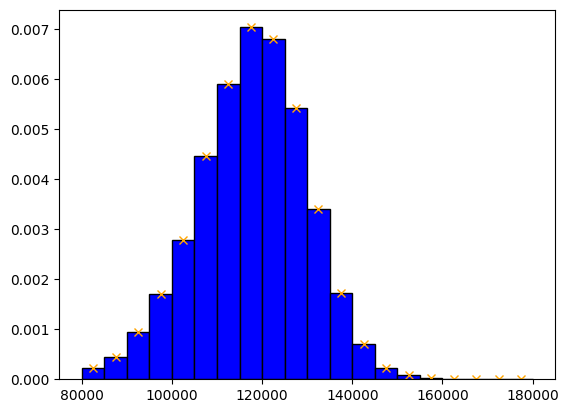

In [28]:
VBFHH_mbb_counts, VBFHH_mbb_bins, _ = plt.hist(VBFHH_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=VBFHH_weights)

VBFHH_mbb_err = get_poisson_errors(VBFHH_mbb_counts, VBFHH_weights)

plt.errorbar(mbb_bin_centers, VBFHH_mbb_counts, yerr=VBFHH_mbb_err, marker='x', color='orange', ls='')

#np.mean(VBFHH_mbb_err, axis=0), VBFHH_mbb_err

In [29]:
VBFHH_mbb_popt, VBFHH_mbb_pcov = curve_fit(dscb_func, mbb_bin_centers, VBFHH_mbb_counts, p0=[120000,12000,1.5,1.5,3,3,0.007], \
                                           sigma=np.mean(VBFHH_mbb_err, axis=0), absolute_sigma=True)

VBFHH_mbb_ratio, VBFHH_mbb_residuals, VBFHH_mbb_chi_red, VBFHH_mbb_chi \
= fit_evaluation(dscb_func, mbb_bin_centers, VBFHH_mbb_counts, np.mean(VBFHH_mbb_err, axis=0), VBFHH_mbb_popt)

VBFHH_mbb_legend = get_legend(VBFHH_mbb_popt, VBFHH_mbb_pcov, VBFHH_mbb_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: overflow encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in multiply
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/2443743946.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(y == 0, np.nan, func(x,*params) / y)


/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


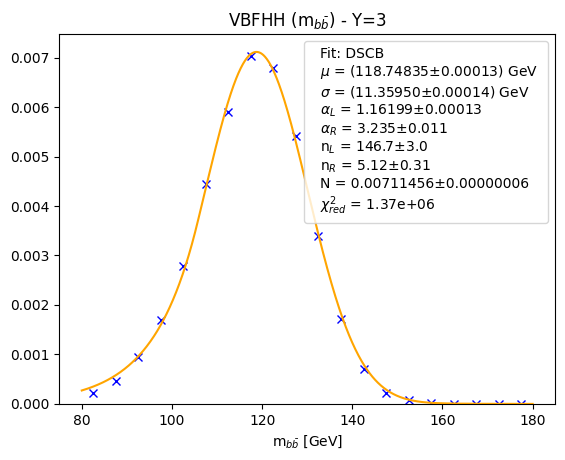

In [30]:
plt.title(r'VBFHH (m$_{b\bar{b}}$) - Y=3')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, dscb_func(mbb_plot,*VBFHH_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=VBFHH_mbb_legend)

plt.errorbar(mbb_bin_centers, VBFHH_mbb_counts, yerr=VBFHH_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(VBFHH_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=VBFHH_weights)

_=plt.legend(handlelength=0)

#plt.savefig('./Plots/Y0-mbb/VBFHH_mbb_Y0.pdf', format='pdf')

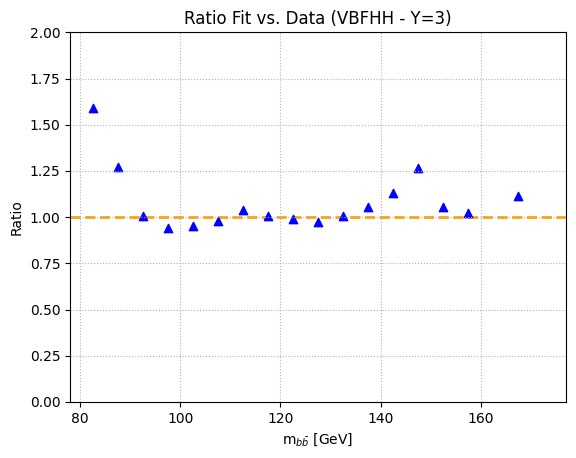

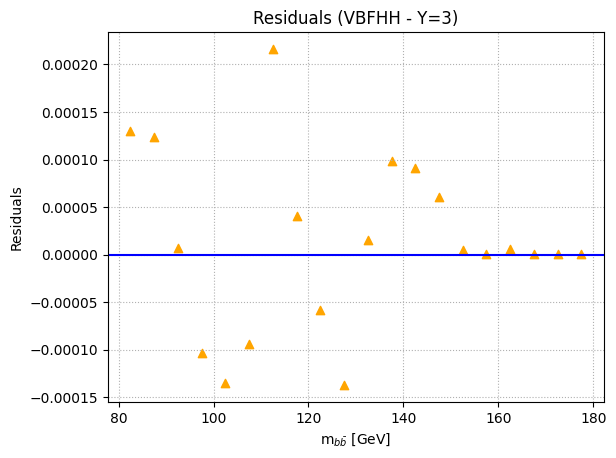

In [31]:
plt.ylim(0,2)

plot_ratio_red(mbb_bin_centers, VBFHH_mbb_ratio, VBFHH_mbb_residuals, r'VBFHH - Y=3', 'mbb')

---

### VBFHH - m$_{\gamma\gamma}$

In [32]:
VBFHH_myy = VBFHH_myy * 1e3

<ErrorbarContainer object of 3 artists>

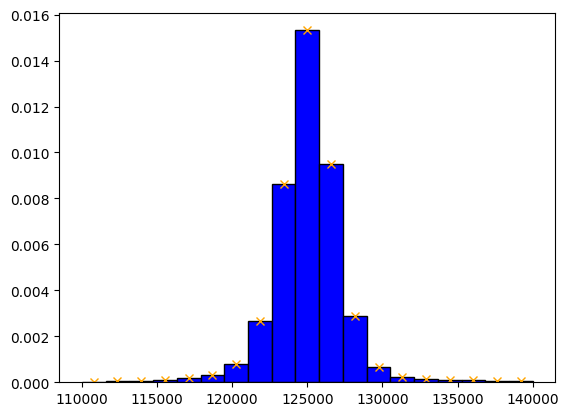

In [33]:
VBFHH_myy_counts, VBFHH_myy_bins, _ = plt.hist(VBFHH_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=VBFHH_weights)

VBFHH_myy_err = get_poisson_errors(VBFHH_myy_counts, VBFHH_weights)

plt.errorbar(myy_bin_centers, VBFHH_myy_counts, yerr=VBFHH_myy_err, marker='x', color='orange', ls='')

In [34]:
VBFHH_myy_popt, VBFHH_myy_pcov = curve_fit(dscb_func, myy_bin_centers, VBFHH_myy_counts, p0=[125e3, 3.5e3, 1.64, 1.64612321e+00, \
       1.3, 13, 0.016], sigma=np.mean(VBFHH_myy_err, axis=0), absolute_sigma=True)

VBFHH_myy_mu, VBFHH_myy_sig, VBFHH_myy_aL, VBFHH_myy_aR, VBFHH_myy_nL, VBFHH_myy_nR, VBFHH_myy_N \
= get_params_dscb(VBFHH_myy_popt, VBFHH_myy_pcov, '')

VBFHH_myy_ratio, VBFHH_myy_residuals, VBFHH_myy_chi_red, VBFHH_myy_chi = \
fit_evaluation(dscb_func, myy_bin_centers, VBFHH_myy_counts, np.mean(VBFHH_myy_err, axis=0), VBFHH_myy_popt)

VBFHH_myy_legend = get_legend(VBFHH_myy_popt, VBFHH_myy_pcov, VBFHH_myy_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


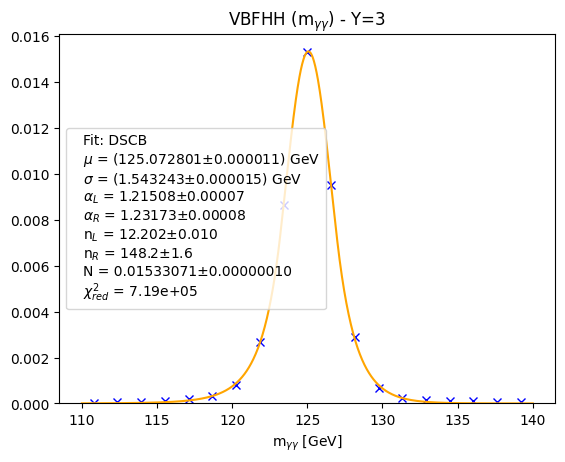

In [35]:
plt.title(r'VBFHH (m$_{\gamma\gamma}$) - Y=3')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))

plt.plot(myy_plot, dscb_func(myy_plot,*VBFHH_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=VBFHH_myy_legend)

plt.errorbar(myy_bin_centers, VBFHH_myy_counts, yerr=VBFHH_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(VBFHH_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=VBFHH_weights)

_=plt.legend(handlelength=0)

#plt.savefig('./Plots/Y0-myy/VBFHH_myy_Y0.pdf', format='pdf')

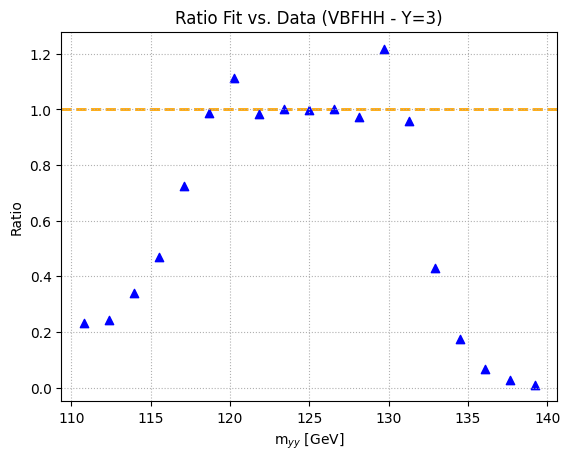

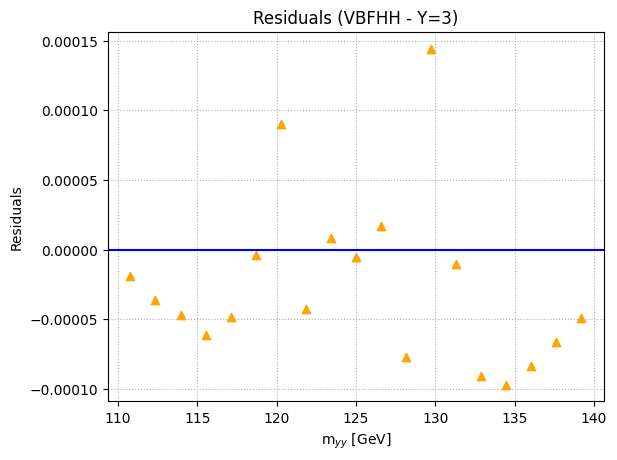

In [36]:
plot_ratio_red(myy_bin_centers, VBFHH_myy_ratio, VBFHH_myy_residuals, r'VBFHH - Y=3', 'myy')

---
---

## ggFH

In [37]:
ggFH_mbb, ggFH_myy, ggFH_weights = read_data_sens('ggFH',3)

#ggFH_mbb, ggFH_myy = ggFH_mbb_MeV * 1e-3, ggFH_myy_MeV * 1e-3

### ggFH - $m_{b\bar{b}}$

In [38]:
#ggFH_mbb_err = get_errors(ggFH_mbb, ggFH_weights, mbb_bins, mbb_bin_num)

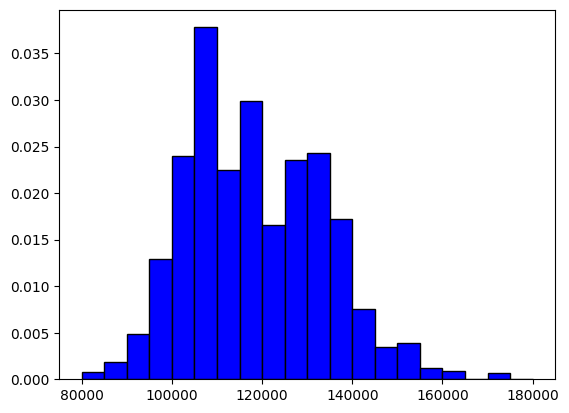

In [39]:
ggFH_mbb_counts, ggFH_mbb_bins, _ = plt.hist(ggFH_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=ggFH_weights)

ggFH_mbb_err = get_poisson_errors(ggFH_mbb_counts, ggFH_weights)

#plt.errorbar(mbb_bin_centers, ggFH_mbb_counts, yerr=ggFH_mbb_err, marker='x', color='orange', ls='')

In [40]:
ggFH_mbb_popt, ggFH_mbb_pcov = curve_fit(gauss_func, mbb_bin_centers, ggFH_mbb_counts, p0=[105e3,17e3,0.035], \
                                         sigma=np.mean(ggFH_mbb_err, axis=0), absolute_sigma=True)

ggFH_mbb_a = ufloat(ggFH_mbb_popt[0], np.sqrt(ggFH_mbb_pcov[0][0]))
ggFH_mbb_b = ufloat(ggFH_mbb_popt[1], np.sqrt(ggFH_mbb_pcov[1][1]))

ggFH_mbb_ratio, ggFH_mbb_residuals, ggFH_mbb_chi_red, ggFH_mbb_chi = fit_evaluation(gauss_func, mbb_bin_centers, ggFH_mbb_counts, np.mean(ggFH_mbb_err, axis=0), ggFH_mbb_popt)

ggFH_mbb_legend = get_legend(ggFH_mbb_popt, ggFH_mbb_pcov, ggFH_mbb_chi_red, gauss_labels, gauss_units)

/tmp/ipykernel_385/2443743946.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(y == 0, np.nan, func(x,*params) / y)


In [41]:
ggFH_mbb_popt, ggFH_mbb_pcov, ggFH_mbb_counts, mbb_bin_centers

(array([1.16893875e+05, 1.64403720e+04, 2.89847872e-02]),
 array([[ 7.06534966e+03, -9.83438607e+01,  3.45337103e-05],
        [-9.83438607e+01,  7.16268666e+03, -6.41242555e-03],
        [ 3.45337103e-05, -6.41242555e-03,  1.68910373e-08]]),
 array([0.00078382, 0.00186336, 0.004862  , 0.01289695, 0.0239443 ,
        0.03781641, 0.02246828, 0.02984978, 0.01658381, 0.02355695,
        0.02431339, 0.0172062 , 0.0075924 , 0.00342727, 0.00389729,
        0.00119982, 0.00089268, 0.        , 0.00071764, 0.        ]),
 array([ 82500.,  87500.,  92500.,  97500., 102500., 107500., 112500.,
        117500., 122500., 127500., 132500., 137500., 142500., 147500.,
        152500., 157500., 162500., 167500., 172500., 177500.]))

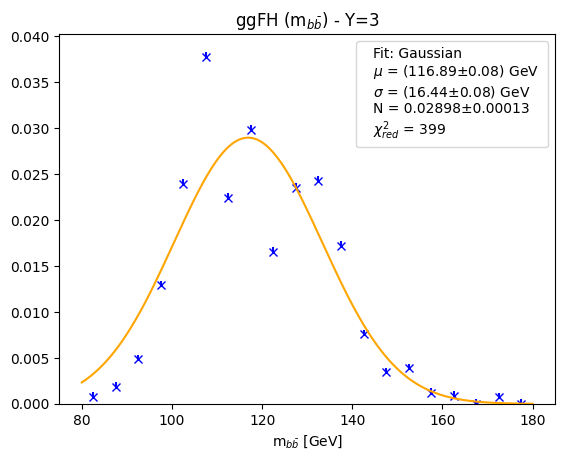

In [42]:
plt.title(r'ggFH (m$_{b\bar{b}}$) - Y=3')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, gauss_func(mbb_plot,*ggFH_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ggFH_mbb_legend)

plt.errorbar(mbb_bin_centers, ggFH_mbb_counts, yerr=ggFH_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ggFH_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=ggFH_weights)

_=plt.legend(handlelength=0)

#plt.savefig('./Plots/Y0-mbb/ggFH_mbb_Y0.pdf', format='pdf')

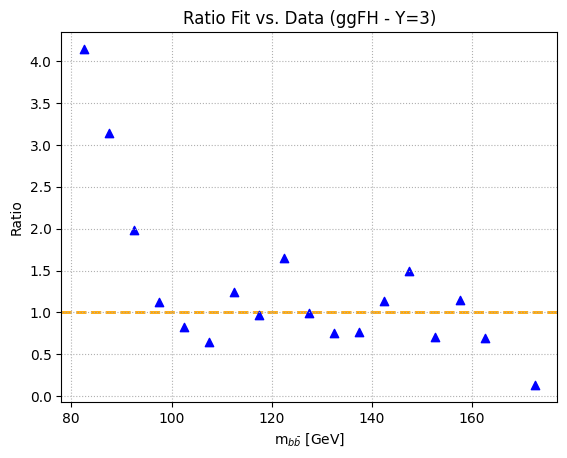

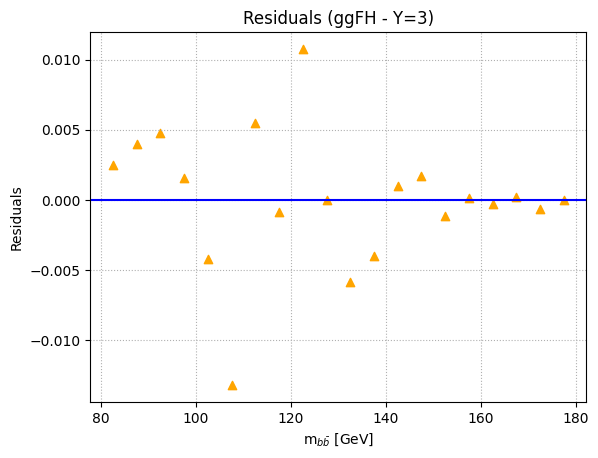

In [43]:
plot_ratio_red(mbb_bin_centers, ggFH_mbb_ratio, ggFH_mbb_residuals, r'ggFH - Y=3', 'mbb')

---

### ggFH - m$_{\gamma\gamma}$

In [44]:
ggFH_myy *= 1e3

<ErrorbarContainer object of 3 artists>

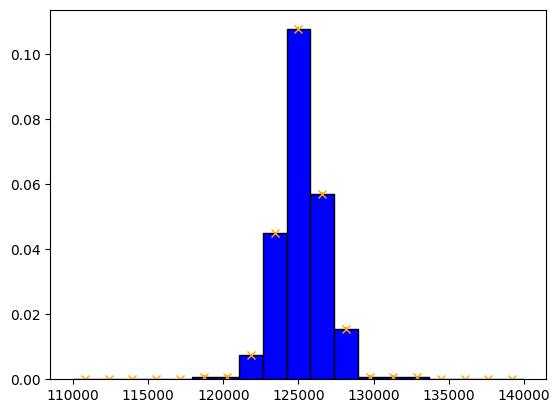

In [45]:
ggFH_myy_counts, ggFH_myy_bins, _ = plt.hist(ggFH_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=ggFH_weights)

ggFH_myy_err = get_poisson_errors(ggFH_myy_counts, ggFH_weights)

#ggFH_myy_err = ggFH_myy_err[ggFH_myy_counts > 0]
#ggFH_myy_bins = ggFH_myy_bins[:-1][ggFH_myy_counts > 0] + (myy_max-myy_min)/myy_bin_num/2
#ggFH_myy_counts = ggFH_myy_counts[ggFH_myy_counts > 0]

plt.errorbar(myy_bin_centers, ggFH_myy_counts, yerr=ggFH_myy_err, marker='x', color='orange', ls='')

In [50]:
ggFH_myy_popt, ggFH_myy_pcov = curve_fit(dscb_func, myy_bin_centers, ggFH_myy_counts, p0=[125e3, 1.6e3, 1.64, 1.41, \
       5, 13, 0.09], sigma=np.mean(ggFH_myy_err, axis=0), absolute_sigma=True)

ggFH_myy_mu, ggFH_myy_sig, ggFH_myy_aL, ggFH_myy_aR, ggFH_myy_nL, ggFH_myy_nR, ggFH_myy_N \
= get_params_dscb(ggFH_myy_popt, ggFH_myy_pcov, '')

ggFH_myy_ratio, ggFH_myy_residuals, ggFH_myy_chi_red, ggFH_myy_chi = \
fit_evaluation(dscb_func, myy_bin_centers, ggFH_myy_counts, np.mean(ggFH_myy_err, axis=0), ggFH_myy_popt)

ggFH_myy_legend = get_legend(ggFH_myy_popt, ggFH_myy_pcov, ggFH_myy_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: invalid value encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/2443743946.py:2: RuntimeWarning: divide by zero encountered in divide
  rati

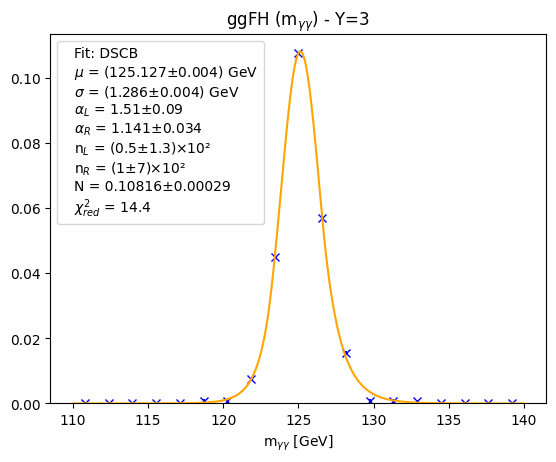

In [51]:
plt.title(r'ggFH (m$_{\gamma\gamma}$) - Y=3')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))

plt.plot(myy_plot, dscb_func(myy_plot,*ggFH_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ggFH_myy_legend)

plt.errorbar(myy_bin_centers, ggFH_myy_counts, yerr=ggFH_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ggFH_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=ggFH_weights)

_=plt.legend(handlelength=0)

#plt.savefig('./Plots/Y0-myy/ggFH_myy_Y0.pdf', format='pdf')

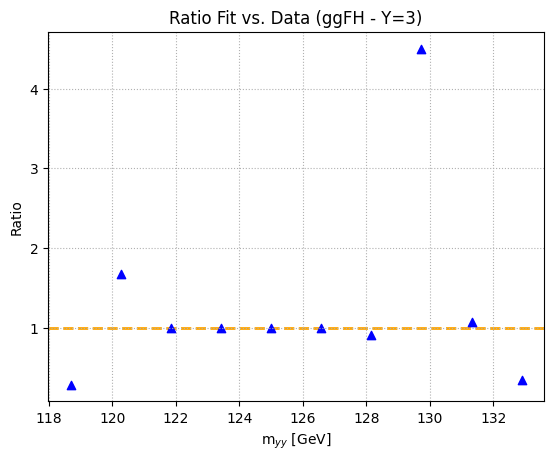

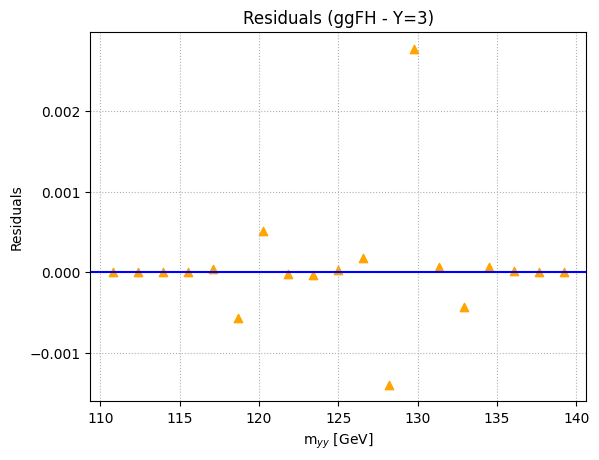

In [52]:
plot_ratio_red(myy_bin_centers, ggFH_myy_ratio, ggFH_myy_residuals, r'ggFH - Y=3', 'myy')

---
---

## ttH

In [53]:
ttH_mbb, ttH_myy, ttH_weights = read_data_sens('ttH',3)

### ttH - m$_{b\bar{b}}$

In [54]:
#ttH_mbb_err = get_errors(ttH_mbb, ttH_weights, mbb_bins, mbb_bin_num)

<ErrorbarContainer object of 3 artists>

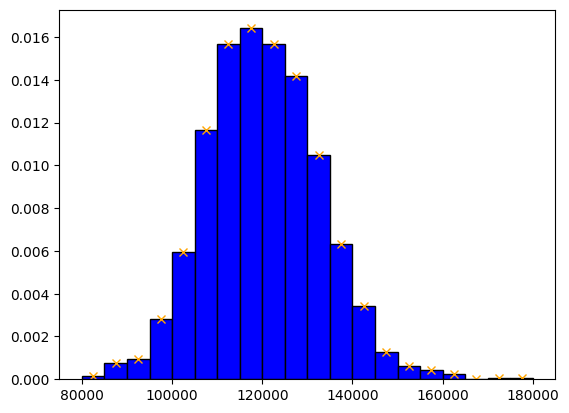

In [55]:
ttH_mbb_counts, ttH_mbb_bins, _ = plt.hist(ttH_mbb, bins=mbb_bin_num, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=ttH_weights)

ttH_mbb_err = get_poisson_errors(ttH_mbb_counts, ttH_weights)

plt.errorbar(mbb_bin_centers, ttH_mbb_counts, yerr=ttH_mbb_err, marker='x', color='orange', ls='')

In [56]:
ttH_mbb_popt, ttH_mbb_pcov = curve_fit(dscb_func, mbb_bin_centers, ttH_mbb_counts, \
                                       p0 = [120000,15000,0.8,0.8,25,25,0.016], sigma=np.mean(ttH_mbb_err, axis=0), absolute_sigma=True)

ttH_mbb_ratio, ttH_mbb_residuals, ttH_mbb_chi_red, ttH_mbb_chi = fit_evaluation(dscb_func, mbb_bin_centers, ttH_mbb_counts, np.mean(ttH_mbb_err, axis=0), ttH_mbb_popt)

ttH_mbb_legend = get_legend(ttH_mbb_popt, ttH_mbb_pcov, ttH_mbb_chi_red, dscb_labels, dscb_units)

ttH_mbb_popt, ttH_mbb_pcov

/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: invalid value encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: overflow encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in multiply
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = 

(array([1.19493389e+05, 1.22444849e+04, 1.43867226e+00, 1.24041647e+00,
        1.52254082e+02, 1.16424354e+02, 1.69951950e-02]),
 array([[ 5.35975301e+01,  1.16467373e+01, -1.25177586e-02,
          1.83681088e-02,  1.85641957e+02, -1.33792238e+02,
         -4.63842271e-06],
        [ 1.16467373e+01,  9.52826318e+01,  4.60138672e-02,
          3.55632755e-02, -4.68584853e+02, -2.02707970e+02,
         -5.30710808e-05],
        [-1.25177586e-02,  4.60138672e-02,  1.66132426e-04,
          1.34069336e-05, -3.21957259e+00, -6.85669391e-02,
         -1.90545576e-08],
        [ 1.83681088e-02,  3.55632755e-02,  1.34069336e-05,
          5.10969904e-05, -1.24405223e-01, -4.89424719e-01,
         -1.30799406e-08],
        [ 1.85641957e+02, -4.68584853e+02, -3.21957259e+00,
         -1.24405223e-01,  7.78222550e+04,  6.03874904e+02,
          1.73267736e-04],
        [-1.33792238e+02, -2.02707970e+02, -6.85669391e-02,
         -4.89424719e-01,  6.03874904e+02,  6.36735845e+03,
          6.078

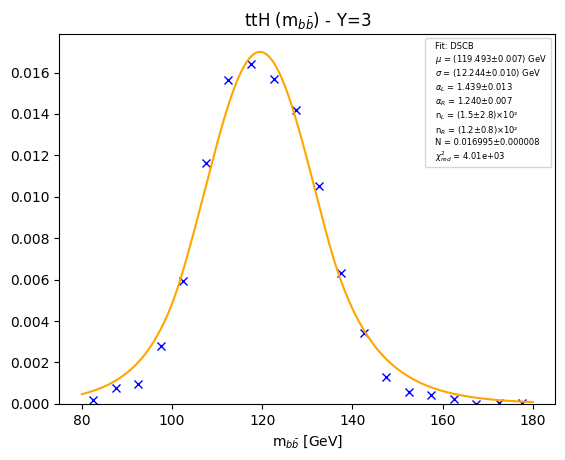

In [57]:
plt.title(r'ttH (m$_{b\bar{b}}$) - Y=3')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, dscb_func(mbb_plot,*ttH_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ttH_mbb_legend)

plt.errorbar(mbb_bin_centers, ttH_mbb_counts, yerr=ttH_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ttH_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=ttH_weights)

_=plt.legend(handlelength=0, fontsize=6)

#plt.savefig('./Plots/Y0-mbb/ttH_mbb_Y0.pdf', format='pdf')

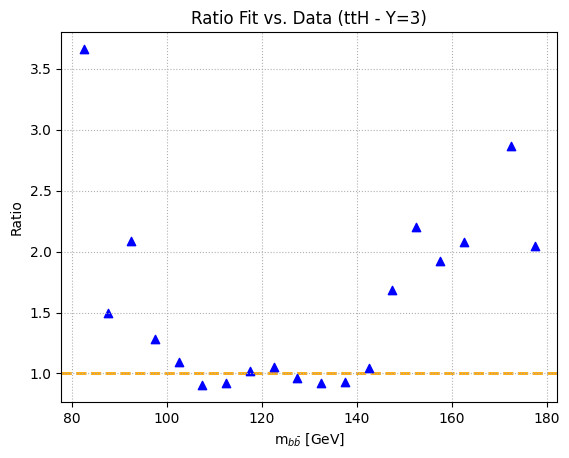

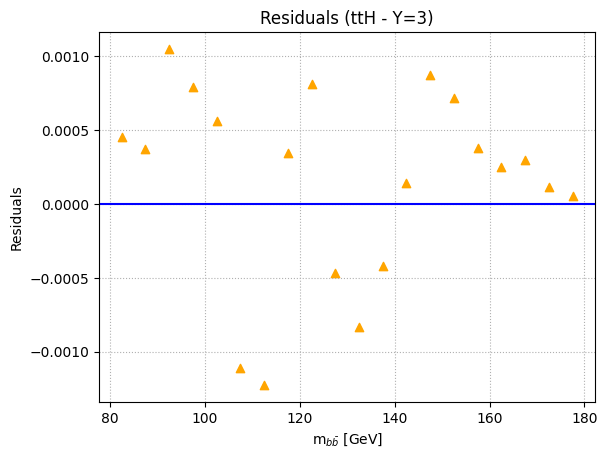

In [58]:
plot_ratio_red(mbb_bin_centers, ttH_mbb_ratio, ttH_mbb_residuals, r'ttH - Y=3', 'mbb')

---

### ttH - m$_{\gamma\gamma}$

In [59]:
ttH_myy *= 1e3

<ErrorbarContainer object of 3 artists>

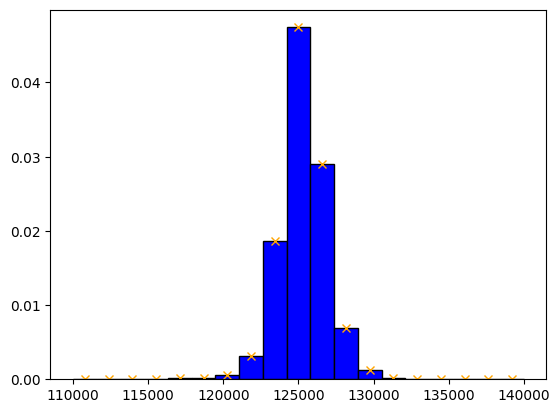

In [60]:
ttH_myy_counts, ttH_myy_bins, _ = plt.hist(ttH_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=ttH_weights)

ttH_myy_err = get_poisson_errors(ttH_myy_counts, ttH_weights)

plt.errorbar(myy_bin_centers, ttH_myy_counts, yerr=ttH_myy_err, marker='x', color='orange', ls='')

In [61]:
ttH_myy_popt, ttH_myy_pcov = curve_fit(dscb_func, myy_bin_centers, ttH_myy_counts, p0=[125e3, 3.5e3, 1.64, 1.64612321e+00, \
       1.3, 13, 0.045], sigma=np.mean(ttH_myy_err, axis=0), absolute_sigma=True)

ttH_myy_mu, ttH_myy_sig, ttH_myy_aL, ttH_myy_aR, ttH_myy_nL, ttH_myy_nR, ttH_myy_N \
= get_params_dscb(ttH_myy_popt, ttH_myy_pcov, '')

ttH_myy_ratio, ttH_myy_residuals, ttH_myy_chi_red, ttH_myy_chi = fit_evaluation(dscb_func, myy_bin_centers, ttH_myy_counts, np.mean(ttH_myy_err, axis=0), ttH_myy_popt)

ttH_myy_legend = get_legend(ttH_myy_popt, ttH_myy_pcov, ttH_myy_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/2443743946.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(y == 0, np.nan, func(x,*params) / y)


/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


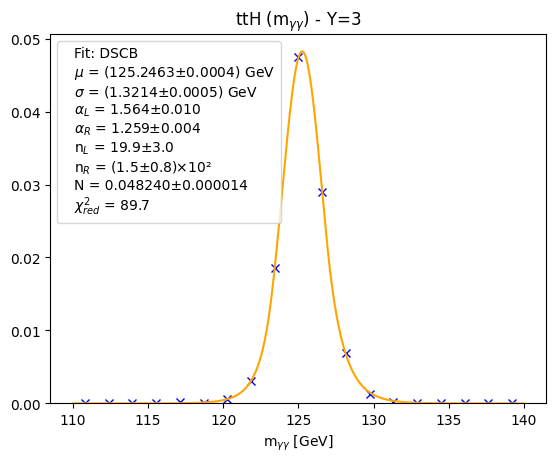

In [62]:
plt.title(r'ttH (m$_{\gamma\gamma}$) - Y=3')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))

plt.plot(myy_plot, dscb_func(myy_plot,*ttH_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ttH_myy_legend)

plt.errorbar(myy_bin_centers, ttH_myy_counts, yerr=ttH_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ttH_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=ttH_weights)

_=plt.legend(handlelength=0)

#plt.savefig('./Plots/Y0-myy/ttH_myy_Y0.pdf', format='pdf')

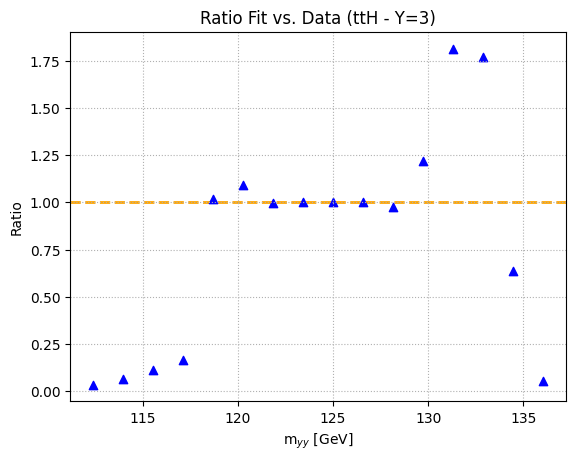

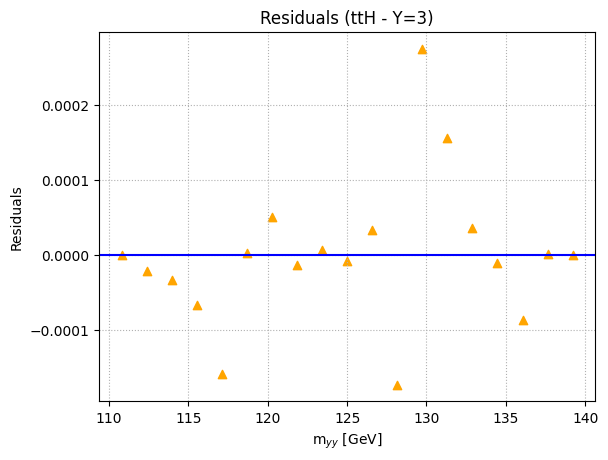

In [63]:
plot_ratio_red(myy_bin_centers, ttH_myy_ratio, ttH_myy_residuals, r'ttH - Y=3', 'myy')

---
---

## qqZH

In [64]:
qqZH_mbb, qqZH_myy, qqZH_weights = read_data_sens('qqZH',3)

### qqZH - m$_{b\bar{b}}$

In [65]:
#qqZH_mbb_err = get_errors(qqZH_mbb, qqZH_weights, mbb_bins, mbb_bin_num)

<ErrorbarContainer object of 3 artists>

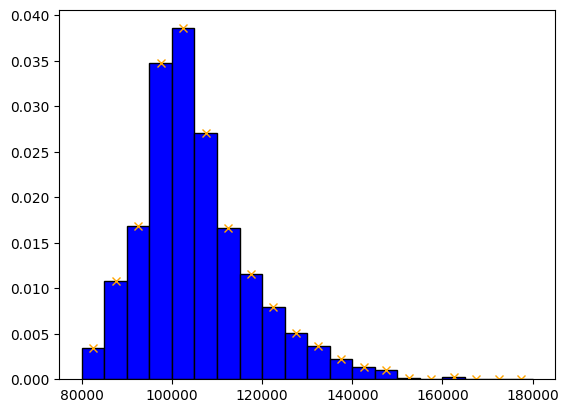

In [66]:
qqZH_mbb_counts, qqZH_mbb_bins, _ = plt.hist(qqZH_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=qqZH_weights)

qqZH_mbb_err = get_poisson_errors(qqZH_mbb_counts, qqZH_weights)

plt.errorbar(mbb_bin_centers, qqZH_mbb_counts, yerr=qqZH_mbb_err, marker='x', color='orange', ls='')

In [69]:
qqZH_mbb_popt, qqZH_mbb_pcov = curve_fit(cb_func, mbb_bin_centers, qqZH_mbb_counts, \
                                       p0 = [100e3, 8e3, 0.5, 5, 0.04], sigma=np.mean(qqZH_mbb_err, axis=0), absolute_sigma=True)

qqZH_mbb_ratio, qqZH_mbb_residuals, qqZH_mbb_chi_red, qqZH_mbb_chi = fit_evaluation(cb_func, mbb_bin_centers, qqZH_mbb_counts, np.mean(qqZH_mbb_err, axis=0), qqZH_mbb_popt)

qqZH_mbb_legend = get_legend(qqZH_mbb_popt, qqZH_mbb_pcov, qqZH_mbb_chi_red, cb_labels, cb_units)

/tmp/ipykernel_385/2443743946.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(y == 0, np.nan, func(x,*params) / y)


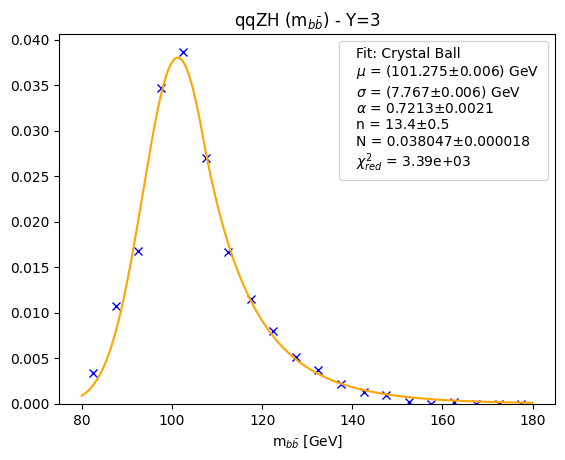

In [70]:
plt.title(r'qqZH (m$_{b\bar{b}}$) - Y=3')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, cb_func(mbb_plot,*qqZH_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=qqZH_mbb_legend)

plt.errorbar(mbb_bin_centers, qqZH_mbb_counts, yerr=qqZH_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(qqZH_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=qqZH_weights)

_=plt.legend(handlelength=0)

#plt.savefig('./Plots/Y0-mbb/qqZH_mbb_Y0.pdf', format='pdf')

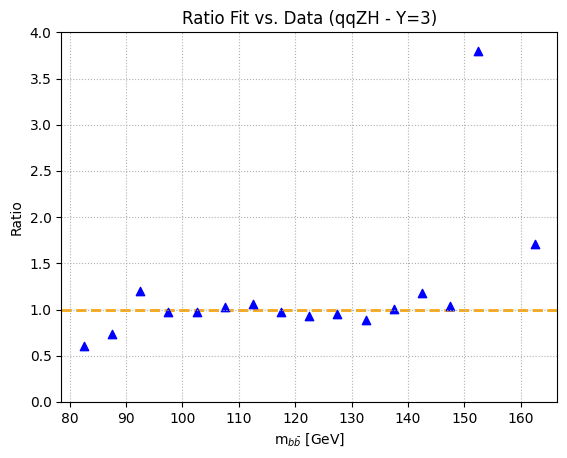

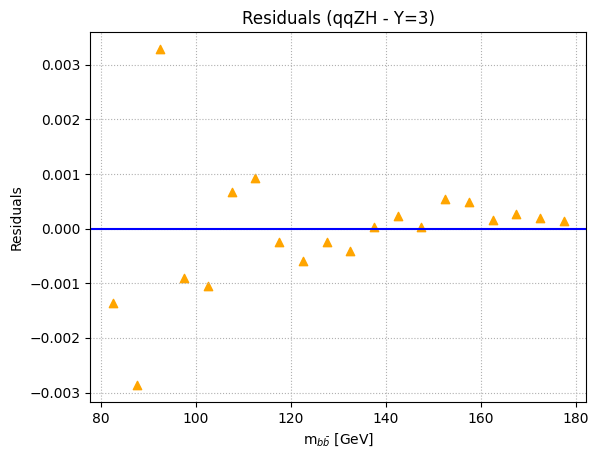

In [71]:
plt.ylim(0,4)

plot_ratio_red(mbb_bin_centers, qqZH_mbb_ratio, qqZH_mbb_residuals, r'qqZH - Y=3', 'mbb')

---

### qqZH - m$_{\gamma\gamma}$

In [72]:
qqZH_myy *= 1e3

<ErrorbarContainer object of 3 artists>

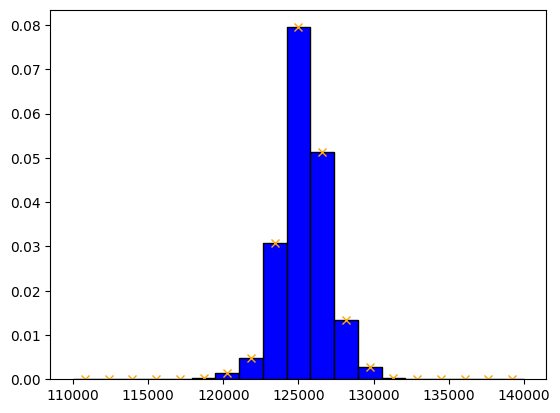

In [73]:
qqZH_myy_counts, qqZH_myy_bins, _ = plt.hist(qqZH_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=qqZH_weights)

qqZH_myy_err = get_poisson_errors(qqZH_myy_counts, qqZH_weights)

#qqZH_myy_err = qqZH_myy_err[qqZH_myy_counts > 0]
#qqZH_myy_bins = qqZH_myy_bins[:-1][qqZH_myy_counts > 0] + (myy_max-myy_min)/myy_bin_num/2
#qqZH_myy_counts = qqZH_myy_counts[qqZH_myy_counts > 0]

plt.errorbar(myy_bin_centers, qqZH_myy_counts, yerr=qqZH_myy_err, marker='x', color='orange', ls='')

In [74]:
qqZH_myy_popt, qqZH_myy_pcov = curve_fit(dscb_func, myy_bin_centers, qqZH_myy_counts, p0=[125e3, 2.5e3, 1.64, 1.64612321e+00, \
       4, 12, 0.08], sigma=np.mean(qqZH_myy_err, axis=0), absolute_sigma=True)

qqZH_myy_mu, ggFH_myy_sig, qqZH_myy_aL, qqZH_myy_aR, qqZH_myy_nL, qqZH_myy_nR, qqZH_myy_N \
= get_params_dscb(qqZH_myy_popt, qqZH_myy_pcov, '')

qqZH_myy_ratio, qqZH_myy_residuals, qqZH_myy_chi_red, qqZH_myy_chi = fit_evaluation(dscb_func, myy_bin_centers, qqZH_myy_counts, np.mean(qqZH_myy_err, axis=0), qqZH_myy_popt)

qqZH_myy_legend = get_legend(qqZH_myy_popt, qqZH_myy_pcov, qqZH_myy_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/2443743946.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(y == 0, np.nan, func(x,*params) / y)


/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


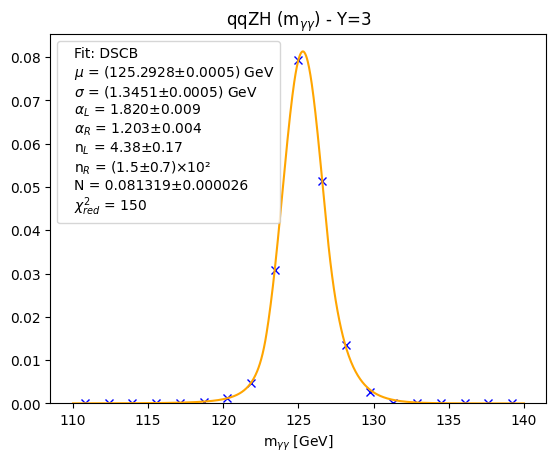

In [75]:
plt.title(r'qqZH (m$_{\gamma\gamma}$) - Y=3')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))

plt.plot(myy_plot, dscb_func(myy_plot,*qqZH_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=qqZH_myy_legend)

plt.errorbar(myy_bin_centers, qqZH_myy_counts, yerr=qqZH_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(qqZH_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=qqZH_weights)

_=plt.legend(handlelength=0)

#plt.savefig('./Plots/Y0-myy/qqZH_myy_Y0.pdf', format='pdf')

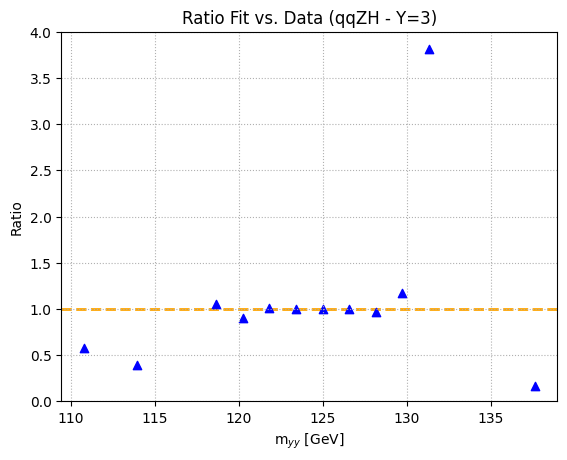

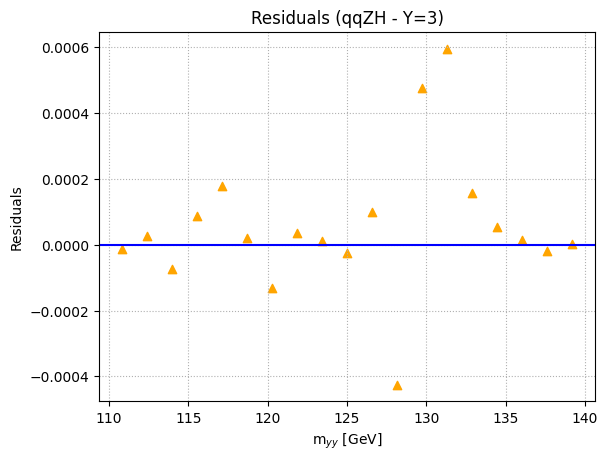

In [76]:
plt.ylim(0,4)

plot_ratio_red(myy_bin_centers, qqZH_myy_ratio, qqZH_myy_residuals, 'qqZH - Y=3', 'myy')

---
---

## yybb

In [77]:
yybb_mbb, yybb_myy, yybb_weights = read_data_sens('yybb',3)

### yybb - m$_{b\bar{b}}$

<ErrorbarContainer object of 3 artists>

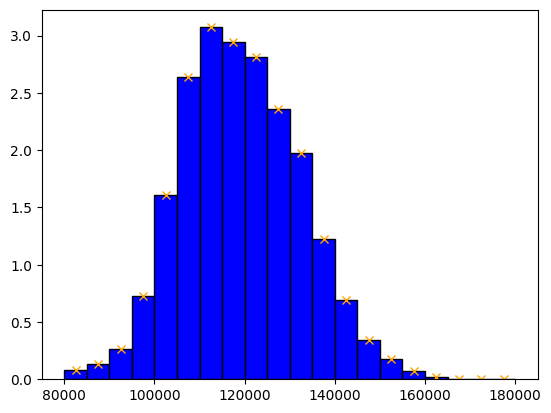

In [78]:
yybb_mbb_counts, yybb_mbb_bins, _ = plt.hist(yybb_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=yybb_weights)

yybb_mbb_err = get_poisson_errors(yybb_mbb_counts, yybb_weights)

plt.errorbar(mbb_bin_centers, yybb_mbb_counts, yerr=yybb_mbb_err, marker='x', color='orange', ls='')

In [79]:
yybb_mbb_popt, yybb_mbb_pcov = curve_fit(cb_func, mbb_bin_centers, yybb_mbb_counts, \
                                         p0=[110e3, 20e3, 1.5, 5, 3], \
                                         sigma=np.mean(yybb_mbb_err, axis=0), absolute_sigma=True)

yybb_mbb_a = ufloat(yybb_mbb_popt[0], np.sqrt(yybb_mbb_pcov[0][0]))
yybb_mbb_b = ufloat(yybb_mbb_popt[1], np.sqrt(yybb_mbb_pcov[1][1]))

yybb_mbb_ratio, yybb_mbb_residuals, yybb_mbb_chi_red, yybb_mbb_chi = fit_evaluation(cb_func, mbb_bin_centers, yybb_mbb_counts, np.mean(yybb_mbb_err, axis=0), yybb_mbb_popt)

yybb_mbb_legend = get_legend(yybb_mbb_popt, yybb_mbb_pcov, yybb_mbb_chi_red, cb_labels, cb_units)

/tmp/ipykernel_385/1638362595.py:2: RuntimeWarning: invalid value encountered in scalar power
  A = (n / np.abs(alpha)) ** n * np.exp(-0.5 * alpha ** 2)
/tmp/ipykernel_385/1638362595.py:5: RuntimeWarning: invalid value encountered in power
  right = N * A * (B - (mu - x) / sigma) ** -n
/tmp/ipykernel_385/1638362595.py:2: RuntimeWarning: overflow encountered in scalar power
  A = (n / np.abs(alpha)) ** n * np.exp(-0.5 * alpha ** 2)
/tmp/ipykernel_385/1638362595.py:5: RuntimeWarning: invalid value encountered in multiply
  right = N * A * (B - (mu - x) / sigma) ** -n


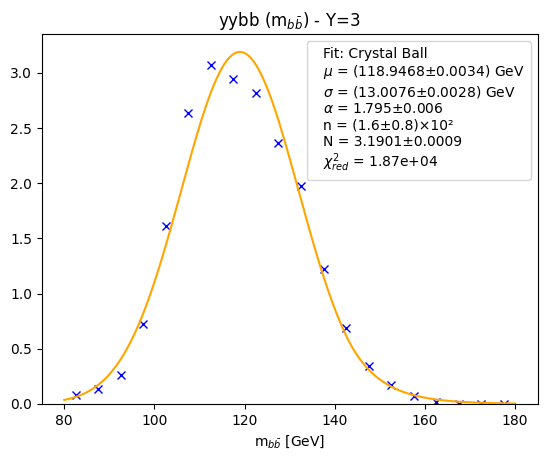

In [80]:
plt.title(r'yybb (m$_{b\bar{b}}$) - Y=3')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, cb_func(mbb_plot,*yybb_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=yybb_mbb_legend)

plt.errorbar(mbb_bin_centers, yybb_mbb_counts, yerr=yybb_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(yybb_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=yybb_weights)

_=plt.legend(handlelength=0)

#plt.savefig('./Plots/Y0-mbb/yybb_mbb_Y0.pdf', format='pdf')

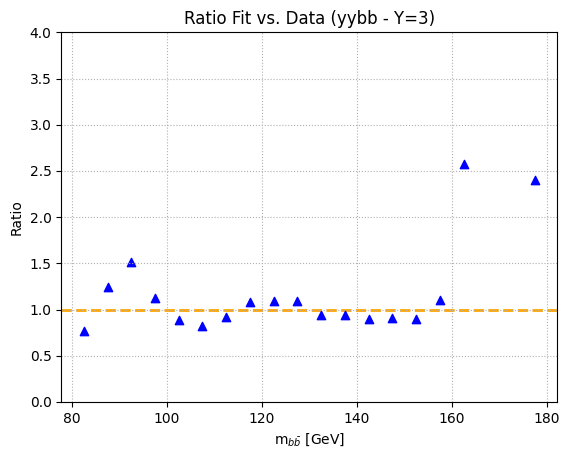

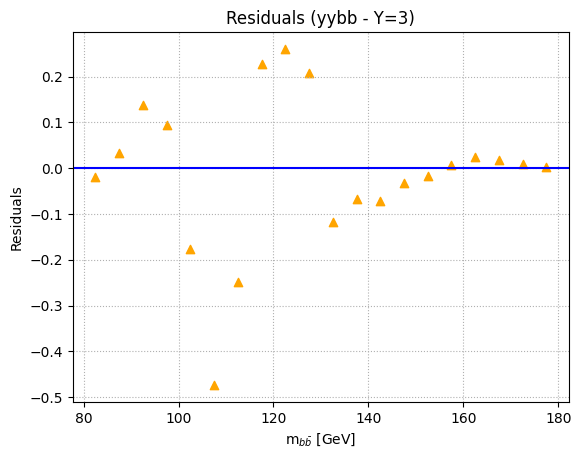

In [81]:
plt.ylim(0,4)

plot_ratio_red(mbb_bin_centers, yybb_mbb_ratio, yybb_mbb_residuals, r'yybb - Y=3', 'mbb')

---

### yybb - m$_{\gamma\gamma}$

In [82]:
yybb_myy *= 1e3

<ErrorbarContainer object of 3 artists>

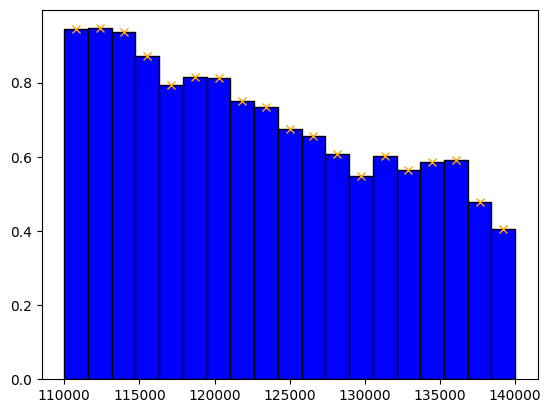

In [83]:
yybb_myy_counts, yybb_myy_bins, _ = plt.hist(yybb_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=yybb_weights)

yybb_myy_err = get_poisson_errors(yybb_myy_counts, yybb_weights)

plt.errorbar(myy_bin_centers, yybb_myy_counts, yerr=yybb_myy_err, marker='x', color='orange', ls='')

In [84]:
yybb_myy_popt, yybb_myy_pcov = curve_fit(exp_fit, myy_bin_centers, yybb_myy_counts, p0=[0.7,1.54e-5], \
                                         sigma=np.mean(yybb_myy_err, axis=0), absolute_sigma=True)

yybb_myy_ratio, yybb_myy_residuals, yybb_myy_chi_red, yybb_myy_chi = fit_evaluation(exp_fit, myy_bin_centers, yybb_myy_counts, np.mean(yybb_myy_err, axis=0), yybb_myy_popt)

yybb_myy_legend = get_legend(yybb_myy_popt, yybb_myy_pcov, yybb_myy_chi_red, exp_fit_labels, exp_fit_units)

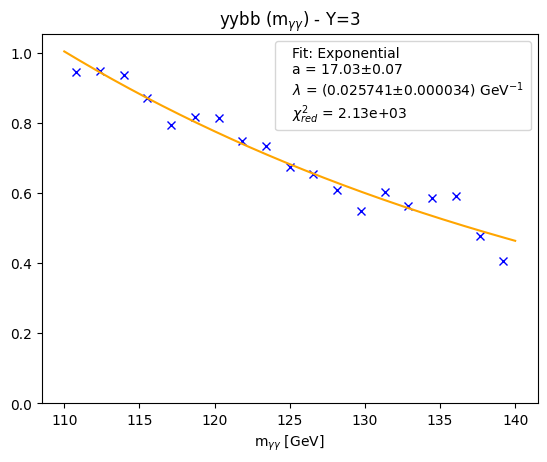

In [85]:
plt.title(r'yybb (m$_{\gamma\gamma}$) - Y=3')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))

plt.plot(myy_plot, exp_fit(myy_plot,*yybb_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=yybb_myy_legend)

plt.errorbar(myy_bin_centers, yybb_myy_counts, yerr=yybb_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(yybb_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=yybb_weights)

_=plt.legend(handlelength=0)

#plt.savefig('./Plots/Y0-myy/yybb_myy_Y0.pdf', format='pdf')

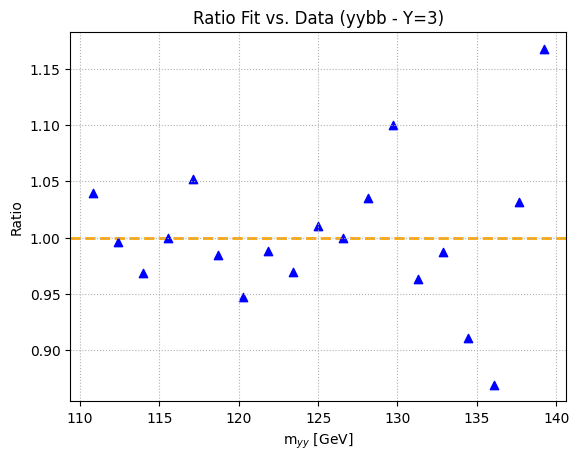

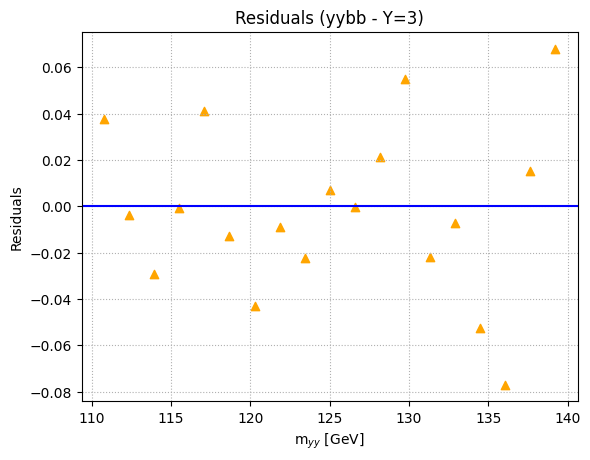

In [86]:
plot_ratio_red(myy_bin_centers, yybb_myy_ratio, yybb_myy_residuals, r'yybb - Y=3', 'myy')

---
---

## ggFHH_kl1

In [87]:
ggFHH_kl1_mbb, ggFHH_kl1_myy, ggFHH_kl1_weights = read_data_sens('ggFHH_kl1',3)

### ggFHH_kl1 - m$_{b\bar{b}}$

In [88]:
#ggFHH_kl1_mbb_err = get_errors(ggFHH_kl1_mbb, ggFHH_kl1_weights, mbb_bins, mbb_bin_num)

<ErrorbarContainer object of 3 artists>

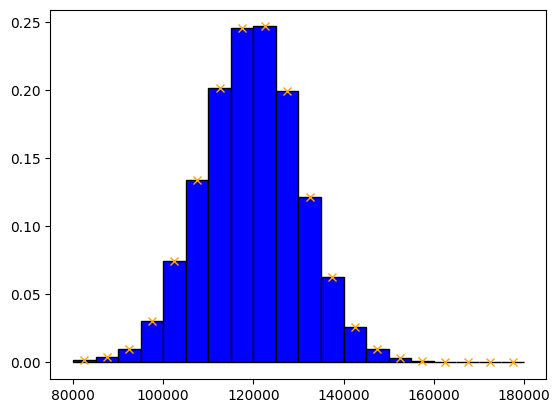

In [89]:
ggFHH_kl1_mbb_counts, ggFHH_kl1_mbb_bins, _ = plt.hist(ggFHH_kl1_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=ggFHH_kl1_weights)

ggFHH_kl1_mbb_err = get_poisson_errors(ggFHH_kl1_mbb_counts, ggFHH_kl1_weights)

plt.errorbar(mbb_bin_centers, ggFHH_kl1_mbb_counts, yerr=ggFHH_kl1_mbb_err, marker='x', color='orange', ls='')

In [90]:
ggFHH_kl1_mbb_popt, ggFHH_kl1_mbb_pcov = \
curve_fit(dscb_func, mbb_bin_centers, ggFHH_kl1_mbb_counts, p0=[120e3,10e3,1.5,1.5,25,25,0.2], \
          sigma=np.mean(ggFHH_kl1_mbb_err, axis=0), absolute_sigma=True)

ggFHH_kl1_mbb_ratio, ggFHH_kl1_mbb_residuals, ggFHH_kl1_mbb_chi_red, ggFHH_kl1_mbb_chi \
= fit_evaluation(dscb_func, mbb_bin_centers, ggFHH_kl1_mbb_counts, np.mean(ggFHH_kl1_mbb_err, axis=0), ggFHH_kl1_mbb_popt)

ggFHH_kl1_mbb_legend = get_legend(ggFHH_kl1_mbb_popt, ggFHH_kl1_mbb_pcov, ggFHH_kl1_mbb_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: overflow encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in multiply
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: invalid value encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


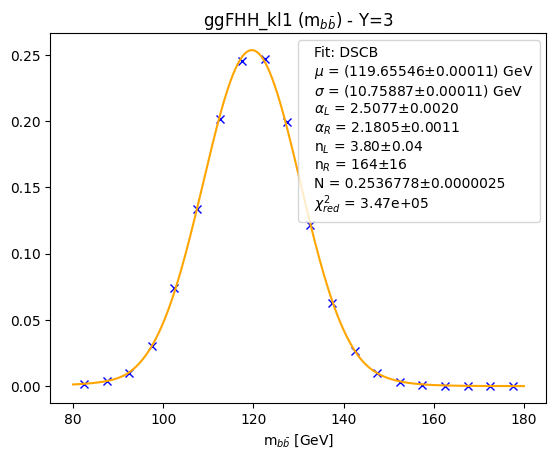

In [91]:
plt.title(r'ggFHH_kl1 (m$_{b\bar{b}}$) - Y=3')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, dscb_func(mbb_plot,*ggFHH_kl1_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ggFHH_kl1_mbb_legend)

plt.errorbar(mbb_bin_centers, ggFHH_kl1_mbb_counts, yerr=ggFHH_kl1_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ggFHH_kl1_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=ggFHH_kl1_weights)

_=plt.legend(handlelength=0)

#plt.savefig('./Plots/Y0-mbb/ggFHH_kl1_mbb_Y0.pdf', format='pdf')

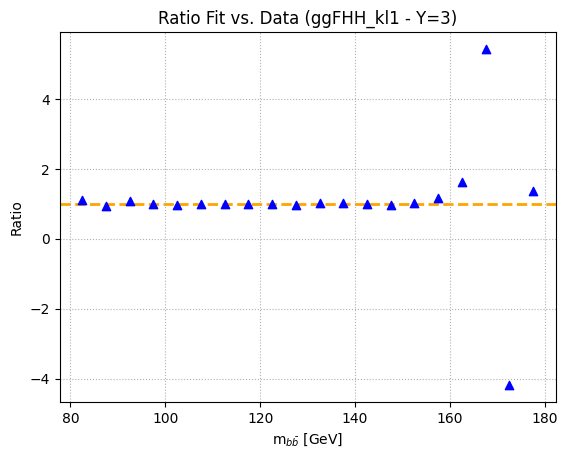

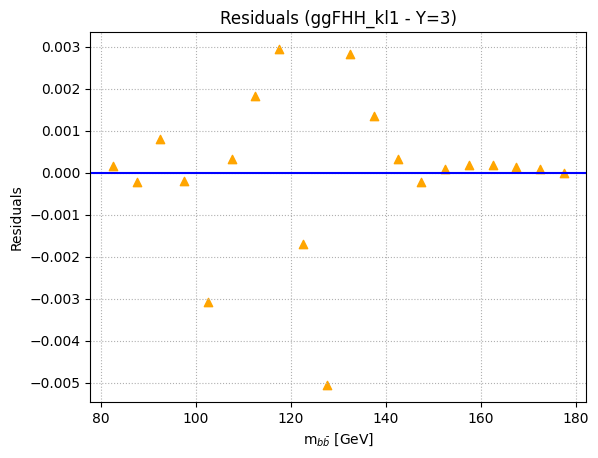

In [92]:
plot_ratio_red(mbb_bin_centers, ggFHH_kl1_mbb_ratio, ggFHH_kl1_mbb_residuals, r'ggFHH_kl1 - Y=3', 'mbb')

---

### ggFHH_kl1 - m$_{\gamma\bar{\gamma}}$

In [93]:
ggFHH_kl1_myy *= 1e3

<ErrorbarContainer object of 3 artists>

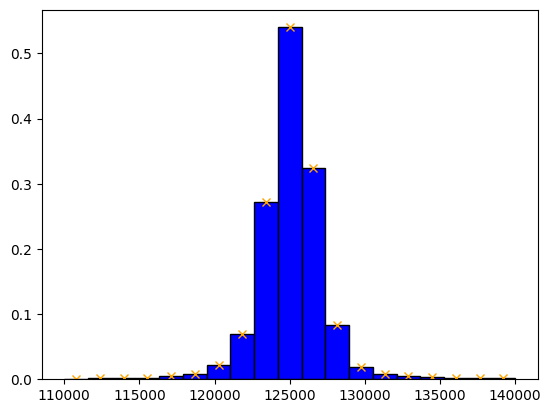

In [94]:
ggFHH_kl1_myy_counts, ggFHH_kl1_myy_bins, _ = plt.hist(ggFHH_kl1_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=ggFHH_kl1_weights)

ggFHH_kl1_myy_err = get_poisson_errors(ggFHH_kl1_myy_counts, ggFHH_kl1_weights)

plt.errorbar(myy_bin_centers, ggFHH_kl1_myy_counts, yerr=ggFHH_kl1_myy_err, marker='x', color='orange', ls='')

In [95]:
ggFHH_kl1_myy_popt, ggFHH_kl1_myy_pcov = curve_fit(dscb_func, myy_bin_centers, ggFHH_kl1_myy_counts, p0=[125e3, 3.5e3, 1.64, 1.64612321e+00, \
       1.3, 13, 0.5], sigma=np.mean(ggFHH_kl1_myy_err, axis=0), absolute_sigma=True)

ggFHH_kl1_myy_ratio, ggFHH_kl1_myy_residuals, ggFHH_kl1_myy_chi_red, ggFHH_kl1_myy_chi \
= fit_evaluation(dscb_func, myy_bin_centers, ggFHH_kl1_myy_counts, np.mean(ggFHH_kl1_myy_err, axis=0), ggFHH_kl1_myy_popt)

ggFHH_kl1_myy_legend = get_legend(ggFHH_kl1_myy_popt, ggFHH_kl1_myy_pcov, ggFHH_kl1_myy_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


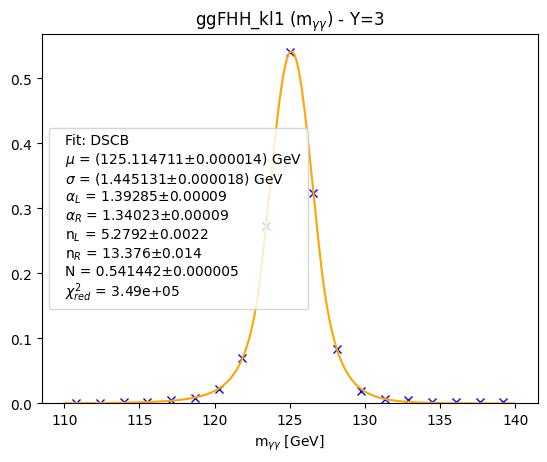

In [96]:
plt.title(r'ggFHH_kl1 (m$_{\gamma\gamma}$) - Y=3')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))

plt.plot(myy_plot, dscb_func(myy_plot,*ggFHH_kl1_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ggFHH_kl1_myy_legend)

plt.errorbar(myy_bin_centers, ggFHH_kl1_myy_counts, yerr=ggFHH_kl1_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ggFHH_kl1_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=ggFHH_kl1_weights)

_=plt.legend(handlelength=0)

#plt.savefig('./Plots/Y0-myy/ggFHH_kl1_myy_Y0.pdf', format='pdf')

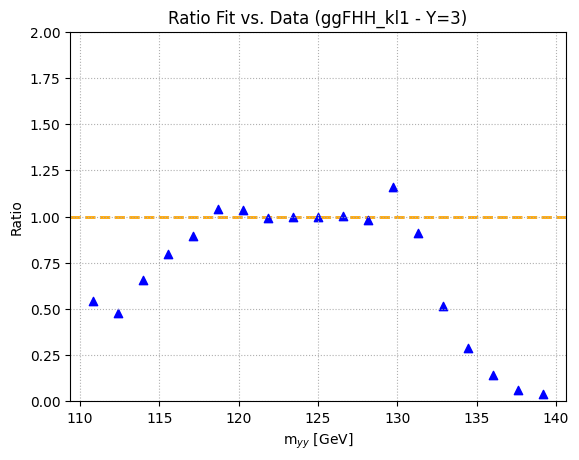

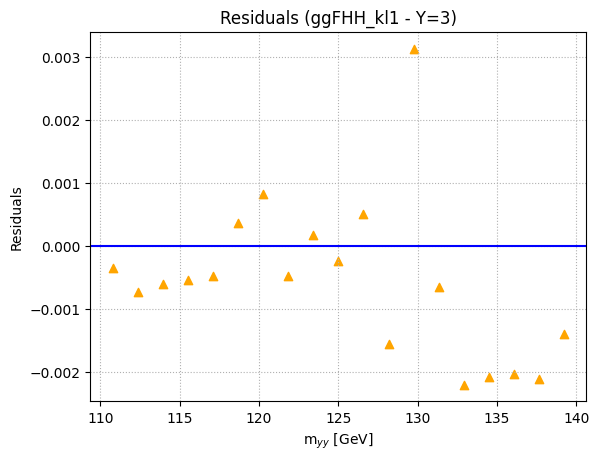

In [97]:
plt.ylim(0,2)

plot_ratio_red(myy_bin_centers, ggFHH_kl1_myy_ratio, ggFHH_kl1_myy_residuals, r'ggFHH_kl1 - Y=3', 'myy')

---
---

## ggFHH_kl10

In [98]:
ggFHH_kl10_mbb, ggFHH_kl10_myy, ggFHH_kl10_weights = read_data_sens('ggFHH_kl10',3)

### ggFHH_kl10 - m$_{b\bar{b}}$

In [99]:
#ggFHH_kl10_mbb_err = get_errors(ggFHH_kl10_mbb, ggFHH_kl10_weights, mbb_bins, mbb_bin_num)

<ErrorbarContainer object of 3 artists>

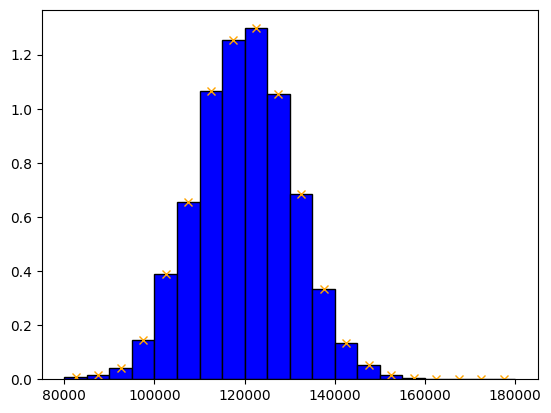

In [100]:
ggFHH_kl10_mbb_counts, ggFHH_kl10_mbb_bins, _ = plt.hist(ggFHH_kl10_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=ggFHH_kl10_weights)

ggFHH_kl10_mbb_err = get_poisson_errors(ggFHH_kl10_mbb_counts, ggFHH_kl10_weights)

plt.errorbar(mbb_bin_centers, ggFHH_kl10_mbb_counts, yerr=ggFHH_kl10_mbb_err, marker='x', color='orange', ls='')

In [101]:
ggFHH_kl10_mbb_popt, ggFHH_kl10_mbb_pcov = \
curve_fit(dscb_func, mbb_bin_centers, ggFHH_kl10_mbb_counts, p0=[120e3,10e3,1.5,1.5,23,23,1.3], \
          sigma=np.mean(ggFHH_kl10_mbb_err, axis=0), absolute_sigma=True)

ggFHH_kl10_mbb_ratio, ggFHH_kl10_mbb_residuals, ggFHH_kl10_mbb_chi_red, ggFHH_kl10_mbb_chi \
= fit_evaluation(dscb_func, mbb_bin_centers, ggFHH_kl10_mbb_counts, np.mean(ggFHH_kl10_mbb_err, axis=0), ggFHH_kl10_mbb_popt)

ggFHH_kl10_mbb_legend = get_legend(ggFHH_kl10_mbb_popt, ggFHH_kl10_mbb_pcov, ggFHH_kl10_mbb_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: overflow encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in multiply
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: invalid value encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/2443743946.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = 

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


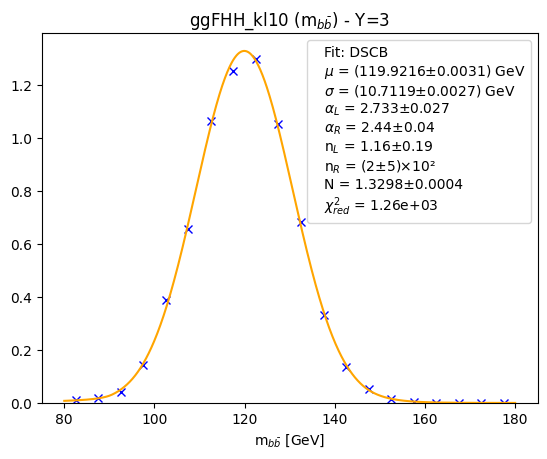

In [102]:
plt.title(r'ggFHH_kl10 (m$_{b\bar{b}}$) - Y=3')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, dscb_func(mbb_plot,*ggFHH_kl10_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ggFHH_kl10_mbb_legend)

plt.errorbar(mbb_bin_centers, ggFHH_kl10_mbb_counts, yerr=ggFHH_kl10_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ggFHH_kl10_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=ggFHH_kl10_weights)

_=plt.legend(handlelength=0)

#plt.savefig('./Plots/Y0-mbb/ggFHH_kl10_mbb_Y0.pdf', format='pdf')

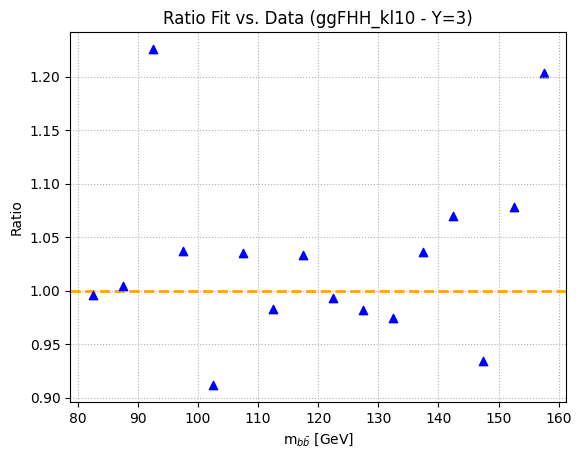

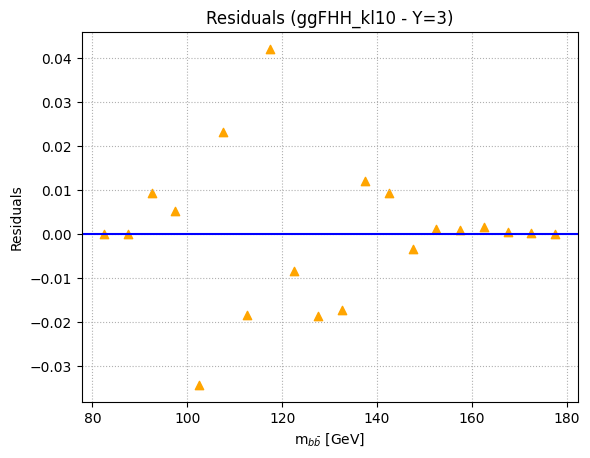

In [103]:
plot_ratio_red(mbb_bin_centers, ggFHH_kl10_mbb_ratio, ggFHH_kl10_mbb_residuals, r'ggFHH_kl10 - Y=3', 'mbb')

---
---

### ggFHH_kl10 - m$_{\gamma\gamma}$

In [104]:
ggFHH_kl10_myy *= 1e3

<ErrorbarContainer object of 3 artists>

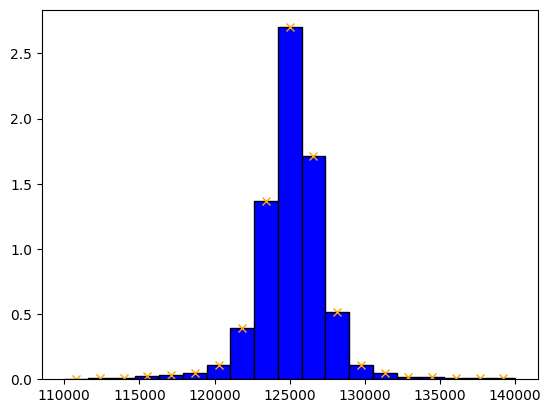

In [105]:
ggFHH_kl10_myy_counts, ggFHH_kl10_myy_bins, _ = plt.hist(ggFHH_kl10_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=ggFHH_kl10_weights)

ggFHH_kl10_myy_err = get_poisson_errors(ggFHH_kl10_myy_counts, ggFHH_kl10_weights)

plt.errorbar(myy_bin_centers, ggFHH_kl10_myy_counts, yerr=ggFHH_kl10_myy_err, marker='x', color='orange', ls='')

In [106]:
ggFHH_kl10_myy_popt, ggFHH_kl10_myy_pcov = curve_fit(dscb_func, myy_bin_centers, ggFHH_kl10_myy_counts, p0=[125e3, 2.5e3, 1.64, 1.64612321e+00, \
       1.3, 13, 2.5], sigma=np.mean(ggFHH_kl10_myy_err, axis=0), absolute_sigma=True)

ggFHH_kl10_myy_ratio, ggFHH_kl10_myy_residuals, ggFHH_kl10_myy_chi_red, ggFHH_kl10_myy_chi \
= fit_evaluation(dscb_func, myy_bin_centers, ggFHH_kl10_myy_counts, np.mean(ggFHH_kl10_myy_err, axis=0), ggFHH_kl10_myy_popt)

ggFHH_kl10_myy_legend = get_legend(ggFHH_kl10_myy_popt, ggFHH_kl10_myy_pcov, ggFHH_kl10_myy_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: overflow encountered in scalar multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


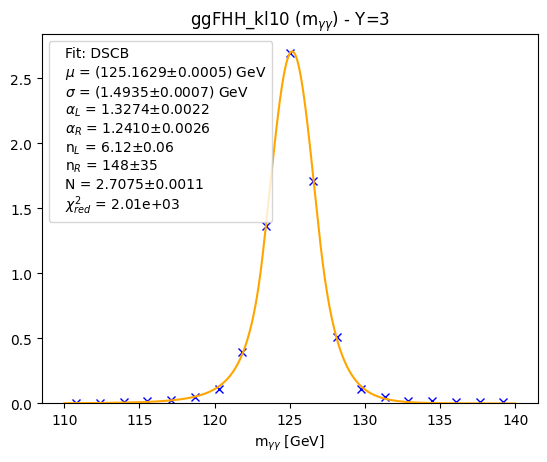

In [107]:
plt.title(r'ggFHH_kl10 (m$_{\gamma\gamma}$) - Y=3')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))

plt.plot(myy_plot, dscb_func(myy_plot,*ggFHH_kl10_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ggFHH_kl10_myy_legend)

plt.errorbar(myy_bin_centers, ggFHH_kl10_myy_counts, yerr=ggFHH_kl10_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ggFHH_kl10_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=ggFHH_kl10_weights)

_=plt.legend(handlelength=0)

#plt.savefig('./Plots/Y0-myy/ggFHH_kl10_myy_Y0.pdf', format='pdf')

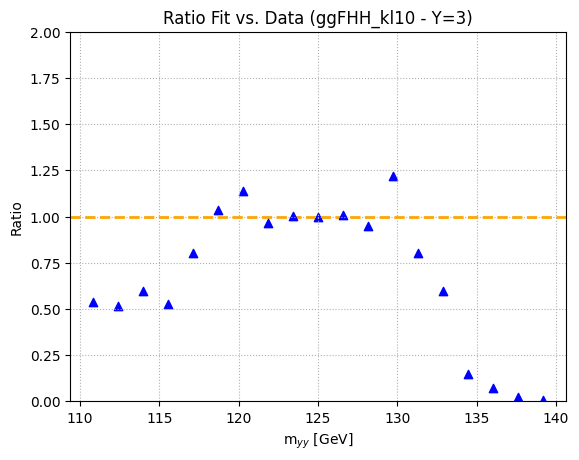

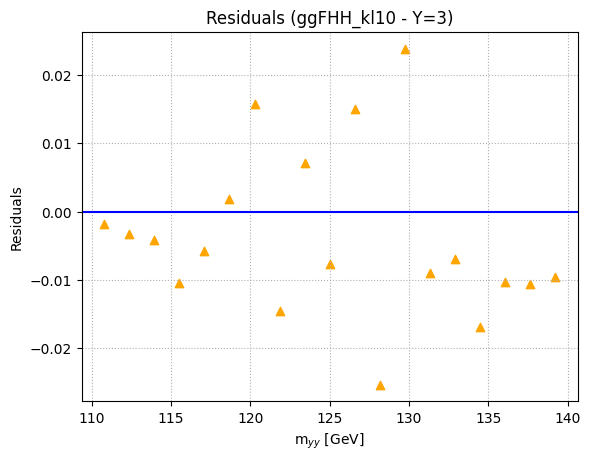

In [108]:
plt.ylim(0,2)

plot_ratio_red(myy_bin_centers, ggFHH_kl10_myy_ratio, ggFHH_kl10_myy_residuals, r'ggFHH_kl10 - Y=3', 'myy')

---
---

## All Signals Combined

In [109]:
#scale up factors
n_mbb = 50

n_myy = 50

#signal
signal_mbb = np.concatenate([ggFH_mbb, ttH_mbb, qqZH_mbb, yybb_mbb, VBFHH_mbb, ggFHH_kl1_mbb])

signal_myy = np.concatenate([ggFH_myy, ttH_myy, qqZH_myy, yybb_myy, VBFHH_mbb, ggFHH_kl1_myy])

signal_weights = np.concatenate([ggFH_weights, ttH_weights, qqZH_weights, yybb_weights, VBFHH_weights, ggFHH_kl1_weights])

#scale up the HH samples
signal_mbb_mod = np.concatenate([ggFH_mbb, ttH_mbb, qqZH_mbb, yybb_mbb, np.tile(VBFHH_mbb, n_mbb), np.tile(ggFHH_kl1_mbb, n_mbb)])

signal_myy_mod = np.concatenate([ggFH_myy, ttH_myy, qqZH_myy, yybb_myy, np.tile(VBFHH_myy, n_myy), np.tile(ggFHH_kl1_myy, n_myy)])

signal_mod_weights = np.concatenate([ggFH_weights, ttH_weights, qqZH_weights, yybb_weights, np.tile(VBFHH_weights, n_mbb), np.tile(ggFHH_kl1_weights, n_mbb)])

#background
bkg_mbb = np.concatenate([ggFH_mbb, ttH_mbb, qqZH_mbb, yybb_mbb])

bkg_myy = np.concatenate([ggFH_myy, ttH_myy, qqZH_myy, yybb_myy])

bkg_weights = np.concatenate([ggFH_weights, ttH_weights, qqZH_weights, yybb_weights])

In [110]:
signal_mbb.size, signal_myy.size, yybb_mbb.size, ggFHH_kl10_mbb.size

(415932, 415932, 21751, 11263)

### Functions

In [111]:
aaa = [0,1,2,3,4,5,6,7,8,9]

aaa[2:3]

[2]

In [112]:
def signal_func_mbb(x, N1, N2):
    return N1 * dscb_func(x, *VBFHH_mbb_popt) + gauss_func(x, *ggFH_mbb_popt) + dscb_func(x, *ttH_mbb_popt) +\
            cb_func(x, *qqZH_mbb_popt) + N2 * cb_func(x, *yybb_mbb_popt) + N1 * dscb_func(x, *ggFHH_kl1_mbb_popt)

signal_labels = [r'$\mu$', r'$\mu_b$']
signal_units = ['', '']

In [113]:
def bkg_func_mbb(x, N):
    return gauss_func(x, *ggFH_mbb_popt) + dscb_func(x, *ttH_mbb_popt) +\
            cb_func(x, *qqZH_mbb_popt) + N * cb_func(x, *yybb_mbb_popt)

bkg_labels = [r'$\mu_b$']
bkg_units = ['']

In [114]:
def signal_func_myy(x, N1, N2, l):
    return N1 * dscb_func(x, *VBFHH_myy_popt) + dscb_func(x, *ggFH_myy_popt) + dscb_func(x, *ttH_myy_popt) +\
            dscb_func(x, *qqZH_myy_popt) + N2 * exp_fit(x, yybb_myy_popt[0], l) + N1 * dscb_func(x, *ggFHH_kl1_myy_popt)

signal_myy_labels = [r'$\mu$', r'$\mu_b$', r'$\lambda$']
signal_myy_units = ['', '', r'GeV$^{-1}$']

In [115]:
def signal_func_myy2(x, N1, N2):
    return N1 * dscb_func(x, *VBFHH_myy_popt) + dscb_func(x, *ggFH_myy_popt) + dscb_func(x, *ttH_myy_popt) +\
            dscb_func(x, *qqZH_myy_popt) + N2 * exp_fit(x, *yybb_myy_popt) + N1 * dscb_func(x, *ggFHH_kl1_myy_popt)

signal_myy_labels2 = [r'$\mu$', r'$\mu_b$']
signal_myy_units2 = ['', '']

In [116]:
def bkg_func_myy(x, N, l):
    return dscb_func(x, *ggFH_myy_popt) + dscb_func(x, *ttH_myy_popt) +\
            dscb_func(x, *qqZH_myy_popt) + N * exp_fit(x, yybb_myy_popt[0], l)

bkg_myy_labels = [r'$\mu_b$', r'$\lambda$']
bkg_myy_units = ['', r'GeV$^{-1}$']

In [117]:
def bkg_func_myy2(x, N):
    return dscb_func(x, *ggFH_myy_popt) + dscb_func(x, *ttH_myy_popt) +\
            dscb_func(x, *qqZH_myy_popt) + N * exp_fit(x, *yybb_myy_popt)

bkg_myy_labels2 = [r'$\mu_b$']
bkg_myy_units2 = ['']

In [118]:
import scipy.stats as st

def poisson_error(x):
    high_err = st.chi2.ppf(1. - (1. - 0.68)/2. , 2.* (x + 1.)) / 2. - x - 1
    
    low_err = np.where(
                        x <= 0,
                        0,
                        x - st.chi2.ppf((1. - 0.68)/2., 2.*x) / 2
                        )
    
    return [low_err, high_err]

In [119]:
poisson_error(0)

[array(0.), 0.8325814637483107]

### m$_{b\bar{b}}$

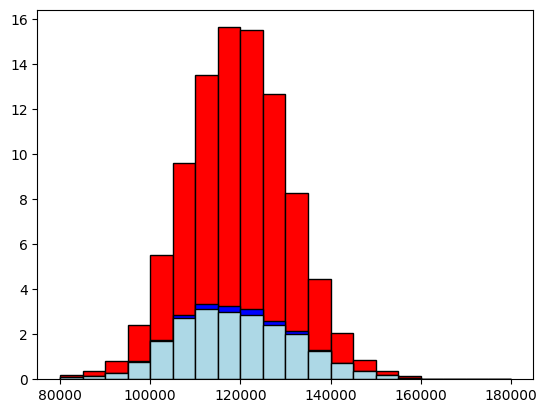

In [120]:
signal_mod_mbb_counts, signal_mod_mbb_bins, _ = plt.hist(signal_mbb_mod, bins=mbb_bins, range=mbb_range, color='red',\
                                    edgecolor='black', weights=signal_mod_weights)

signal_mbb_counts, signal_mbb_bins, _ = plt.hist(signal_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=signal_weights)

bkg_mbb_counts, bkg_mbb_bins, _ = plt.hist(bkg_mbb, bins=mbb_bins, range=mbb_range, color='lightblue',\
                                    edgecolor='black', weights=bkg_weights)

In [121]:
signal_mbb_err = poisson_error(signal_mbb_counts)

signal_mod_mbb_err = poisson_error(signal_mod_mbb_counts)

bkg_mbb_err = poisson_error(bkg_mbb_counts)

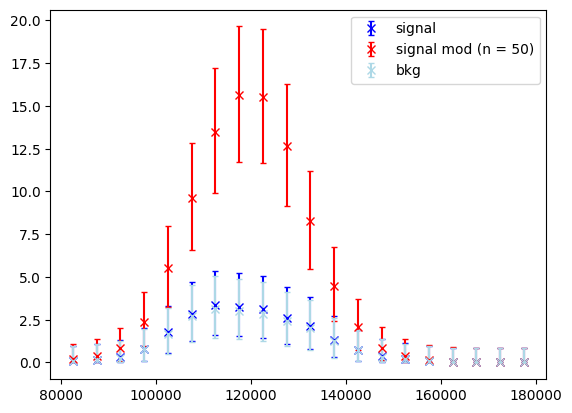

In [122]:
plt.errorbar(mbb_bin_centers, signal_mbb_counts, yerr=signal_mbb_err, marker='x', color='blue', ls='', label='signal', capsize=2)

plt.errorbar(mbb_bin_centers, signal_mod_mbb_counts, yerr=signal_mod_mbb_err, marker='x', color='red', ls='', label='signal mod (n = {})'.format(n_mbb), capsize=2)

plt.errorbar(mbb_bin_centers, bkg_mbb_counts, yerr=bkg_mbb_err, marker='x', color='lightblue', ls='', label='bkg', capsize=2)

_=plt.legend()

/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


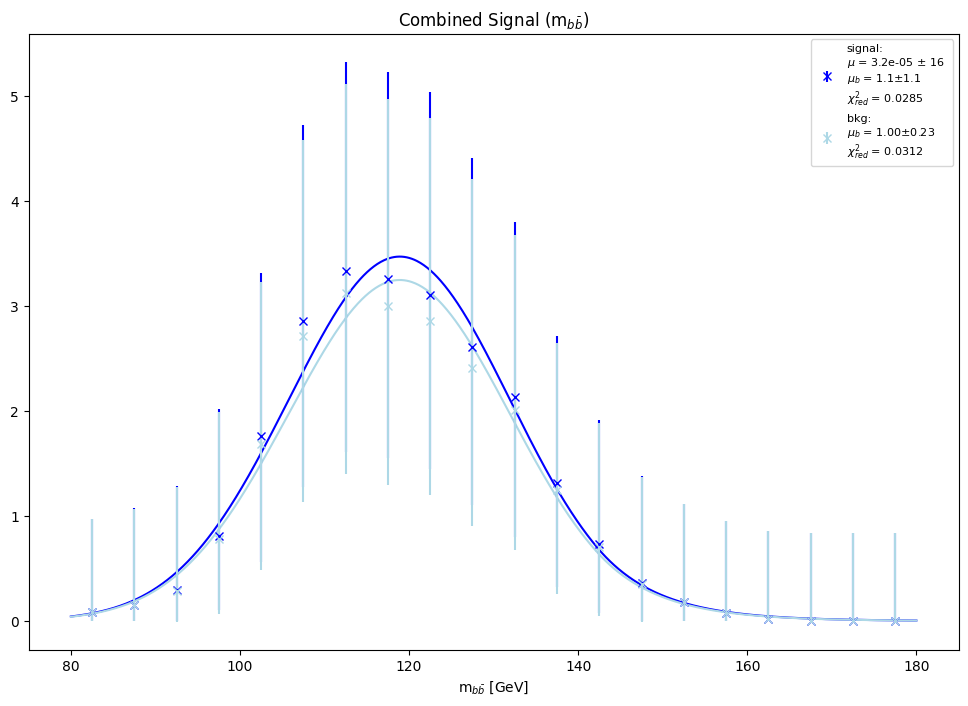

In [123]:
### signal
signal_bounds = [[0,0], [np.inf,np.inf]]

signal_mbb_popt, signal_mbb_pcov = curve_fit(signal_func_mbb, mbb_bin_centers, signal_mbb_counts, \
                                             p0=[1,1], \
                                             sigma=np.mean(signal_mbb_err,axis=0), absolute_sigma=True, \
                                            bounds = signal_bounds)

signal_mbb_ratio, signal_mbb_residuals, signal_mbb_chi_red, signal_mbb_chi \
= fit_evaluation(signal_func_mbb, mbb_bin_centers, signal_mbb_counts, np.mean(signal_mbb_err), signal_mbb_popt)

signal_mbb_legend = get_legend(signal_mbb_popt, signal_mbb_pcov, signal_mbb_chi_red, signal_labels, signal_units)

#modified signal
#signal_mod_mbb_popt, signal_mod_mbb_pcov = curve_fit(signal_func_mbb, mbb_bin_centers, signal_mod_mbb_counts, \
#                                                     p0=[n_mbb,1,yybb_mbb_popt[0],yybb_mbb_popt[1]], \
#                                                     sigma=np.mean(signal_mod_mbb_err,axis=0), absolute_sigma=True)

#signal_mod_mbb_ratio, signal_mod_mbb_residuals, signal_mod_mbb_chi_red, signal_mod_mbb_chi \
#= fit_evaluation(signal_func_mbb, mbb_bin_centers, signal_mod_mbb_counts, np.mean(signal_mod_mbb_err), signal_mod_mbb_popt)

#signal_mod_mbb_legend = get_legend(signal_mod_mbb_popt, signal_mod_mbb_pcov, signal_mod_mbb_chi_red, signal_labels, signal_units)

#background
bkg_mbb_popt, bkg_mbb_pcov = curve_fit(bkg_func_mbb, mbb_bin_centers, bkg_mbb_counts, \
                                       p0=[1], \
                                       sigma=np.mean(bkg_mbb_err,axis=0), absolute_sigma=True)

bkg_mbb_ratio, bkg_mbb_residuals, bkg_mbb_chi_red, bkg_mbb_chi \
= fit_evaluation(bkg_func_mbb, mbb_bin_centers, bkg_mbb_counts, np.mean(bkg_mbb_err), bkg_mbb_popt)

bkg_mbb_legend = get_legend(bkg_mbb_popt, bkg_mbb_pcov, bkg_mbb_chi_red, bkg_labels, bkg_units)

#plot the results
plt.figure(figsize=(12,8))

plt.title(r'Combined Signal (m$_{b\bar{b}}$)')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

plt.plot(mbb_plot, signal_func_mbb(mbb_plot, *signal_mbb_popt), color='blue')

#plt.plot(mbb_plot, signal_func_mbb(mbb_plot, *signal_mod_mbb_popt), color='red')

plt.plot(mbb_plot, bkg_func_mbb(mbb_plot, *bkg_mbb_popt), color='lightblue')

plt.errorbar(mbb_bin_centers, signal_mbb_counts, yerr=signal_mbb_err, marker='x', color='blue', ls='', label='signal:\n'+signal_mbb_legend)

#plt.errorbar(mbb_bin_centers, signal_mod_mbb_counts, yerr=signal_mbb_err, marker='x', color='red', ls='', label='signal mod (n = {}):\n'.format(n_mbb)+signal_mod_mbb_legend)

plt.errorbar(mbb_bin_centers, bkg_mbb_counts, yerr=signal_mbb_err, marker='x', color='lightblue', ls='', label='bkg:\n'+bkg_mbb_legend)

_=plt.legend(fontsize=8)

/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


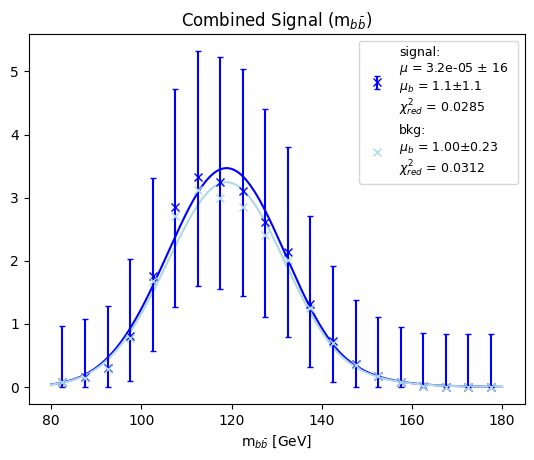

In [124]:
plt.title(r'Combined Signal (m$_{b\bar{b}}$)')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

plt.plot(mbb_plot, signal_func_mbb(mbb_plot, *signal_mbb_popt), color='blue')

plt.plot(mbb_plot, bkg_func_mbb(mbb_plot, *bkg_mbb_popt), color='lightblue')

plt.errorbar(mbb_bin_centers, signal_mbb_counts, yerr=signal_mbb_err, marker='x', color='blue', ls='',\
             label='signal:\n'+signal_mbb_legend, capsize=2)

plt.errorbar(mbb_bin_centers, bkg_mbb_counts, marker='x', color='lightblue', ls='', label='bkg:\n'+bkg_mbb_legend)

plt.legend(fontsize=9)

#plt.savefig('./Plots/combined_signals/Y0_mbb.pdf', format='pdf')

---

### m$_{\gamma\gamma}$

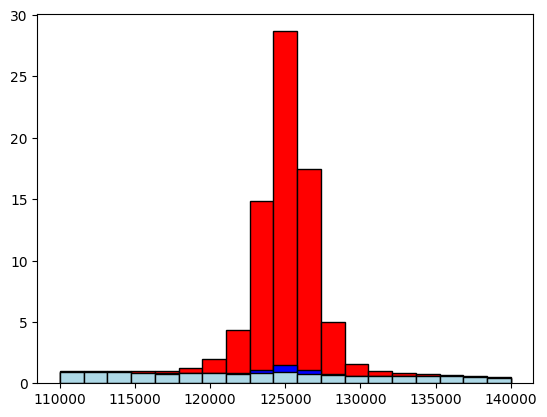

In [125]:
signal_mod_myy_counts, signal_mod_myy_bins, _ = plt.hist(signal_myy_mod, bins=myy_bins, range=myy_range, color='red',\
                                    edgecolor='black', weights=signal_mod_weights)

signal_myy_counts, signal_myy_bins, _ = plt.hist(signal_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=signal_weights)

bkg_myy_counts, bkg_myy_bins, _ = plt.hist(bkg_myy, bins=myy_bins, range=myy_range, color='lightblue',\
                                    edgecolor='black', weights=bkg_weights)

In [126]:
signal_myy_err = poisson_error(signal_myy_counts)

signal_mod_myy_err = poisson_error(signal_mod_myy_counts)

bkg_myy_err = poisson_error(bkg_myy_counts)

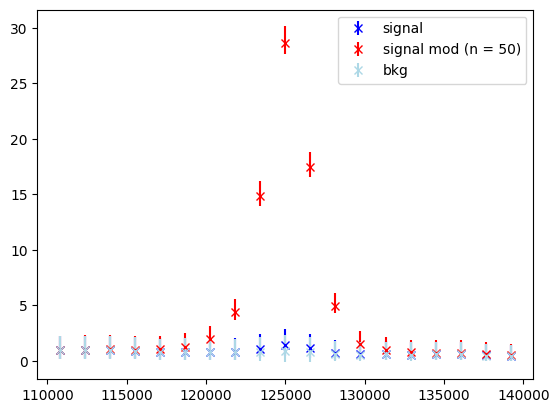

In [127]:
plt.errorbar(myy_bin_centers, signal_myy_counts, yerr=signal_myy_err, marker='x', color='blue', ls='', label='signal')

plt.errorbar(myy_bin_centers, signal_mod_myy_counts, yerr=signal_myy_err, marker='x', color='red', ls='', label='signal mod (n = {})'.format(n_mbb))

plt.errorbar(myy_bin_centers, bkg_myy_counts, yerr=signal_myy_err, marker='x', color='lightblue', ls='', label='bkg')

_=plt.legend()

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


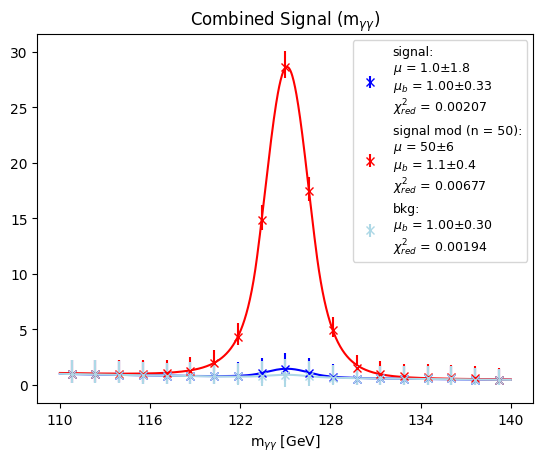

In [128]:
#signal
signal_myy_popt, signal_myy_pcov = curve_fit(signal_func_myy2, myy_bin_centers, signal_myy_counts,\
                                             sigma = np.mean(signal_myy_err, axis=0), p0=[1,1], absolute_sigma=True)

signal_myy_ratio, signal_myy_residuals, signal_myy_chi_red, signal_myy_chi \
= fit_evaluation(signal_func_myy2, myy_bin_centers, signal_myy_counts, np.mean(signal_myy_err, axis=0), signal_myy_popt)

signal_myy_legend = get_legend(signal_myy_popt, signal_myy_pcov, signal_myy_chi_red, signal_myy_labels2, signal_myy_units2)

#modified signal
signal_mod_myy_popt, signal_mod_myy_pcov = curve_fit(signal_func_myy2, myy_bin_centers, signal_mod_myy_counts,\
                                                     sigma = np.mean(signal_mod_myy_err, axis=0), p0=[n_mbb,1], absolute_sigma=True)

signal_mod_myy_ratio, signal_mod_myy_residuals, signal_mod_myy_chi_red, signal_mod_myy_chi \
= fit_evaluation(signal_func_myy2, myy_bin_centers, signal_mod_myy_counts, np.mean(signal_mod_myy_err, axis=0), signal_mod_myy_popt)

signal_mod_myy_legend = get_legend(signal_mod_myy_popt, signal_mod_myy_pcov, signal_mod_myy_chi_red, signal_myy_labels2, signal_myy_units2)

#background
bkg_myy_popt, bkg_myy_pcov = curve_fit(bkg_func_myy2, myy_bin_centers, bkg_myy_counts, sigma = np.mean(bkg_myy_err, axis=0), p0=[1], absolute_sigma=True)

bkg_myy_ratio, bkg_myy_residuals, bkg_myy_chi_red, bkg_myy_chi \
= fit_evaluation(bkg_func_myy2, myy_bin_centers, bkg_myy_counts, np.mean(bkg_myy_err, axis=0), bkg_myy_popt)

bkg_myy_legend = get_legend(bkg_myy_popt, bkg_myy_pcov, bkg_myy_chi_red, bkg_myy_labels2, bkg_myy_units2)

#plot the results
#plt.figure(figsize=(10,4))
#from scipy.interpolate import interp1d
#f = interp1d(mbb_bin_centers, , kind='cubic')
#x_smooth = np.linspace(x.min(), x.max(), 300)
#y_smooth = f(myy_bin_centers)

plt.title(r'Combined Signal (m$_{\gamma\gamma}$)')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,6),(np.linspace(myy_min,myy_max,6)/1e3).astype(int))

plt.plot(myy_plot, signal_func_myy2(myy_plot, *signal_myy_popt), color='blue')

plt.plot(myy_plot, signal_func_myy2(myy_plot, *signal_mod_myy_popt), color='red')

plt.plot(myy_plot, bkg_func_myy2(myy_plot, *bkg_myy_popt), color='lightblue')

plt.errorbar(myy_bin_centers, signal_myy_counts, yerr=signal_myy_err, marker='x', color='blue', ls='', label='signal:\n'+signal_myy_legend)

#plt.fill_between(myy_bin_centers, signal_myy_counts-signal_myy_err[0], signal_myy_counts+signal_myy_err[1], color='pink')

plt.errorbar(myy_bin_centers, signal_mod_myy_counts, yerr=signal_myy_err, marker='x', color='red', ls='', label='signal mod (n = {}):\n'.format(n_mbb)+signal_mod_myy_legend)

plt.errorbar(myy_bin_centers, bkg_myy_counts, yerr=signal_myy_err, marker='x', color='lightblue', ls='', label='bkg:\n'+bkg_myy_legend)

_=plt.legend(fontsize=9)

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


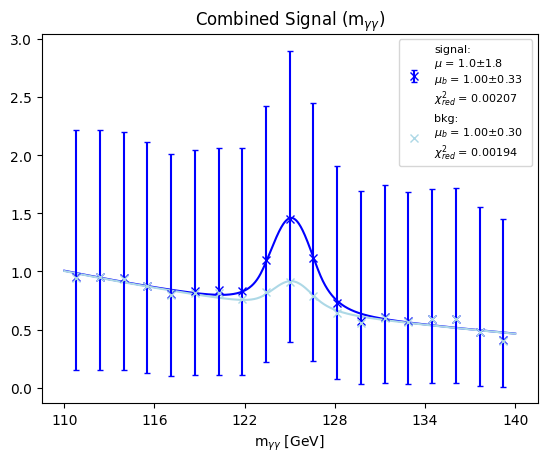

In [129]:
plt.title(r'Combined Signal (m$_{\gamma\gamma}$)')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,6),(np.linspace(myy_min,myy_max,6)/1e3).astype(int))

plt.plot(myy_plot, signal_func_myy2(myy_plot, *signal_myy_popt), color='blue')

plt.plot(myy_plot, bkg_func_myy2(myy_plot, *bkg_myy_popt), color='lightblue')

plt.errorbar(myy_bin_centers, signal_myy_counts, yerr=signal_myy_err, marker='x', color='blue', ls='',\
             label='signal:\n'+signal_myy_legend, capsize=2)

plt.errorbar(myy_bin_centers, bkg_myy_counts, marker='x', color='lightblue', ls='', label='bkg:\n'+bkg_myy_legend)

_=plt.legend(fontsize=8)

#plt.savefig('./Plots/combined_signals/Y0_myy.pdf', format='pdf')

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


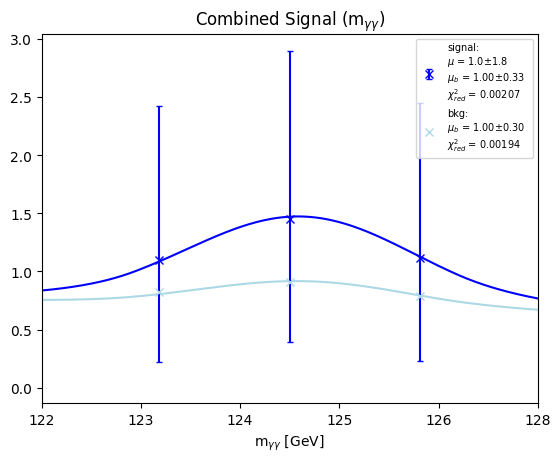

In [130]:
plt.title(r'Combined Signal (m$_{\gamma\gamma}$)')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xlim(122e3,128e3)

plt.xticks(np.linspace(122e3,128e3,6),(np.linspace(122e3,128e3,6)/1e3).astype(int))

plt.plot(myy_plot, signal_func_myy2(myy_plot, 1,1), color='blue')

plt.plot(myy_plot, bkg_func_myy2(myy_plot, *bkg_myy_popt), color='lightblue')

plt.errorbar(myy_bin_centers, signal_myy_counts, yerr=signal_myy_err, marker='x', color='blue', ls='',\
             label='signal:\n'+signal_myy_legend, capsize=2)

plt.errorbar(myy_bin_centers, bkg_myy_counts, marker='x', color='lightblue', ls='', label='bkg:\n'+bkg_myy_legend)

_=plt.legend(fontsize=7)

#plt.savefig('./Plots/combined_signals/Y0_myy_zoom.pdf', format='pdf')

In [131]:
VBFHH_mbb.size, ggFH_mbb.size, ttH_mbb.size, qqZH_mbb.size, yybb_mbb.size, ggFHH_kl1_mbb.size

(184078, 403, 3537, 3529, 21751, 202634)

## Save Results

In [132]:
popt_mbb_arrays = np.array([VBFHH_mbb_popt, ggFH_mbb_popt, ttH_mbb_popt, qqZH_mbb_popt, yybb_mbb_popt, ggFHH_kl1_mbb_popt, ggFHH_kl10_mbb_popt], dtype=object)

pcov_mbb_arrays = np.array([VBFHH_mbb_pcov, ggFH_mbb_pcov, ttH_mbb_pcov, qqZH_mbb_pcov, yybb_mbb_pcov, ggFHH_kl1_mbb_pcov, ggFHH_kl10_mbb_pcov], dtype=object)

popt_myy_arrays = np.array([VBFHH_myy_popt, ggFH_myy_popt, ttH_myy_popt, qqZH_myy_popt, yybb_myy_popt, ggFHH_kl1_myy_popt, ggFHH_kl10_myy_popt], dtype=object)

pcov_myy_arrays = np.array([VBFHH_myy_pcov, ggFH_myy_pcov, ttH_myy_pcov, qqZH_myy_pcov, yybb_myy_pcov, ggFHH_kl1_myy_pcov, ggFHH_kl10_myy_pcov], dtype=object)

In [133]:
np.savez('HM-SampleArrays/HM-Y=3/Y=3-new_nominal-20-19-Templates.npz', popt_mbb=popt_mbb_arrays, pcov_mbb=pcov_mbb_arrays, popt_myy=popt_myy_arrays, pcov_myy=pcov_myy_arrays)

In [134]:
popt_mbb_signals = np.array([signal_mbb_popt, bkg_mbb_popt], dtype=object)

pcov_mbb_signals = np.array([signal_mbb_pcov, bkg_mbb_pcov], dtype=object)

popt_myy_signals = np.array([signal_myy_popt, signal_mod_myy_popt, bkg_myy_popt], dtype=object)

pcov_myy_signals = np.array([signal_myy_pcov, signal_mod_myy_pcov, bkg_myy_pcov], dtype=object)

In [135]:
np.savez('HM-SampleArrays/HM-Y=3/Y=3-new_nominal-20-19-Signal.npz', popt_mbb=popt_mbb_signals, pcov_mbb=pcov_mbb_signals, popt_myy=popt_myy_signals, pcov_myy=pcov_myy_signals)

## 2D Fit

### VBFHH

In [136]:
def VBFHH_2d(myy, mbb):
    return dscb_func(myy, *VBFHH_myy_popt) * dscb_func(mbb, *VBFHH_mbb_popt)

In [137]:
VBFHH_hist2d, VBFHH_hist2d_xedges, VBFHH_hist2d_yedges = \
np.histogram2d(VBFHH_myy, VBFHH_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=VBFHH_weights)

In [138]:
VBFHH_2d_int_hist = np.sum(VBFHH_hist2d) * 30000/19 * 5000

VBFHH_2d_int_hist

329767.5883909664

In [139]:
from scipy import integrate

# Calculate the double integral
VBFHH_2d_int, VBFHH_abserr = integrate.dblquad(VBFHH_2d, mbb_min, mbb_max, myy_min, myy_max)

VBFHH_2d_int

/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in scalar power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in scalar power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


13774.055267631513

In [140]:
VBFHH_2d_N = VBFHH_2d_int_hist/VBFHH_2d_int

VBFHH_2d_N

23.94121280795985

In [141]:
xedges = VBFHH_hist2d_xedges
yedges = VBFHH_hist2d_yedges

xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

# Size of bars
dx = dy = (xedges[1] - xedges[0]) * np.ones_like(zpos)

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


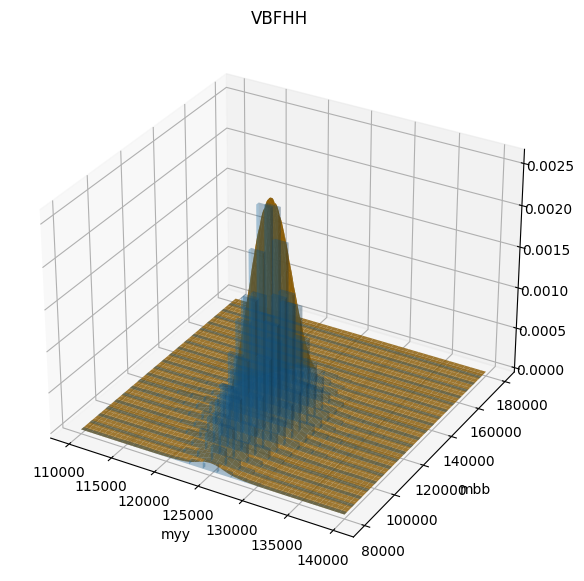

In [142]:
dz = VBFHH_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',alpha=0.2)

MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000), indexing='ij')

ax.plot_surface(MYY, MBB, VBFHH_2d(MYY,MBB) * VBFHH_2d_N, alpha=0.8, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('VBFHH')

plt.show()

### ggFH

In [143]:
def ggFH_2d(myy, mbb):
    return dscb_func(myy, *ggFH_myy_popt) * gauss_func(mbb, *ggFH_mbb_popt)

In [144]:
ggFH_hist2d, ggFH_hist2d_xedges, ggFH_hist2d_yedges = \
np.histogram2d(ggFH_myy, ggFH_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=ggFH_weights)

In [145]:
ggFH_2d_int_hist = np.sum(ggFH_hist2d) * 30000/19 * 5000

ggFH_2d_int_hist

1846360.686328081

In [146]:
from scipy import integrate

# Calculate the double integral
ggFH_2d_int, ggFH_abserr = integrate.dblquad(ggFH_2d, mbb_min, mbb_max, myy_min, myy_max)

ggFH_2d_int

443106.2434712767

In [147]:
ggFH_2d_N = ggFH_2d_int_hist/ggFH_2d_int

ggFH_2d_N

4.166857753715598

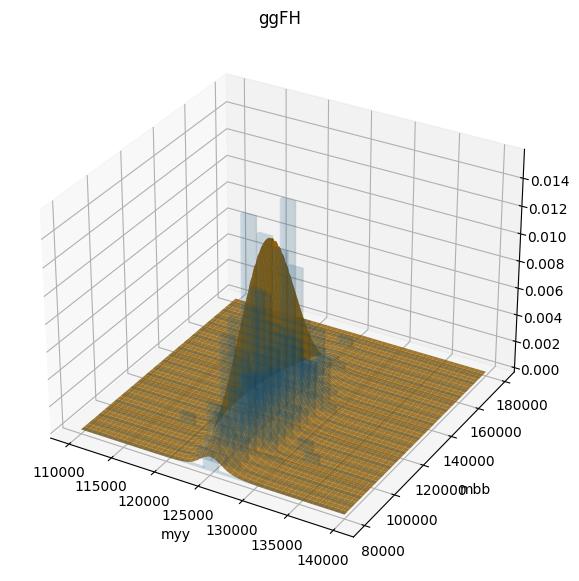

In [148]:
ggFH_dz = ggFH_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, ggFH_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

ax.plot_surface(MYY, MBB, ggFH_2d(MYY,MBB) * ggFH_2d_N, alpha=0.8, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('ggFH')

plt.show()

### ttH

In [149]:
def ttH_2d(myy, mbb):
    return dscb_func(myy, *ttH_myy_popt) * dscb_func(mbb, *ttH_mbb_popt)

In [150]:
ttH_hist2d, ttH_hist2d_xedges, ttH_hist2d_yedges = \
np.histogram2d(ttH_myy, ttH_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=ttH_weights)

In [151]:
ttH_2d_int_hist = np.sum(ttH_hist2d) * 30000/19 * 5000

ttH_2d_int_hist

843969.2603698908

In [152]:
from scipy import integrate

# Calculate the double integral
ttH_2d_int, ttH_abserr = integrate.dblquad(ttH_2d, mbb_min, mbb_max, myy_min, myy_max)

ttH_2d_int

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in scalar power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


93458.35704533146

In [153]:
ttH_2d_N = ttH_2d_int_hist/ttH_2d_int

ttH_2d_N

9.030431167974932

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


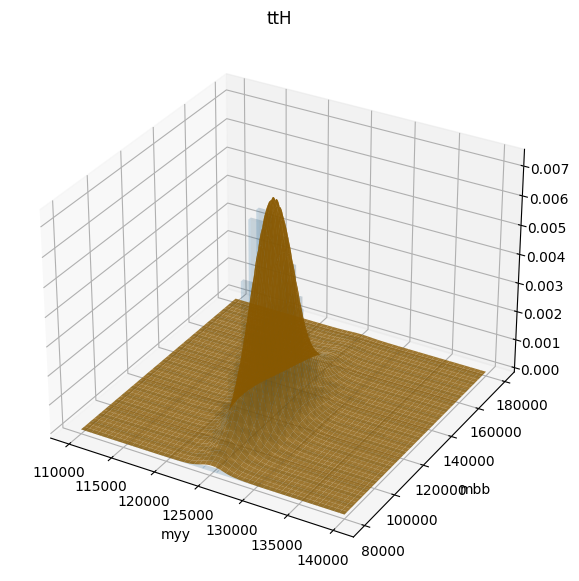

In [154]:
ttH_dz = ttH_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, ttH_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

ax.plot_surface(MYY, MBB, ttH_2d(MYY,MBB) * ttH_2d_N, alpha=0.8, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('ttH')

plt.show()

### qqZH

In [155]:
def qqZH_2d(myy, mbb):
    return dscb_func(myy, *qqZH_myy_popt) * cb_func(mbb, *qqZH_mbb_popt)

In [156]:
qqZH_hist2d, qqZH_hist2d_xedges, qqZH_hist2d_yedges = \
np.histogram2d(qqZH_myy, qqZH_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=qqZH_weights)

In [157]:
qqZH_2d_int_hist = np.sum(qqZH_hist2d) * 30000/19 * 5000

qqZH_2d_int_hist

1431731.1990424243

In [158]:
from scipy import integrate

# Calculate the double integral
qqZH_2d_int, qqZH_abserr = integrate.dblquad(qqZH_2d, mbb_min, mbb_max, myy_min, myy_max)

qqZH_2d_int

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in scalar power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


264270.6174004144

In [159]:
qqZH_2d_N = qqZH_2d_int_hist/qqZH_2d_int

qqZH_2d_N

5.417670769176397

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


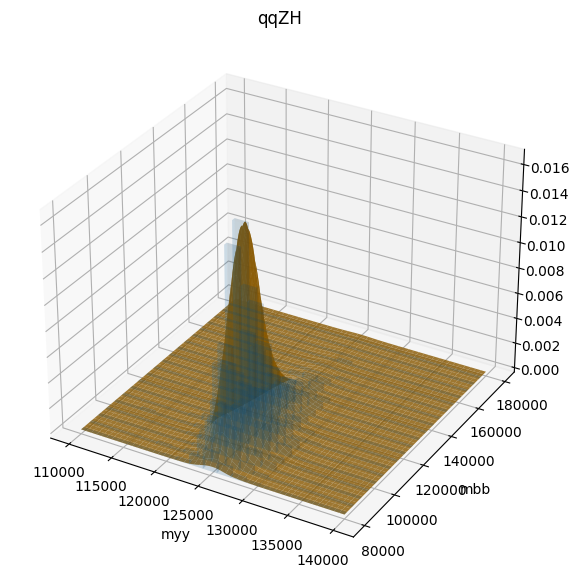

In [160]:
qqZH_dz = qqZH_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, qqZH_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

ax.plot_surface(MYY, MBB, qqZH_2d(MYY,MBB) * qqZH_2d_N, alpha=0.8, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('qqZH')

plt.show()

### yybb

In [161]:
def yybb_2d(myy, mbb):
    return exp_fit(myy, *yybb_myy_popt) * cb_func(mbb, *yybb_mbb_popt)

In [162]:
yybb_hist2d, yybb_hist2d_xedges, yybb_hist2d_yedges = \
np.histogram2d(yybb_myy, yybb_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=yybb_weights)

In [163]:
yybb_2d_int_hist = np.sum(yybb_hist2d) * 30000/19 * 5000

yybb_2d_int_hist

104704328.75067538

In [164]:
from scipy import integrate

# Calculate the double integral
yybb_2d_int, yybb_abserr = integrate.dblquad(yybb_2d, mbb_min, mbb_max, myy_min, myy_max)

yybb_2d_int

2196800726.0755854

In [165]:
yybb_2d_N = yybb_2d_int_hist/yybb_2d_int

yybb_2d_N

0.047662187793301385

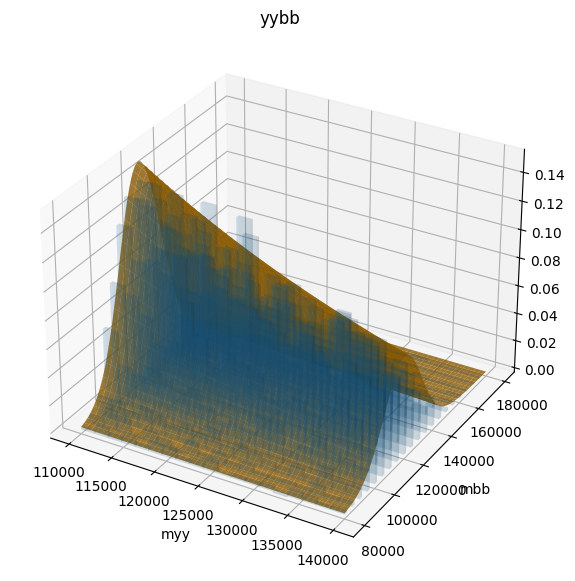

In [166]:
yybb_dz = yybb_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, yybb_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

ax.plot_surface(MYY, MBB, yybb_2d(MYY,MBB) * yybb_2d_N, alpha=0.8, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('yybb')

plt.show()

### ggFHH_kl1

In [167]:
def ggFHH_kl1_2d(myy, mbb):
    return dscb_func(myy, *ggFHH_kl1_myy_popt) * dscb_func(mbb, *ggFHH_kl1_mbb_popt)

In [168]:
ggFHH_kl1_hist2d, ggFHH_kl1_hist2d_xedges, ggFHH_kl1_hist2d_yedges = \
np.histogram2d(ggFHH_kl1_myy, ggFHH_kl1_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=ggFHH_kl1_weights)

In [169]:
ggFHH_kl1_2d_int_hist = np.sum(ggFHH_kl1_hist2d) * 30000/19 * 5000

ggFHH_kl1_2d_int_hist

10807576.20925952

In [170]:
from scipy import integrate

# Calculate the double integral
ggFHH_kl1_2d_int, ggFHH_kl1_abserr = integrate.dblquad(ggFHH_kl1_2d, mbb_min, mbb_max, myy_min, myy_max)

ggFHH_kl1_2d_int

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in scalar power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in scalar power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


14712807.527317634

In [171]:
ggFHH_kl1_2d_N = ggFHH_kl1_2d_int_hist/ggFHH_kl1_2d_int

ggFHH_kl1_2d_N

0.7345692648526003

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


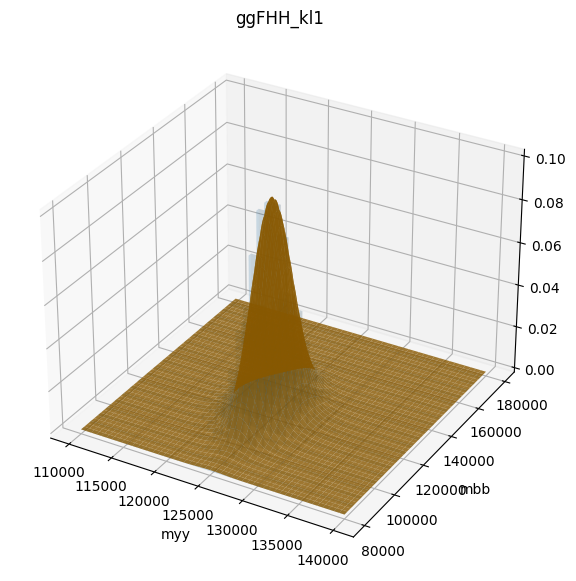

In [172]:
ggFHH_kl1_dz = ggFHH_kl1_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, ggFHH_kl1_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

ax.plot_surface(MYY, MBB, ggFHH_kl1_2d(MYY,MBB) * ggFHH_kl1_2d_N, alpha=0.8, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('ggFHH_kl1')

plt.show()

### All Signals Combined

In [173]:
def signal_2d(myymbb, N1, N2):
    myy, mbb = myymbb
    return N1 * VBFHH_2d_N * dscb_func(mbb, *VBFHH_mbb_popt) * dscb_func(myy, *VBFHH_myy_popt) \
            + ggFH_2d_N * gauss_func(mbb, *ggFH_mbb_popt) * dscb_func(myy, *ggFH_myy_popt) \
                + ttH_2d_N * dscb_func(mbb, *ttH_mbb_popt) * dscb_func(myy, *ttH_myy_popt) \
                    + qqZH_2d_N * cb_func(mbb, *qqZH_mbb_popt) * dscb_func(myy, *qqZH_myy_popt) \
                        + N2 * yybb_2d_N * cb_func(mbb, *yybb_mbb_popt) * exp_fit(myy, *yybb_myy_popt) \
                            + N1 * ggFHH_kl1_2d_N * dscb_func(mbb, *ggFHH_kl1_mbb_popt) * dscb_func(myy, *ggFHH_kl1_myy_popt)

signal_2d_labels = [r'$\mu$', r'$\mu_b$'] #, r'$\lambda_{\gamma\gamma}$'] #r'$\mu_{gauss}$', r'$\sigma_{gauss}$'
signal_2d_units = ['', '', r'GeV$^{-1}$'] #'GeV', 'GeV']

In [174]:
def signal_2d_2(myymbb, N1, N2, l):
    myy, mbb = myymbb
    return N1 * VBFHH_2d_N * dscb_func(mbb, *VBFHH_mbb_popt) * dscb_func(myy, *VBFHH_myy_popt) \
            + ggFH_2d_N * gauss_func(mbb, *ggFH_mbb_popt) * dscb_func(myy, *ggFH_myy_popt) \
                + ttH_2d_N * dscb_func(mbb, *ttH_mbb_popt) * dscb_func(myy, *ttH_myy_popt) \
                    + qqZH_2d_N * cb_func(mbb, *qqZH_mbb_popt) * dscb_func(myy, *qqZH_myy_popt) \
                        + N2 * yybb_2d_N * cb_func(mbb, *yybb_mbb_popt) * exp_fit(myy, yybb_myy_popt[0], l) \
                            + N1 * ggFHH_kl1_2d_N * dscb_func(mbb, *ggFHH_kl1_mbb_popt) * dscb_func(myy, *ggFHH_kl1_myy_popt)

signal_2d_labels2 = [r'$\mu$', r'$\mu_b$', r'$\lambda_{\gamma\gamma}$'] #r'$\mu_{gauss}$', r'$\sigma_{gauss}$'
signal_2d_units2 = ['', '', r'GeV$^{-1}$'] #'GeV', 'GeV']

In [175]:
signal_hist2d, signal_hist2d_xedges, signal_hist2d_yedges = \
np.histogram2d(signal_myy, signal_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=signal_weights)

signal_2d_err = poisson_error(signal_hist2d)

/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


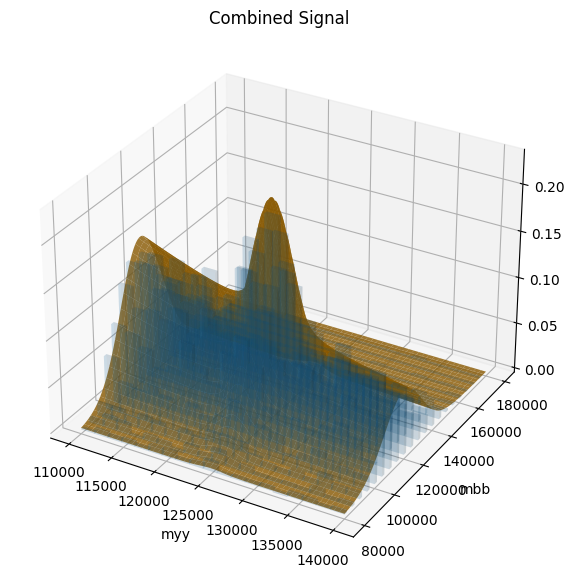

In [176]:
signal_dz = signal_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, signal_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

ax.plot_surface(MYY, MBB, signal_2d((MYY,MBB), 1, 1), alpha=0.8, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('Combined Signal')

plt.show()

In [177]:
def signal_2d_fit(myymbb, N1, N2):
    myy, mbb = myymbb
    value = N1 * VBFHH_2d_N * dscb_func(mbb, *VBFHH_mbb_popt) * dscb_func(myy, *VBFHH_myy_popt) \
            + ggFH_2d_N * double_gauss(mbb, *ggFH_mbb_popt) * dscb_func(myy, *ggFH_myy_popt) \
                + ttH_2d_N * dscb_func(mbb, *ttH_mbb_popt) * dscb_func(myy, *ttH_myy_popt) \
                    + qqZH_2d_N * cb_func(mbb, *qqZH_mbb_popt) * dscb_func(myy, *qqZH_myy_popt) \
                        + N2 * yybb_2d_N * cb_func(mbb, *yybb_mbb_popt) * exp_fit(myy, *yybb_myy_popt) \
                            + N1 * ggFHH_kl1_2d_N * dscb_func(mbb, *ggFHH_kl1_mbb_popt) * dscb_func(myy, *ggFHH_kl1_myy_popt)

    return value.ravel()

In [178]:
def signal_2d_fit(myymbb, N1, N2):
    myy, mbb = myymbb
    value = N1 * VBFHH_2d_N * dscb_func(mbb, *VBFHH_mbb_popt) * dscb_func(myy, *VBFHH_myy_popt) \
            + ggFH_2d_N * gauss_func(mbb, *ggFH_mbb_popt) * dscb_func(myy, *ggFH_myy_popt) \
                + ttH_2d_N * dscb_func(mbb, *ttH_mbb_popt) * dscb_func(myy, *ttH_myy_popt) \
                    + qqZH_2d_N * cb_func(mbb, *qqZH_mbb_popt) * dscb_func(myy, *qqZH_myy_popt) \
                        + N2 * yybb_2d_N * cb_func(mbb, *yybb_mbb_popt) * exp_fit(myy, *yybb_myy_popt) \
                            + N1 * ggFHH_kl1_2d_N * dscb_func(mbb, *ggFHH_kl1_mbb_popt) * dscb_func(myy, *ggFHH_kl1_myy_popt)

    return value.ravel()

In [179]:
def signal_2d_fit2(myymbb, N1, N2, l):
    myy, mbb = myymbb
    value = N1 * VBFHH_2d_N * dscb_func(mbb, *VBFHH_mbb_popt) * dscb_func(myy, *VBFHH_myy_popt) \
            + ggFH_2d_N * gauss_func(mbb, *ggFH_mbb_popt) * dscb_func(myy, *ggFH_myy_popt) \
                + ttH_2d_N * dscb_func(mbb, *ttH_mbb_popt) * dscb_func(myy, *ttH_myy_popt) \
                    + qqZH_2d_N * cb_func(mbb, *qqZH_mbb_popt) * dscb_func(myy, *qqZH_myy_popt) \
                        + N2 * yybb_2d_N * cb_func(mbb, *yybb_mbb_popt) * exp_fit(myy, yybb_myy_popt[0], l) \
                            + N1 * ggFHH_kl1_2d_N * dscb_func(mbb, *ggFHH_kl1_mbb_popt) * dscb_func(myy, *ggFHH_kl1_myy_popt)

    return value.ravel()

In [180]:
MYY_bin_centers, MBB_bin_centers = np.meshgrid(myy_bin_centers, mbb_bin_centers, indexing='ij')

signal_2d_popt, signal_2d_pcov = curve_fit(signal_2d_fit, (MYY_bin_centers,MBB_bin_centers), signal_hist2d.ravel(), \
                                           sigma=np.mean(signal_2d_err, axis=0).ravel(), p0=[1, 1], \
                                          absolute_sigma=True)

signal_2d_chi_red = np.sum( (signal_2d_fit((MYY_bin_centers,MBB_bin_centers),*signal_2d_popt)-signal_hist2d.ravel())**2 / np.mean(signal_2d_err, axis=0).ravel()**2 )

signal_2d_legend = get_legend(signal_2d_popt, signal_2d_pcov, signal_2d_chi_red, signal_2d_labels, signal_2d_units)

/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


In [181]:
signal_2d_popt2, signal_2d_pcov2 = curve_fit(signal_2d_fit2, (MYY_bin_centers,MBB_bin_centers), signal_hist2d.ravel(), \
                                           sigma=np.mean(signal_2d_err, axis=0).ravel(), p0=[1, 1, yybb_myy_popt[1]], \
                                          absolute_sigma=True)

signal_2d_chi_red2 = np.sum( (signal_2d_fit2((MYY_bin_centers,MBB_bin_centers),*signal_2d_popt2)-signal_hist2d.ravel())**2 / np.mean(signal_2d_err, axis=0).ravel()**2 )

signal_2d_legend2 = get_legend(signal_2d_popt2, signal_2d_pcov2, signal_2d_chi_red, signal_2d_labels2, signal_2d_units2)

/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


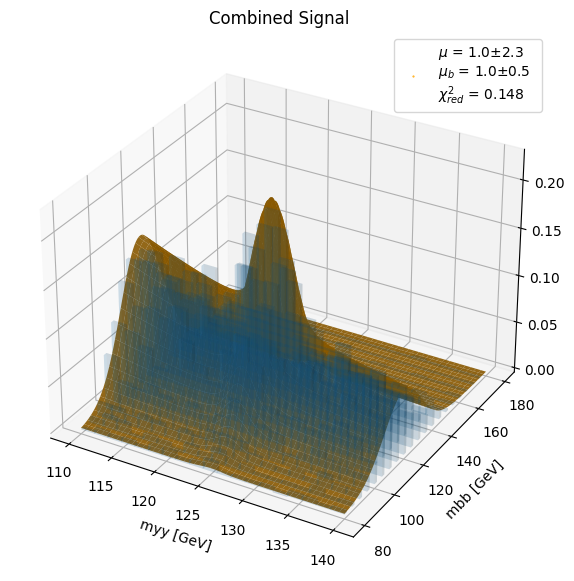

In [182]:
import matplotlib.lines as mlines

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))
ax.set_yticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

ax.bar3d(xpos, ypos, zpos, dx, dy, signal_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

surf = ax.plot_surface(MYY, MBB, signal_2d((MYY,MBB), *signal_2d_popt), alpha=0.9, color='orange')

ax.set_xlabel('myy [GeV]')
ax.set_ylabel('mbb [GeV]')
plt.title('Combined Signal')

proxy = mlines.Line2D([0],[0], color='orange', marker='.', linestyle='None', markersize=1, label=signal_2d_legend)
ax.legend(handles=[proxy])

plt.show()

#plt.savefig('./Plots/2D-plots/Y0_2d.pdf', format='pdf')

/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


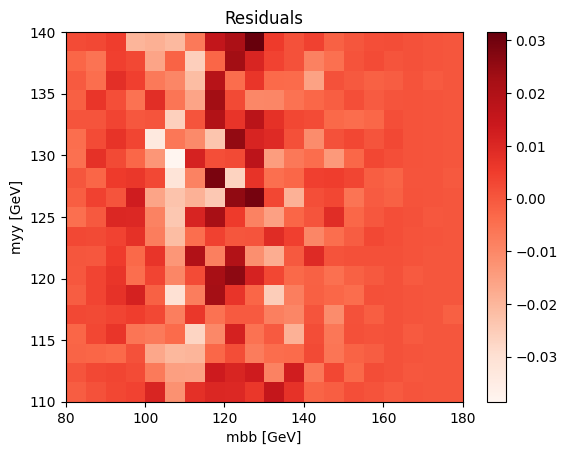

In [183]:
hist2d_diff = signal_2d((MYY_bin_centers,MBB_bin_centers), *signal_2d_popt) - signal_hist2d

#plt.figure(figsize=(10,2))

plt.title('Residuals')
plt.xlabel('mbb [GeV]')
plt.ylabel('myy [GeV]')

plt.imshow(hist2d_diff, cmap='Reds', extent=[80,180,110,140])

plt.gca().set_aspect('auto')

plt.colorbar()

In [184]:
np.savez('HM-SampleArrays/HM-Y=3/Y=3-2D-new_nominal-20-19-Signal.npz', popt=signal_2d_popt, pcov=signal_2d_pcov)

### Test with $\lambda_{\gamma\gamma}$ floating

/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


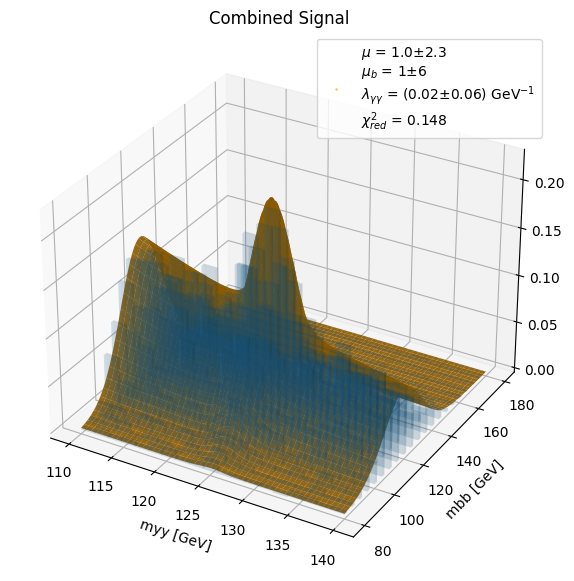

In [185]:
import matplotlib.lines as mlines

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))
ax.set_yticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

ax.bar3d(xpos, ypos, zpos, dx, dy, signal_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

surf = ax.plot_surface(MYY, MBB, signal_2d_2((MYY,MBB), *signal_2d_popt2), alpha=0.9, color='orange')

ax.set_xlabel('myy [GeV]')
ax.set_ylabel('mbb [GeV]')
plt.title('Combined Signal')

proxy = mlines.Line2D([0],[0], color='orange', marker='.', linestyle='None', markersize=1, label=signal_2d_legend2)
ax.legend(handles=[proxy])

plt.show()

#plt.savefig('./Plots/2D-plots/Y0_2d.pdf', format='pdf')

## 2D Templates

### VBFHH

In [186]:
def dscb_2d(myymbb, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2):
    myy, mbb = myymbb
    return dscb_func(myy, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1) * dscb_func(mbb, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2)

dscb_2d_labels = dscb_labels[:-1] + dscb_labels[:-1]
dscb_2d_units = 2 * dscb_units

In [187]:
def dscb_fit_2d(myymbb, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2):
    myy, mbb = myymbb
    
    value = dscb_func(myy, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1) * dscb_func(mbb, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2)

    return value.ravel()

In [188]:
def VBFHH_2dfit(myymbb, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2):
    myy, mbb = myymbb

    return VBFHH_2d_N * dscb_func(myy, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1) * dscb_func(mbb, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2)

VBFHH_2dfit_labels = [r'$\mu_{myy}$', r'$\sigma_{myy}$', r'$\alpha_{L,myy}$', r'$\alpha_{R,myy}$', r'n$_{L,myy}$', r'n$_{R,myy}$', 'N$_{myy}$', \
                     r'$\mu_{mbb}$', r'$\sigma_{mbb}$', r'$\alpha_{L,mbb}$', r'$\alpha_{R,mbb}$', r'n$_{L,mbb}$', r'n$_{R,mbb}$', 'N$_{mbb}$']
VBFHH_2dfit_units = ['GeV', 'GeV', ' ', ' ', ' ', ' ', ' ', 'GeV', 'GeV', ' ', ' ', ' ', ' ', ' ']

In [189]:
def VBFHH_fit_2dfit(myymbb, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2):
    myy, mbb = myymbb

    value = VBFHH_2d_N * dscb_func(myy, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1) * dscb_func(mbb, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2)

    return value.ravel()

In [190]:
VBFHH_2d_err = poisson_error(VBFHH_hist2d)

VBFHH_2d_bounds = [[1.249e5, 1.4e3, 1,   1,   7.5, 1.4e2, 5e-3,   1.17e5, 1.13e4, 1,   2.5, 1.4e2, 5.5,  7e-3], \
                   [1.255e5, 1.5e3, 1.5, 1.5, 8.2, 1.6e2, 5.5e-3, 1.19e5, 1.15e4, 1.2, 3.2, 1.5e2, 6.25, 8e-3]]

VBFHH_2d_popt, VBFHH_2d_pcov = curve_fit(VBFHH_fit_2dfit, (MYY_bin_centers,MBB_bin_centers), VBFHH_hist2d.ravel(), p0=[125e3, 2.5e3, 1.64, 1.64612321e+00, \
       1.3, 13, 0.005, 120000,12000,1.5,1.5,3,3,0.007], \
                                         sigma=np.mean(VBFHH_2d_err, axis=0).ravel(), absolute_sigma=True)

VBFHH_2d_chi_red = np.sum( (VBFHH_fit_2dfit((MYY_bin_centers,MBB_bin_centers),*VBFHH_2d_popt)-VBFHH_hist2d.ravel())**2 / np.mean(VBFHH_2d_err, axis=0).ravel()**2 )

VBFHH_2d_legend = get_legend(VBFHH_2d_popt, VBFHH_2d_pcov, VBFHH_2d_chi_red, VBFHH_2dfit_labels, VBFHH_2dfit_units)

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: overflow encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in multiply
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


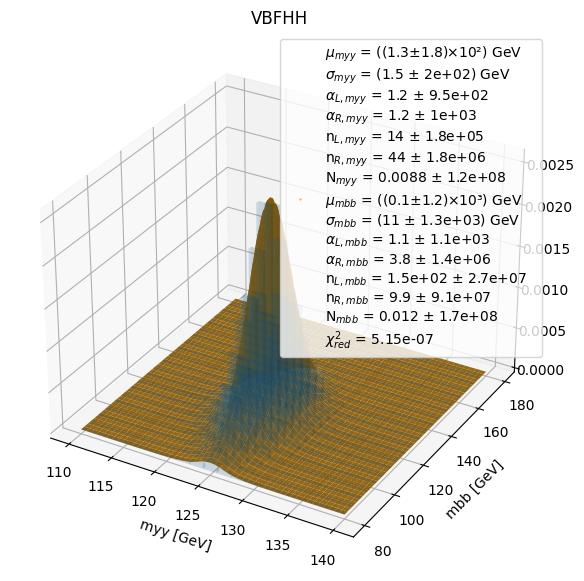

In [191]:
import matplotlib.lines as mlines

dz = VBFHH_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))
ax.set_yticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

surf = ax.plot_surface(MYY, MBB, VBFHH_2dfit((MYY,MBB), *VBFHH_2d_popt), alpha=0.9, color='orange')

ax.set_xlabel('myy [GeV]')
ax.set_ylabel('mbb [GeV]')
plt.title('VBFHH')

proxy = mlines.Line2D([0],[0], color='orange', marker='.', linestyle='None', markersize=1, label=VBFHH_2d_legend)
ax.legend(handles=[proxy])

plt.show()

#plt.savefig('./Plots/2D-plots/Y0_2d.pdf', format='pdf')

In [192]:
from tabulate import tabulate

tab_text = np.array(['mu_myy', 'sigma_myy', 'alpha_L_myy', 'alpha_R_myy', 'n_L_myy', 'n_R_myy', 'N_myy', \
                     'mu_mbb', 'sigma_mbb', 'alpha_L_mbb', 'alpha_R_mbb', 'n_L_mbb', 'n_R_mbb', 'N_mbb'])

VBFHH_2d_tab = np.array([tab_text, VBFHH_2d_popt, np.concatenate([VBFHH_myy_popt, VBFHH_mbb_popt]), \
                         np.sqrt(np.diag(VBFHH_2d_pcov)), np.concatenate([np.sqrt(np.diag(VBFHH_myy_pcov)), np.sqrt(np.diag(VBFHH_mbb_pcov))]) ])

print(tabulate(VBFHH_2d_tab.T, stralign='left', headers=['', '2d_values', '1d_values', '2d_uncertainties', '1d_uncertainties']))

                  2d_values        1d_values    2d_uncertainties    1d_uncertainties
-----------  --------------  ---------------  ------------------  ------------------
mu_myy       125068          125073             184093                   0.0113723
sigma_myy      1545.62         1543.24          195631                   0.0145747
alpha_L_myy       1.19798         1.21508          945.611               7.25346e-05
alpha_R_myy       1.24798         1.23173         1043.59                8.07697e-05
n_L_myy          14.3896         12.2021        183296                   0.0103201
n_R_myy          44.0292        148.18               1.7911e+06          1.56717
N_myy             0.0087964       0.0153307          1.18338e+08         9.79126e-08
mu_mbb       118791          118748                  1.15762e+06         0.128116
sigma_mbb     11315.2         11359.5                1.29499e+06         0.144179
alpha_L_mbb       1.14101         1.16199         1124.33                0.000131

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/1396551900.py:4: RuntimeWarning: divide by zero encountered in divide
  VBFHH_2d_ratio = VBFHH_2d(MYY_bin_centers,MBB_bin_centers) * VBFHH_2d_N / VBFHH_hist2d
/tmp/ipykernel_385/1396551900.py:7: RuntimeWarning: divide by zero encountered in divide
  VBFHH_2dfit_ratio = VBFHH_2dfit((MYY_bin_centers,MBB_bin_centers), *VBFHH_2d_popt) / VBFHH_hist2d


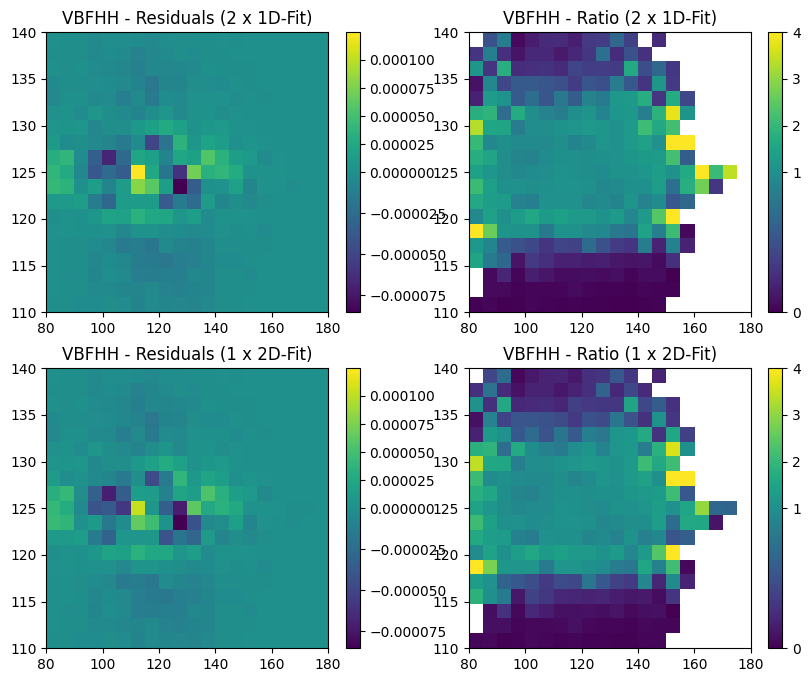

In [193]:
import matplotlib.colors as mcolors

VBFHH_2d_diff = VBFHH_2d(MYY_bin_centers,MBB_bin_centers) * VBFHH_2d_N - VBFHH_hist2d
VBFHH_2d_ratio = VBFHH_2d(MYY_bin_centers,MBB_bin_centers) * VBFHH_2d_N / VBFHH_hist2d

VBFHH_2dfit_diff = VBFHH_2dfit((MYY_bin_centers,MBB_bin_centers), *VBFHH_2d_popt) - VBFHH_hist2d
VBFHH_2dfit_ratio = VBFHH_2dfit((MYY_bin_centers,MBB_bin_centers), *VBFHH_2d_popt) / VBFHH_hist2d

fig, axes = plt.subplots(2, 2, figsize=(10, 8))


norm_residuals = mcolors.TwoSlopeNorm(vmin=np.min(VBFHH_2d_diff), vcenter=0, vmax=np.max(VBFHH_2d_diff))

norm_ratio = mcolors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=4)

im1 = axes[0, 0].imshow(VBFHH_2d_diff, cmap='viridis', extent=[80,180,110,140], norm=norm_residuals)
axes[0, 0].set_title('VBFHH - Residuals (2 x 1D-Fit)')
axes[0, 0].set_aspect('auto')
fig.colorbar(im1, ax=axes[0,0])

im2 = axes[0, 1].imshow(VBFHH_2d_ratio, cmap='viridis', extent=[80,180,110,140], norm=norm_ratio)
axes[0, 1].set_title('VBFHH - Ratio (2 x 1D-Fit)')
axes[0, 1].set_aspect('auto')
fig.colorbar(im2, ax=axes[0,1], ticks=[0,1,2,3,4])

im3 = axes[1, 0].imshow(VBFHH_2dfit_diff, cmap='viridis', extent=[80,180,110,140], norm=norm_residuals)
axes[1, 0].set_title('VBFHH - Residuals (1 x 2D-Fit)')
axes[1, 0].set_aspect('auto')
fig.colorbar(im3, ax=axes[1,0])

im4 = axes[1, 1].imshow(VBFHH_2dfit_ratio, cmap='viridis', extent=[80,180,110,140], norm=norm_ratio)
axes[1, 1].set_title('VBFHH - Ratio (1 x 2D-Fit)')
axes[1, 1].set_aspect('auto')
fig.colorbar(im4, ax=axes[1,1], ticks=[0,1,2,3,4])

### ggFH

In [194]:
def ggFH_2dfit(myymbb, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2,  mu, sigma, N):
    myy, mbb = myymbb

    return ggFH_2d_N * gauss_func(mbb, mu, sigma, N) * dscb_func(myy, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2)

In [195]:
def ggFH_fit_2dfit(myymbb, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2, mu, sigma, N):
    myy, mbb = myymbb

    value = ggFH_2d_N * gauss_func(mbb, mu, sigma, N) * dscb_func(myy, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2)

    return value.ravel()

ggFH_2d_labels = [r'$\mu_{myy}$', r'$\sigma_{myy}$', r'$\alpha_{L,myy}$', r'$\alpha_{R,myy}$', r'n$_{L,myy}$', r'n$_{R,myy}$', 'N$_{myy}$', \
                  r'$\mu_{L,mbb}$', r'$\sigma_{L,mbb}$', r'N$_{mbb}$',]
ggFH_2d_units = ['GeV', 'GeV', ' ',  ' ', ' ' , ' ', ' ', 'GeV', 'GeV', ' ']

In [196]:
ggFH_mbb_popt, ggFH_myy_popt

(array([1.16893875e+05, 1.64403720e+04, 2.89847872e-02]),
 array([1.25127122e+05, 1.28582278e+03, 1.50995388e+00, 1.14068051e+00,
        4.55467151e+01, 1.46235305e+02, 1.08158392e-01]))

In [197]:
ggFH_2d_err = poisson_error(ggFH_hist2d)

VBFHH_2d_bounds = [[1.249e5, 1.4e3, 1,   1,   7.5, 1.4e2, 5e-3,   1.17e5, 1.13e4, 1,   2.5, 1.4e2, 5.5,  7e-3], \
                   [1.255e5, 1.5e3, 1.5, 1.5, 8.2, 1.6e2, 5.5e-3, 1.19e5, 1.15e4, 1.2, 3.2, 1.5e2, 6.25, 8e-3]]

ggFH_2d_popt, ggFH_2d_pcov = curve_fit(ggFH_fit_2dfit, (MYY_bin_centers,MBB_bin_centers), ggFH_hist2d.ravel(), p0=[*ggFH_myy_popt, *ggFH_mbb_popt], \
                                         sigma=np.mean(ggFH_2d_err, axis=0).ravel(), absolute_sigma=True)

ggFH_2d_chi_red = np.sum( (ggFH_fit_2dfit((MYY_bin_centers,MBB_bin_centers),*ggFH_2d_popt)-VBFHH_hist2d.ravel())**2 / np.mean(ggFH_2d_err, axis=0).ravel()**2 )

ggFH_2d_legend = get_legend(ggFH_2d_popt, ggFH_2d_pcov, ggFH_2d_chi_red, ggFH_2d_labels, ggFH_2d_units)

/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


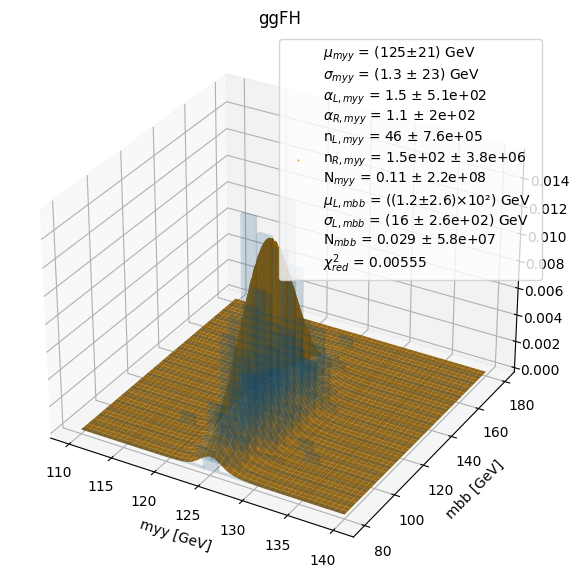

In [198]:
import matplotlib.lines as mlines

dz = ggFH_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))
ax.set_yticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

surf = ax.plot_surface(MYY, MBB, ggFH_2dfit((MYY,MBB), *ggFH_2d_popt), alpha=0.9, color='orange')

ax.set_xlabel('myy [GeV]')
ax.set_ylabel('mbb [GeV]')
plt.title('ggFH')

proxy = mlines.Line2D([0],[0], color='orange', marker='.', linestyle='None', markersize=1, label=ggFH_2d_legend)
ax.legend(handles=[proxy])

plt.show()

#plt.savefig('./Plots/2D-plots/Y0_2d.pdf', format='pdf')

In [199]:
from tabulate import tabulate

ggFH_text = np.array(['mu_myy', 'sigma_myy', 'alpha_L_myy', 'alpha_R_myy', 'n_L_myy', 'n_R_myy', 'N_myy', \
                     'mu_mbb', 'sigma_mbb', 'N_mbb'])

ggFH_2d_tab = np.array([ggFH_text, ggFH_2d_popt, np.concatenate([ggFH_myy_popt, ggFH_mbb_popt]), \
                         np.sqrt(np.diag(ggFH_2d_pcov)), np.concatenate([np.sqrt(np.diag(ggFH_myy_pcov)), np.sqrt(np.diag(ggFH_mbb_pcov))]) ])

print(tabulate(ggFH_2d_tab.T, stralign='left', headers=['', '2d_values', '1d_values', '2d_uncertainties', '1d_uncertainties']))

                  2d_values       1d_values    2d_uncertainties    1d_uncertainties
-----------  --------------  --------------  ------------------  ------------------
mu_myy       125127          125127             21091.5                 3.89514
sigma_myy      1285.82         1285.82          23098.2                 3.97158
alpha_L_myy       1.50995         1.50995         505.635               0.0870556
alpha_R_myy       1.14068         1.14068         197.744               0.0340067
n_L_myy          45.5467         45.5467       755145                 129.392
n_R_myy         146.235         146.235             3.83145e+06       657.652
N_myy             0.108158        0.108158          2.17938e+08         0.000294344
mu_mbb       116894          116894            259960                  84.0556
sigma_mbb     16440.4         16440.4          261545                  84.6327
N_mbb             0.0289848       0.0289848         5.84042e+07         0.000129966


/tmp/ipykernel_385/1117526415.py:4: RuntimeWarning: divide by zero encountered in divide
  ggFH_2d_ratio = ggFH_2d(MYY_bin_centers,MBB_bin_centers) * ggFH_2d_N / ggFH_hist2d
/tmp/ipykernel_385/1117526415.py:7: RuntimeWarning: divide by zero encountered in divide
  ggFH_2dfit_ratio = ggFH_2dfit((MYY_bin_centers,MBB_bin_centers), *ggFH_2d_popt) / ggFH_hist2d


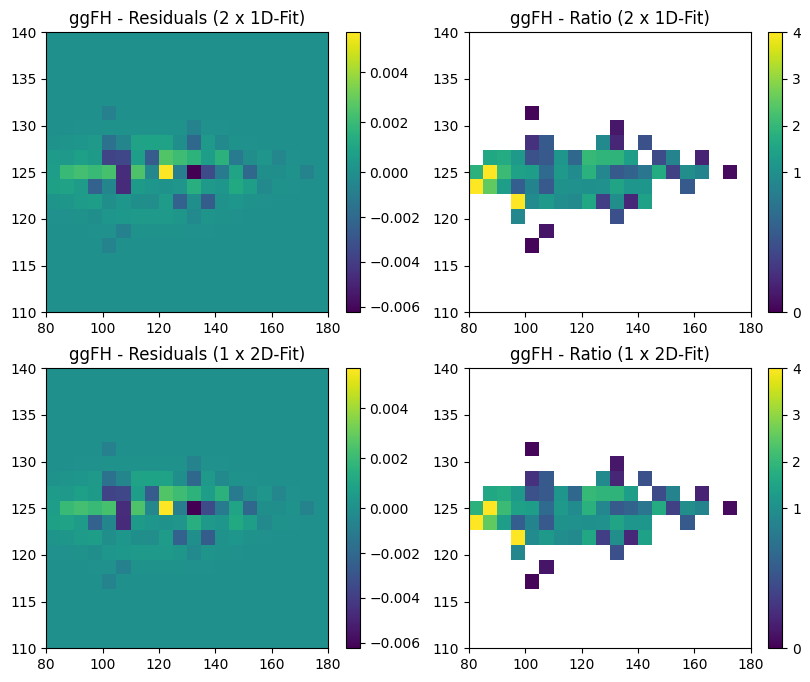

In [200]:
import matplotlib.colors as mcolors

ggFH_2d_diff = ggFH_2d(MYY_bin_centers,MBB_bin_centers) * ggFH_2d_N - ggFH_hist2d
ggFH_2d_ratio = ggFH_2d(MYY_bin_centers,MBB_bin_centers) * ggFH_2d_N / ggFH_hist2d

ggFH_2dfit_diff = ggFH_2dfit((MYY_bin_centers,MBB_bin_centers), *ggFH_2d_popt) - ggFH_hist2d
ggFH_2dfit_ratio = ggFH_2dfit((MYY_bin_centers,MBB_bin_centers), *ggFH_2d_popt) / ggFH_hist2d

fig, axes = plt.subplots(2, 2, figsize=(10, 8))


norm_residuals = mcolors.TwoSlopeNorm(vmin=np.min(ggFH_2d_diff), vcenter=0, vmax=np.max(ggFH_2d_diff))

norm_ratio = mcolors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=4)

im1 = axes[0, 0].imshow(ggFH_2d_diff, cmap='viridis', extent=[80,180,110,140], norm=norm_residuals)
axes[0, 0].set_title('ggFH - Residuals (2 x 1D-Fit)')
axes[0, 0].set_aspect('auto')
fig.colorbar(im1, ax=axes[0,0])

im2 = axes[0, 1].imshow(ggFH_2d_ratio, cmap='viridis', extent=[80,180,110,140], norm=norm_ratio)
axes[0, 1].set_title('ggFH - Ratio (2 x 1D-Fit)')
axes[0, 1].set_aspect('auto')
fig.colorbar(im2, ax=axes[0,1], ticks=[0,1,2,3,4])

im3 = axes[1, 0].imshow(ggFH_2dfit_diff, cmap='viridis', extent=[80,180,110,140], norm=norm_residuals)
axes[1, 0].set_title('ggFH - Residuals (1 x 2D-Fit)')
axes[1, 0].set_aspect('auto')
fig.colorbar(im3, ax=axes[1,0])

im4 = axes[1, 1].imshow(ggFH_2dfit_ratio, cmap='viridis', extent=[80,180,110,140], norm=norm_ratio)
axes[1, 1].set_title('ggFH - Ratio (1 x 2D-Fit)')
axes[1, 1].set_aspect('auto')
fig.colorbar(im4, ax=axes[1,1], ticks=[0,1,2,3,4])

### ttH

In [201]:
def ttH_2dfit(myymbb, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2):
    myy, mbb = myymbb

    return ttH_2d_N * dscb_func(myy, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1) * dscb_func(mbb, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2)

In [202]:
def ttH_fit_2dfit(myymbb, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2):
    myy, mbb = myymbb

    value = ttH_2d_N * dscb_func(myy, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1) * dscb_func(mbb, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2)

    return value.ravel()

ttH_2dfit_labels = [r'$\mu_{myy}$', r'$\sigma_{myy}$', r'$\alpha_{L,myy}$', r'$\alpha_{R,myy}$', r'n$_{L,myy}$', r'n$_{R,myy}$', 'N$_{myy}$', \
                     r'$\mu_{mbb}$', r'$\sigma_{mbb}$', r'$\alpha_{L,mbb}$', r'$\alpha_{R,mbb}$', r'n$_{L,mbb}$', r'n$_{R,mbb}$', 'N$_{mbb}$']
ttH_2dfit_units = ['GeV', 'GeV', ' ', ' ', ' ', ' ', ' ', 'GeV', 'GeV', ' ', ' ', ' ', ' ', ' ']

In [203]:
ttH_2d_err = poisson_error(ttH_hist2d)

ttH_2d_popt, ttH_2d_pcov = curve_fit(ttH_fit_2dfit, (MYY_bin_centers,MBB_bin_centers), ttH_hist2d.ravel(), p0=[125e3, 3.5e3, 1.64, 1.64612321e+00, \
       1.3, 13, 0.016,120000,15000,0.8,0.8,25,25,0.016], \
                                         sigma=np.mean(ttH_2d_err, axis=0).ravel(), absolute_sigma=True)

ttH_2d_chi_red = np.sum( (ttH_fit_2dfit((MYY_bin_centers,MBB_bin_centers),*ttH_2d_popt)-ttH_hist2d.ravel())**2 / np.mean(ttH_2d_err, axis=0).ravel()**2 )

ttH_2d_legend = get_legend(ttH_2d_popt, ttH_2d_pcov, ttH_2d_chi_red, ttH_2dfit_labels, ttH_2dfit_units)

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: invalid value encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: overflow encountered in scalar power
  A_L =

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


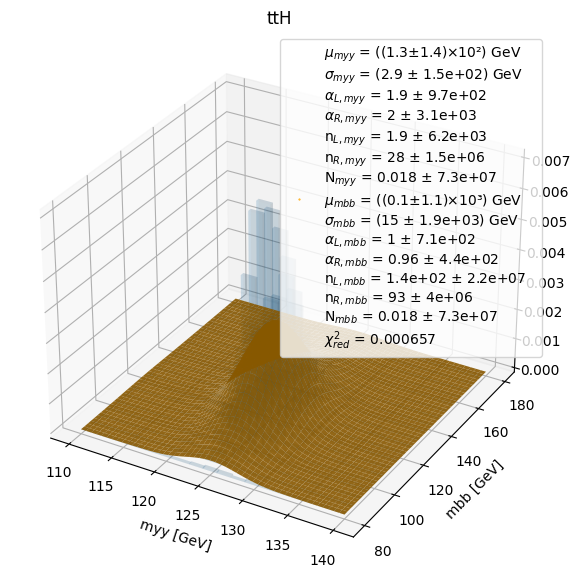

In [204]:
import matplotlib.lines as mlines

dz = ttH_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))
ax.set_yticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

surf = ax.plot_surface(MYY, MBB, ttH_2dfit((MYY,MBB), *ttH_2d_popt), alpha=0.9, color='orange')

ax.set_xlabel('myy [GeV]')
ax.set_ylabel('mbb [GeV]')
plt.title('ttH')

proxy = mlines.Line2D([0],[0], color='orange', marker='.', linestyle='None', markersize=1, label=ttH_2d_legend)
ax.legend(handles=[proxy])

plt.show()

#plt.savefig('./Plots/2D-plots/Y0_2d.pdf', format='pdf')

In [205]:
from tabulate import tabulate

tab_text = np.array(['mu_myy', 'sigma_myy', 'alpha_L_myy', 'alpha_R_myy', 'n_L_myy', 'n_R_myy', 'N_myy', \
                     'mu_mbb', 'sigma_mbb', 'alpha_L_mbb', 'alpha_R_mbb', 'n_L_mbb', 'n_R_mbb', 'N_mbb'])

ttH_2d_tab = np.array([tab_text, ttH_2d_popt, np.concatenate([ttH_myy_popt, ttH_mbb_popt]), \
                         np.sqrt(np.diag(ttH_2d_pcov)), np.concatenate([np.sqrt(np.diag(ttH_myy_pcov)), np.sqrt(np.diag(ttH_mbb_pcov))]) ])

print(tabulate(ttH_2d_tab.T, stralign='left', headers=['', '2d_values', '1d_values', '2d_uncertainties', '1d_uncertainties']))

                  2d_values       1d_values    2d_uncertainties    1d_uncertainties
-----------  --------------  --------------  ------------------  ------------------
mu_myy       125194          125246            144435                   0.440551
sigma_myy      2942.36         1321.4          149386                   0.474302
alpha_L_myy       1.8744          1.5644          971.671               0.0103191
alpha_R_myy       1.96989         1.25887        3109.87                0.00427008
n_L_myy           1.91391        19.8931         6199.6                 3.00139
n_R_myy          27.7596        148.74              1.49791e+06        83.1598
N_myy             0.0184998       0.0482395         7.26131e+07         1.40363e-05
mu_mbb       119727          119493                 1.05376e+06         7.32103
sigma_mbb     14918.7         12244.5               1.91733e+06         9.76128
alpha_L_mbb       0.999293        1.43867         711.073               0.0128892
alpha_R_mbb       0.

/tmp/ipykernel_385/866231312.py:4: RuntimeWarning: divide by zero encountered in divide
  ttH_2d_ratio = ttH_2d(MYY_bin_centers,MBB_bin_centers) * ttH_2d_N / ttH_hist2d
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/866231312.py:7: RuntimeWarning: divide by zero encountered in divide
  ttH_2dfit_ratio = ttH_2dfit((MYY_bin_centers,MBB_bin_centers), *ttH_2d_popt) / ttH_hist2d


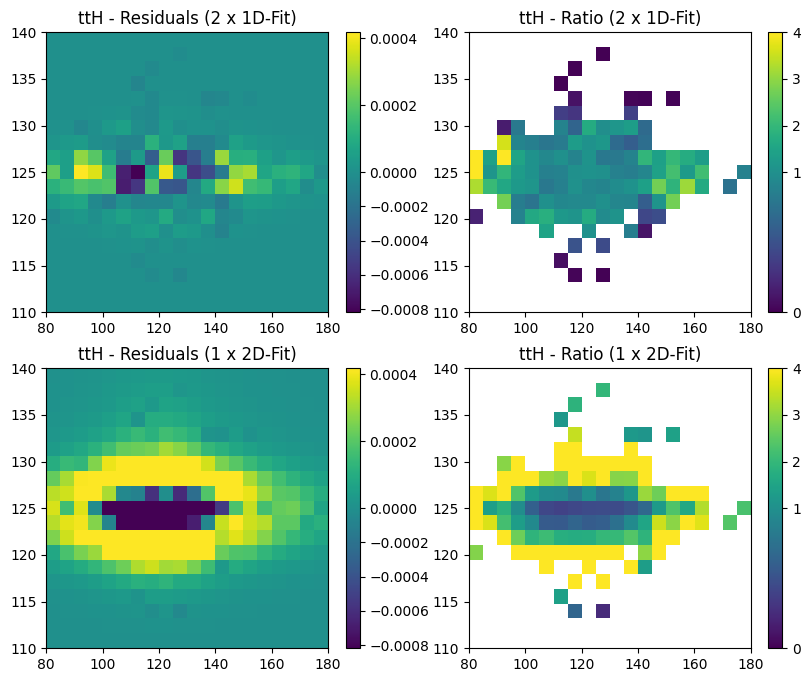

In [206]:
import matplotlib.colors as mcolors

ttH_2d_diff = ttH_2d(MYY_bin_centers,MBB_bin_centers) * ttH_2d_N - ttH_hist2d
ttH_2d_ratio = ttH_2d(MYY_bin_centers,MBB_bin_centers) * ttH_2d_N / ttH_hist2d

ttH_2dfit_diff = ttH_2dfit((MYY_bin_centers,MBB_bin_centers), *ttH_2d_popt) - ttH_hist2d
ttH_2dfit_ratio = ttH_2dfit((MYY_bin_centers,MBB_bin_centers), *ttH_2d_popt) / ttH_hist2d

fig, axes = plt.subplots(2, 2, figsize=(10, 8))


norm_residuals = mcolors.TwoSlopeNorm(vmin=np.min(ttH_2d_diff), vcenter=0, vmax=np.max(ttH_2d_diff))

norm_ratio = mcolors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=4)

im1 = axes[0, 0].imshow(ttH_2d_diff, cmap='viridis', extent=[80,180,110,140], norm=norm_residuals)
axes[0, 0].set_title('ttH - Residuals (2 x 1D-Fit)')
axes[0, 0].set_aspect('auto')
fig.colorbar(im1, ax=axes[0,0])

im2 = axes[0, 1].imshow(ttH_2d_ratio, cmap='viridis', extent=[80,180,110,140], norm=norm_ratio)
axes[0, 1].set_title('ttH - Ratio (2 x 1D-Fit)')
axes[0, 1].set_aspect('auto')
fig.colorbar(im2, ax=axes[0,1], ticks=[0,1,2,3,4])

im3 = axes[1, 0].imshow(ttH_2dfit_diff, cmap='viridis', extent=[80,180,110,140], norm=norm_residuals)
axes[1, 0].set_title('ttH - Residuals (1 x 2D-Fit)')
axes[1, 0].set_aspect('auto')
fig.colorbar(im3, ax=axes[1,0])

im4 = axes[1, 1].imshow(ttH_2dfit_ratio, cmap='viridis', extent=[80,180,110,140], norm=norm_ratio)
axes[1, 1].set_title('ttH - Ratio (1 x 2D-Fit)')
axes[1, 1].set_aspect('auto')
fig.colorbar(im4, ax=axes[1,1], ticks=[0,1,2,3,4])

### qqZH

In [207]:
def qqZH_2dfit(myymbb, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1, mu2, sigma2,  alpha_R2,  n_R2, N2):
    myy, mbb = myymbb

    return qqZH_2d_N * dscb_func(myy, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1) * cb_func(mbb, mu2, sigma2,  alpha_R2,  n_R2, N2)

In [208]:
def qqZH_fit_2dfit(myymbb, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1, mu2, sigma2, alpha_R2,  n_R2, N2):
    myy, mbb = myymbb

    value = qqZH_2d_N * dscb_func(myy, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1) * cb_func(mbb, mu2, sigma2, alpha_R2, n_R2, N2)

    return value.ravel()

qqZH_2dfit_labels = [r'$\mu_{myy}$', r'$\sigma_{myy}$', r'$\alpha_{L,myy}$', r'$\alpha_{R,myy}$', r'n$_{L,myy}$', r'n$_{R,myy}$', 'N$_{myy}$', \
                     r'$\mu_{mbb}$', r'$\sigma_{mbb}$', r'$\alpha_{mbb}$', r'n$_{mbb}$', 'N$_{mbb}$']
qqZH_2dfit_units = ['GeV', 'GeV', ' ', ' ', ' ', ' ', ' ', 'GeV', 'GeV', ' ', ' ', ' ']

In [209]:
qqZH_2d_err = poisson_error(qqZH_hist2d)

qqZH_2d_popt, qqZH_2d_pcov = curve_fit(qqZH_fit_2dfit, (MYY_bin_centers,MBB_bin_centers), qqZH_hist2d.ravel(), p0=[125e3, 4.096e3, 1.64, 1.64612321e+00, \
       40, 12, 0.03, 100e3, 4e3, 0.5, 25, 0.04], \
                                         sigma=np.mean(qqZH_2d_err, axis=0).ravel(), absolute_sigma=True)

qqZH_2d_chi_red = np.sum( (qqZH_fit_2dfit((MYY_bin_centers,MBB_bin_centers),*qqZH_2d_popt)-qqZH_hist2d.ravel())**2 / np.mean(qqZH_2d_err, axis=0).ravel()**2 )

qqZH_2d_legend = get_legend(qqZH_2d_popt, qqZH_2d_pcov, qqZH_2d_chi_red, qqZH_2dfit_labels, qqZH_2dfit_units)

/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: overflow encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in multiply
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/1638362595.py:2: RuntimeWarning: invalid value encountered in scalar power
  A = (n / np.abs(alpha)) ** n * np.exp(-0.5 * alpha ** 2)
/tmp/ipykernel_385/1638362595.py:5: RuntimeWarning: invalid value encountered in power
  right = N * A * (B - (mu - x) / sigma) ** -n
/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: invalid value encountered in scalar power
  A_L = (n_L / np.ab

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


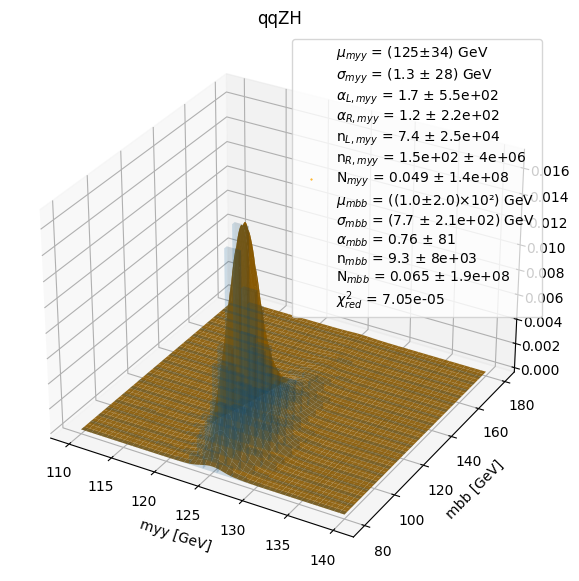

In [210]:
import matplotlib.lines as mlines

dz = qqZH_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))
ax.set_yticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

surf = ax.plot_surface(MYY, MBB, qqZH_2dfit((MYY,MBB), *qqZH_2d_popt), alpha=0.9, color='orange')

ax.set_xlabel('myy [GeV]')
ax.set_ylabel('mbb [GeV]')
plt.title('qqZH')

proxy = mlines.Line2D([0],[0], color='orange', marker='.', linestyle='None', markersize=1, label=qqZH_2d_legend)
ax.legend(handles=[proxy])

plt.show()

#plt.savefig('./Plots/2D-plots/Y0_2d.pdf', format='pdf')

In [211]:
from tabulate import tabulate

tab_text = np.array(['mu_myy', 'sigma_myy', 'alpha_L_myy', 'alpha_R_myy', 'n_L_myy', 'n_R_myy', 'N_myy', \
                     'mu_mbb', 'sigma_mbb', 'alpha_mbb', 'n_mbb', 'N_mbb'])

qqZH_2d_tab = np.array([tab_text, qqZH_2d_popt, np.concatenate([qqZH_myy_popt, qqZH_mbb_popt]), \
                         np.sqrt(np.diag(qqZH_2d_pcov)), np.concatenate([np.sqrt(np.diag(qqZH_myy_pcov)), np.sqrt(np.diag(qqZH_mbb_pcov))]) ])

print(tabulate(qqZH_2d_tab.T, stralign='left', headers=['', '2d_values', '1d_values', '2d_uncertainties', '1d_uncertainties']))

                  2d_values       1d_values    2d_uncertainties    1d_uncertainties
-----------  --------------  --------------  ------------------  ------------------
mu_myy       125289          125293             33784.5                 0.472278
sigma_myy      1321.61         1345.14          28278.2                 0.527751
alpha_L_myy       1.70631         1.8199          554.668               0.0088788
alpha_R_myy       1.19208         1.20307         219.667               0.00371601
n_L_myy           7.41109         4.37545       25396.6                 0.172333
n_R_myy         147.336         147.575             4.01022e+06        73.4643
N_myy             0.0486518       0.0813193         1.42611e+08         2.55044e-05
mu_mbb       101033          101275            203758                   5.9449
sigma_mbb      7735.9          7766.76         210235                   6.34935
alpha_mbb         0.756711        0.721261         80.5918              0.00208113
n_mbb             9

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/4228207105.py:4: RuntimeWarning: divide by zero encountered in divide
  qqZH_2d_ratio = qqZH_2d(MYY_bin_centers,MBB_bin_centers) * qqZH_2d_N / qqZH_hist2d
/tmp/ipykernel_385/4228207105.py:7: RuntimeWarning: divide by zero encountered in divide
  qqZH_2dfit_ratio = qqZH_2dfit((MYY_bin_centers,MBB_bin_centers), *qqZH_2d_popt) / qqZH_hist2d


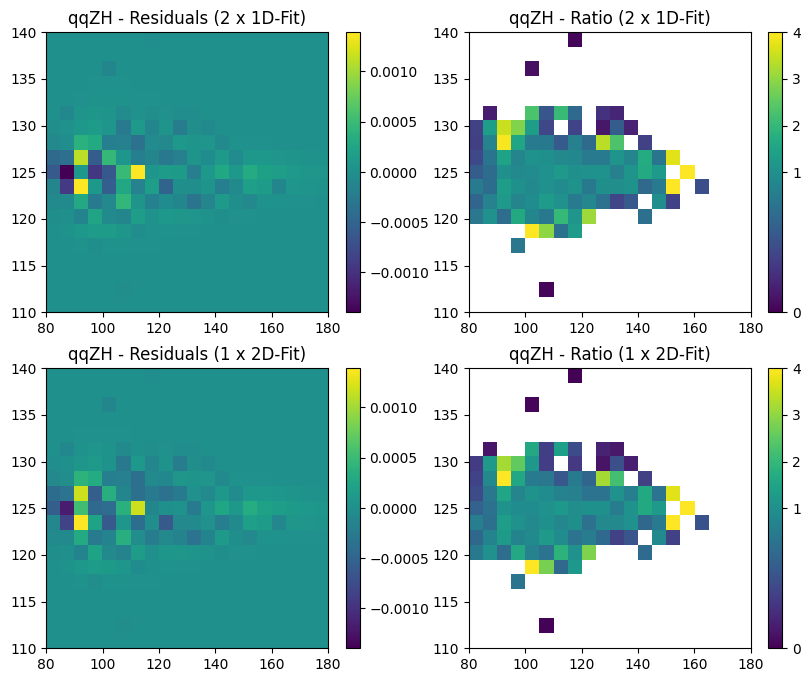

In [212]:
import matplotlib.colors as mcolors

qqZH_2d_diff = qqZH_2d(MYY_bin_centers,MBB_bin_centers) * qqZH_2d_N - qqZH_hist2d
qqZH_2d_ratio = qqZH_2d(MYY_bin_centers,MBB_bin_centers) * qqZH_2d_N / qqZH_hist2d

qqZH_2dfit_diff = qqZH_2dfit((MYY_bin_centers,MBB_bin_centers), *qqZH_2d_popt) - qqZH_hist2d
qqZH_2dfit_ratio = qqZH_2dfit((MYY_bin_centers,MBB_bin_centers), *qqZH_2d_popt) / qqZH_hist2d

fig, axes = plt.subplots(2, 2, figsize=(10, 8))


norm_residuals = mcolors.TwoSlopeNorm(vmin=np.min(qqZH_2d_diff), vcenter=0, vmax=np.max(qqZH_2d_diff))

norm_ratio = mcolors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=4)

im1 = axes[0, 0].imshow(qqZH_2d_diff, cmap='viridis', extent=[80,180,110,140], norm=norm_residuals)
axes[0, 0].set_title('qqZH - Residuals (2 x 1D-Fit)')
axes[0, 0].set_aspect('auto')
fig.colorbar(im1, ax=axes[0,0])

im2 = axes[0, 1].imshow(qqZH_2d_ratio, cmap='viridis', extent=[80,180,110,140], norm=norm_ratio)
axes[0, 1].set_title('qqZH - Ratio (2 x 1D-Fit)')
axes[0, 1].set_aspect('auto')
fig.colorbar(im2, ax=axes[0,1], ticks=[0,1,2,3,4])

im3 = axes[1, 0].imshow(qqZH_2dfit_diff, cmap='viridis', extent=[80,180,110,140], norm=norm_residuals)
axes[1, 0].set_title('qqZH - Residuals (1 x 2D-Fit)')
axes[1, 0].set_aspect('auto')
fig.colorbar(im3, ax=axes[1,0])

im4 = axes[1, 1].imshow(qqZH_2dfit_ratio, cmap='viridis', extent=[80,180,110,140], norm=norm_ratio)
axes[1, 1].set_title('qqZH - Ratio (1 x 2D-Fit)')
axes[1, 1].set_aspect('auto')
fig.colorbar(im4, ax=axes[1,1], ticks=[0,1,2,3,4])

### yybb

In [213]:
def yybb_2dfit(myymbb, a, l, mu2, sigma2, alpha_R2, n_R2, N2):
    myy, mbb = myymbb

    return yybb_2d_N * exp_fit(myy, a, l) * cb_func(mbb, mu2, sigma2, alpha_R2, n_R2, N2)

yybb_2d_labels = ['a$_{myy}$', r'$\lambda_{myy}$', r'$\mu_{mbb}$', r'$\sigma_{mbb}$', r'$\alpha_{mbb}$', r'n$_{mbb}$', 'N$_{mbb}$']
yybb_2d_units = [' ', r'GeV$^{-1}$', 'GeV', 'GeV', ' ', ' ', ' ', ' ', ' ']

In [214]:
def yybb_fit_2dfit(myymbb, a, l, mu2, sigma2, alpha_R2, n_R2, N2):
    myy, mbb = myymbb

    value = yybb_2d_N * exp_fit(myy, a, l) * cb_func(mbb, mu2, sigma2, alpha_R2, n_R2, N2)

    return value.ravel()

In [215]:
yybb_2d_err = poisson_error(yybb_hist2d)

yybb_2d_popt, yybb_2d_pcov = curve_fit(yybb_fit_2dfit, (MYY_bin_centers,MBB_bin_centers), yybb_hist2d.ravel(), p0=[*yybb_myy_popt*1.001, *yybb_mbb_popt*1.0000001], \
                                         sigma=np.mean(yybb_2d_err, axis=0).ravel(), absolute_sigma=True)

yybb_2d_chi_red = np.sum( (yybb_fit_2dfit((MYY_bin_centers,MBB_bin_centers),*yybb_2d_popt)-yybb_hist2d.ravel())**2 / np.mean(yybb_2d_err, axis=0).ravel()**2 )

yybb_2d_legend = get_legend(yybb_2d_popt, yybb_2d_pcov, yybb_2d_chi_red, yybb_2d_labels, yybb_2d_units)

/tmp/ipykernel_385/1638362595.py:2: RuntimeWarning: overflow encountered in scalar power
  A = (n / np.abs(alpha)) ** n * np.exp(-0.5 * alpha ** 2)
/tmp/ipykernel_385/1638362595.py:5: RuntimeWarning: invalid value encountered in multiply
  right = N * A * (B - (mu - x) / sigma) ** -n


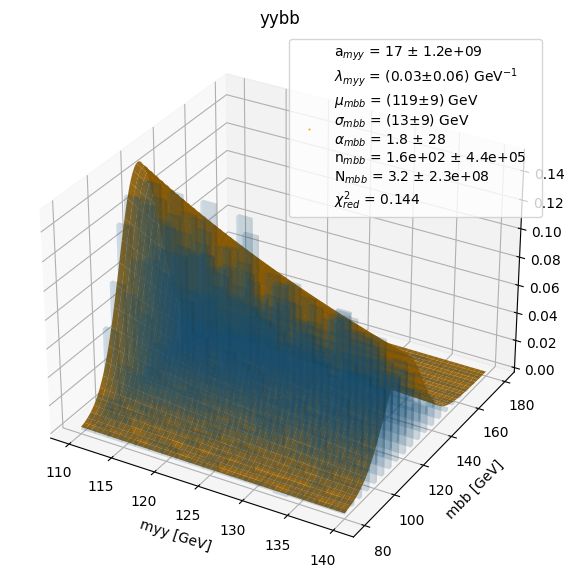

In [216]:
import matplotlib.lines as mlines

dz = yybb_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))
ax.set_yticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

surf = ax.plot_surface(MYY, MBB, yybb_2dfit((MYY,MBB), *yybb_2d_popt), alpha=0.9, color='orange')

ax.set_xlabel('myy [GeV]')
ax.set_ylabel('mbb [GeV]')
plt.title('yybb')

proxy = mlines.Line2D([0],[0], color='orange', marker='.', linestyle='None', markersize=1, label=yybb_2d_legend)
ax.legend(handles=[proxy])

plt.show()

#plt.savefig('./Plots/2D-plots/Y0_2d.pdf', format='pdf')

In [217]:
from tabulate import tabulate

yybb_text = np.array(['a_myy', 'lambda_myy', \
                     'mu_mbb', 'sigma_mbb', 'alpha_mbb', 'n_mbb', 'N_mbb'])

yybb_2d_tab = np.array([yybb_text, yybb_2d_popt, np.concatenate([yybb_myy_popt, yybb_mbb_popt]), \
                         np.sqrt(np.diag(yybb_2d_pcov)), np.concatenate([np.sqrt(np.diag(yybb_myy_pcov)), np.sqrt(np.diag(yybb_mbb_pcov))]) ])

print(tabulate(yybb_2d_tab.T, stralign='left', headers=['', '2d_values', '1d_values', '2d_uncertainties', '1d_uncertainties']))

                   2d_values         1d_values    2d_uncertainties    1d_uncertainties
----------  ----------------  ----------------  ------------------  ------------------
a_myy           17.0256           17.0345              1.21506e+09         0.0711546
lambda_myy       2.57784e-05       2.57407e-05         5.93857e-05         3.39205e-08
mu_mbb      118866            118947                8754.68                3.3565
sigma_mbb    13042             13007.6              9017.38                2.8428
alpha_mbb        1.77691           1.7948             28.1762              0.00606458
n_mbb          158.132           158.42           444768                  80.5864
N_mbb            3.18522           3.19007             2.2732e+08          0.000904537


/tmp/ipykernel_385/3026966545.py:4: RuntimeWarning: divide by zero encountered in divide
  yybb_2d_ratio = yybb_2d(MYY_bin_centers,MBB_bin_centers) * yybb_2d_N / yybb_hist2d
/tmp/ipykernel_385/3026966545.py:7: RuntimeWarning: divide by zero encountered in divide
  yybb_2dfit_ratio = yybb_2dfit((MYY_bin_centers,MBB_bin_centers), *yybb_2d_popt) / yybb_hist2d


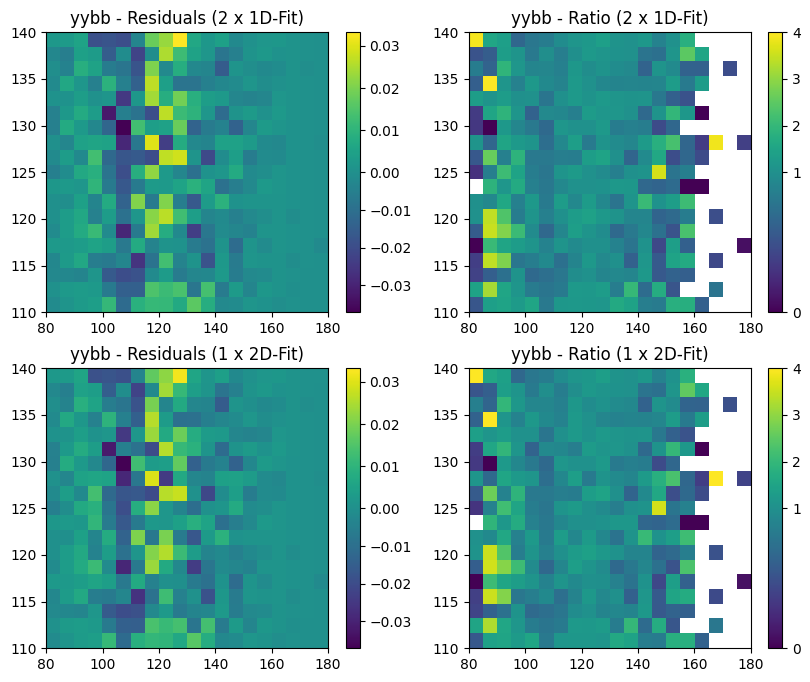

In [218]:
import matplotlib.colors as mcolors

yybb_2d_diff = yybb_2d(MYY_bin_centers,MBB_bin_centers) * yybb_2d_N - yybb_hist2d
yybb_2d_ratio = yybb_2d(MYY_bin_centers,MBB_bin_centers) * yybb_2d_N / yybb_hist2d

yybb_2dfit_diff = yybb_2dfit((MYY_bin_centers,MBB_bin_centers), *yybb_2d_popt) - yybb_hist2d
yybb_2dfit_ratio = yybb_2dfit((MYY_bin_centers,MBB_bin_centers), *yybb_2d_popt) / yybb_hist2d

fig, axes = plt.subplots(2, 2, figsize=(10, 8))


norm_residuals = mcolors.TwoSlopeNorm(vmin=np.min(yybb_2d_diff), vcenter=0, vmax=np.max(yybb_2d_diff))

norm_ratio = mcolors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=4)

im1 = axes[0, 0].imshow(yybb_2d_diff, cmap='viridis', extent=[80,180,110,140], norm=norm_residuals)
axes[0, 0].set_title('yybb - Residuals (2 x 1D-Fit)')
axes[0, 0].set_aspect('auto')
fig.colorbar(im1, ax=axes[0,0])

im2 = axes[0, 1].imshow(yybb_2d_ratio, cmap='viridis', extent=[80,180,110,140], norm=norm_ratio)
axes[0, 1].set_title('yybb - Ratio (2 x 1D-Fit)')
axes[0, 1].set_aspect('auto')
fig.colorbar(im2, ax=axes[0,1], ticks=[0,1,2,3,4])

im3 = axes[1, 0].imshow(yybb_2dfit_diff, cmap='viridis', extent=[80,180,110,140], norm=norm_residuals)
axes[1, 0].set_title('yybb - Residuals (1 x 2D-Fit)')
axes[1, 0].set_aspect('auto')
fig.colorbar(im3, ax=axes[1,0])

im4 = axes[1, 1].imshow(yybb_2dfit_ratio, cmap='viridis', extent=[80,180,110,140], norm=norm_ratio)
axes[1, 1].set_title('yybb - Ratio (1 x 2D-Fit)')
axes[1, 1].set_aspect('auto')
fig.colorbar(im4, ax=axes[1,1], ticks=[0,1,2,3,4])

### ggFHH_kl1

In [219]:
def ggFHH_kl1_2dfit(myymbb, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2):
    myy, mbb = myymbb

    return ggFHH_kl1_2d_N * dscb_func(myy, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1) * dscb_func(mbb, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2)

In [220]:
def ggFHH_kl1_fit_2dfit(myymbb, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2):
    myy, mbb = myymbb

    value = ggFHH_kl1_2d_N * dscb_func(myy, mu1, sigma1, alpha_L1, alpha_R1, n_L1, n_R1, N1) * dscb_func(mbb, mu2, sigma2, alpha_L2, alpha_R2, n_L2, n_R2, N2)

    return value.ravel()

ggFHH_kl1_2dfit_labels = [r'$\mu_{myy}$', r'$\sigma_{myy}$', r'$\alpha_{L,myy}$', r'$\alpha_{R,myy}$', r'n$_{L,myy}$', r'n$_{R,myy}$', 'N$_{myy}$', \
                     r'$\mu_{mbb}$', r'$\sigma_{mbb}$', r'$\alpha_{L,mbb}$', r'$\alpha_{R,mbb}$', r'n$_{L,mbb}$', r'n$_{R,mbb}$', 'N$_{mbb}$']
ggFHH_kl1_2dfit_units = ['GeV', 'GeV', ' ', ' ', ' ', ' ', ' ', 'GeV', 'GeV', ' ', ' ', ' ', ' ', ' ']

In [222]:
ggFHH_kl1_2d_err = poisson_error(ggFHH_kl1_hist2d)

ggFHH_kl1_2d_bounds = [[1.249e5, 1.4e3, 1,   1,   7.5, 1.4e2, 5e-3,   1.17e5, 1.13e4, 1,   2.5, 1.4e2, 5.5,  7e-3], \
                   [1.255e5, 1.5e3, 1.5, 1.5, 8.2, 1.6e2, 5.5e-3, 1.19e5, 1.15e4, 1.2, 3.2, 1.5e2, 6.25, 8e-3]]

ggFHH_kl1_2d_popt, ggFHH_kl1_2d_pcov = curve_fit(ggFHH_kl1_fit_2dfit, (MYY_bin_centers,MBB_bin_centers), ggFHH_kl1_hist2d.ravel(), \
                                                 p0=[125e3, 2.5e3, 1.64, 1.64612321e+00, \
       1.3, 13, 2.5, 120e3,10e3,1.5,1.5,23,23,1.3], \
                                                 sigma=np.mean(ggFHH_kl1_2d_err, axis=0).ravel(), absolute_sigma=True)

ggFHH_kl1_2d_chi_red = np.sum( (ggFHH_kl1_fit_2dfit((MYY_bin_centers,MBB_bin_centers),*ggFHH_kl1_2d_popt)-ggFHH_kl1_hist2d.ravel())**2 / np.mean(ggFHH_kl1_2d_err, axis=0).ravel()**2 )

ggFHH_kl1_2d_legend = get_legend(ggFHH_kl1_2d_popt, ggFHH_kl1_2d_pcov, ggFHH_kl1_2d_chi_red, ggFHH_kl1_2dfit_labels, ggFHH_kl1_2dfit_units)

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: invalid value encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_385/433496356.py:7: RuntimeWarning: overflow encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in multiply
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = 

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


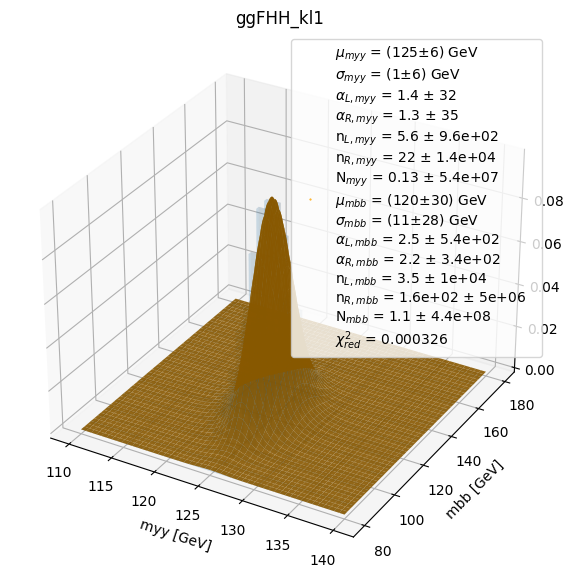

In [223]:
import matplotlib.lines as mlines

dz = ggFHH_kl1_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))
ax.set_yticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

surf = ax.plot_surface(MYY, MBB, ggFHH_kl1_2dfit((MYY,MBB), *ggFHH_kl1_2d_popt), alpha=0.9, color='orange')

ax.set_xlabel('myy [GeV]')
ax.set_ylabel('mbb [GeV]')
plt.title('ggFHH_kl1')

proxy = mlines.Line2D([0],[0], color='orange', marker='.', linestyle='None', markersize=1, label=ggFHH_kl1_2d_legend)
ax.legend(handles=[proxy])

plt.show()

#plt.savefig('./Plots/2D-plots/Y0_2d.pdf', format='pdf')

In [224]:
from tabulate import tabulate

tab_text = np.array(['mu_myy', 'sigma_myy', 'alpha_L_myy', 'alpha_R_myy', 'n_L_myy', 'n_R_myy', 'N_myy', \
                     'mu_mbb', 'sigma_mbb', 'alpha_L_mbb', 'alpha_R_mbb', 'n_L_mbb', 'n_R_mbb', 'N_mbb'])

ggFHH_kl1_2d_tab = np.array([tab_text, ggFHH_kl1_2d_popt, np.concatenate([ggFHH_kl1_myy_popt, ggFHH_kl1_mbb_popt]), \
                         np.sqrt(np.diag(ggFHH_kl1_2d_pcov)), np.concatenate([np.sqrt(np.diag(ggFHH_kl1_myy_pcov)), np.sqrt(np.diag(ggFHH_kl1_mbb_pcov))]) ])

print(tabulate(ggFHH_kl1_2d_tab.T, stralign='left', headers=['', '2d_values', '1d_values', '2d_uncertainties', '1d_uncertainties']))

                 2d_values      1d_values    2d_uncertainties    1d_uncertainties
-----------  -------------  -------------  ------------------  ------------------
mu_myy       125102         125115             5634.06                0.0137953
sigma_myy      1444.03        1445.13          5729.98                0.0175541
alpha_L_myy       1.37358        1.39285         31.6603              8.65645e-05
alpha_R_myy       1.30706        1.34023         34.9241              9.17803e-05
n_L_myy           5.58463        5.27915        960.477               0.00223519
n_R_myy          21.5386        13.3763       13542.5                 0.0135178
N_myy             0.128507       0.541442         5.37957e+07         5.47451e-06
mu_mbb       119700         119655            30288                   0.108146
sigma_mbb     10751.2        10758.9          27701.7                 0.105051
alpha_L_mbb       2.50394        2.50772        538.765               0.00204622
alpha_R_mbb       2.22672     

/tmp/ipykernel_385/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_385/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_385/1406140065.py:4: RuntimeWarning: divide by zero encountered in divide
  ggFHH_kl1_2d_ratio = ggFHH_kl1_2d(MYY_bin_centers,MBB_bin_centers) * ggFHH_kl1_2d_N / ggFHH_kl1_hist2d
/tmp/ipykernel_385/1406140065.py:7: RuntimeWarning: divide by zero encountered in divide
  ggFHH_kl1_2dfit_ratio = ggFHH_kl1_2dfit((MYY_bin_centers,MBB_bin_centers), *ggFHH_kl1_2d_popt) / ggFHH_kl1_hist2d


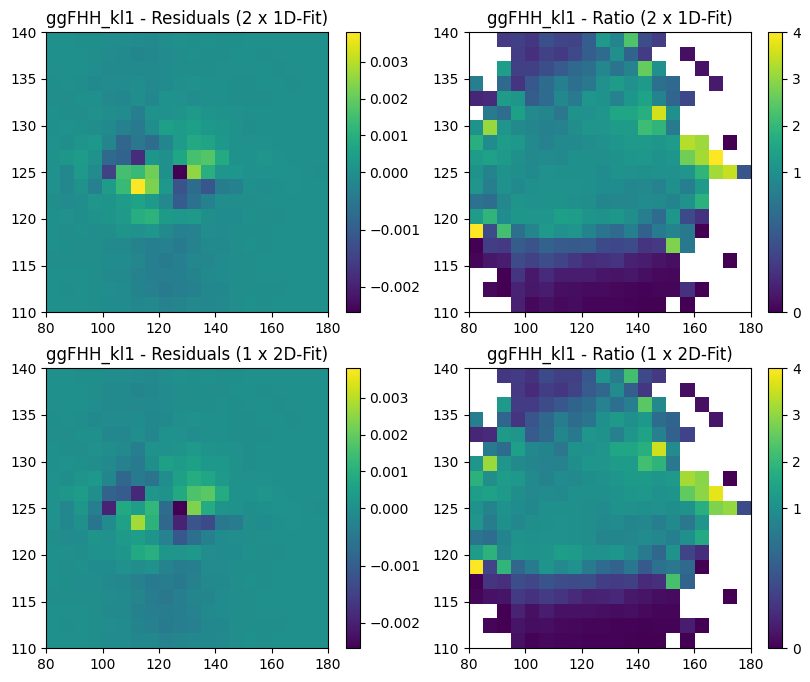

In [225]:
import matplotlib.colors as mcolors

ggFHH_kl1_2d_diff = ggFHH_kl1_2d(MYY_bin_centers,MBB_bin_centers) * ggFHH_kl1_2d_N - ggFHH_kl1_hist2d
ggFHH_kl1_2d_ratio = ggFHH_kl1_2d(MYY_bin_centers,MBB_bin_centers) * ggFHH_kl1_2d_N / ggFHH_kl1_hist2d

ggFHH_kl1_2dfit_diff = ggFHH_kl1_2dfit((MYY_bin_centers,MBB_bin_centers), *ggFHH_kl1_2d_popt) - ggFHH_kl1_hist2d
ggFHH_kl1_2dfit_ratio = ggFHH_kl1_2dfit((MYY_bin_centers,MBB_bin_centers), *ggFHH_kl1_2d_popt) / ggFHH_kl1_hist2d

fig, axes = plt.subplots(2, 2, figsize=(10, 8))


norm_residuals = mcolors.TwoSlopeNorm(vmin=np.min(ggFHH_kl1_2d_diff), vcenter=0, vmax=np.max(ggFHH_kl1_2d_diff))

norm_ratio = mcolors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=4)

im1 = axes[0, 0].imshow(ggFHH_kl1_2d_diff, cmap='viridis', extent=[80,180,110,140], norm=norm_residuals)
axes[0, 0].set_title('ggFHH_kl1 - Residuals (2 x 1D-Fit)')
axes[0, 0].set_aspect('auto')
fig.colorbar(im1, ax=axes[0,0])

im2 = axes[0, 1].imshow(ggFHH_kl1_2d_ratio, cmap='viridis', extent=[80,180,110,140], norm=norm_ratio)
axes[0, 1].set_title('ggFHH_kl1 - Ratio (2 x 1D-Fit)')
axes[0, 1].set_aspect('auto')
fig.colorbar(im2, ax=axes[0,1], ticks=[0,1,2,3,4])

im3 = axes[1, 0].imshow(ggFHH_kl1_2dfit_diff, cmap='viridis', extent=[80,180,110,140], norm=norm_residuals)
axes[1, 0].set_title('ggFHH_kl1 - Residuals (1 x 2D-Fit)')
axes[1, 0].set_aspect('auto')
fig.colorbar(im3, ax=axes[1,0])

im4 = axes[1, 1].imshow(ggFHH_kl1_2dfit_ratio, cmap='viridis', extent=[80,180,110,140], norm=norm_ratio)
axes[1, 1].set_title('ggFHH_kl1 - Ratio (1 x 2D-Fit)')
axes[1, 1].set_aspect('auto')
fig.colorbar(im4, ax=axes[1,1], ticks=[0,1,2,3,4])